This research looks at the Big Five personality and imposes it onto an LLM to determine if the model can behave in the same way as what the personality suggests. To Determine this, we need real humans to take the personality test and compare their results to the results of the LLM. Suppose the LLM's responses are closely similar to a human's. In that case, one can reasonably assume that the LLM understands the personality it was provided to roleplay. 

### Modules for the Notebook

In [1]:
import numpy as np
import pandas as pd
import datashader as ds
import holoviews as hv

from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

from sctriangulate.colors import build_custom_continuous_cmap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from holoviews.operation.datashader import datashade
from holoviews.operation import contours
from holoviews import opts, dim
from colorcet import fire
import hvplot.pandas


hv.extension('matplotlib')

datashade.cmap=fire[50:]

#opts.defaults(
#    opts.Image(cmap="gray_r", axiswise=True),
#    opts.Points(cmap="bwr", edgecolors='k', s=50, alpha=1.0), # Remove color_index=2
#    opts.RGB(bgcolor="white", show_grid=False))
#hv.output(fig='svg')

In [2]:
# Need to assign each personality test a label based on the 20 personality profiles
OCEAN_PROFILES = {
    "Paranoid": [0.3825, 0.6045, 0.3260, 0.2090, 0.6345],
    "Schizoid": [0.3600, 0.4875, 0.0850, 0.4275, 0.4425],
    "Schizotypal": [0.5415, 0.4050, 0.2265, 0.4215, 0.6570],
    "Antisocial": [0.5390, 0.3200, 0.5250, 0.2785, 0.5790],
    "Borderline": [0.5770, 0.3430, 0.5050, 0.3350, 0.7940],
    "Histrionic": [0.6455, 0.3730, 0.7485, 0.4410, 0.5705],
    "Narcissistic": [0.5505, 0.4490, 0.6200, 0.2230, 0.4985],
    "Avoidant": [0.4170, 0.4965, 0.1575, 0.4685, 0.8600],
    "Dependent": [0.4415, 0.4645, 0.3845, 0.6380, 0.7170],
    "Obsessive-Compulsive": [0.2685, 0.8545, 0.3695, 0.4705, 0.5625],
    "Pronoid": [0.6175, 0.3955, 0.6740, 0.7910, 0.3655],
    "People-person": [0.6400, 0.5125, 0.9150, 0.5725, 0.5575],
    "Sensible": [0.4585, 0.5950, 0.7735, 0.5785, 0.3430],
    "Prosocial": [0.4610, 0.6800, 0.4750, 0.7215, 0.4210],
    "Straightforward": [0.4230, 0.6570, 0.4950, 0.6650, 0.2060],
    "Non-theatrical": [0.3545, 0.6270, 0.2515, 0.5590, 0.4295],
    "Unpretentious": [0.4495, 0.5510, 0.3800, 0.7770, 0.5015],
    "Accommodating": [0.5830, 0.5035, 0.8425, 0.5315, 0.1400],
    "Independent": [0.5585, 0.5355, 0.6155, 0.3620, 0.2830],
    "Laissez-faire": [0.7315, 0.1455, 0.6305, 0.5295, 0.4375]
}


LABEL_NAMES = list(OCEAN_PROFILES.keys())

OCEAN_PROFILE_CORD = list(OCEAN_PROFILES.values())



LABEL_COLORS_HEX=["#e71d43",
                  "#ff0000",
                  "#ff3700",
                  "#ff6e00",
                  "#ffa500",
                  "#ffc300",
                  "#ffe100",
                  "#ffff00",
                  "#aad500",
                  "#55aa00",
                  "#008000",
                  "#005555",
                  "#002baa",
                  "#0000ff",
                  "#1900d5",
                  "#3200ac",
                  "#4b0082",
                  "#812ba6",
                  "#b857ca",
                  "#d03a87"]

LABEL_COLORS_RGP=[[231,29,67],
                  [255,0,0],
                  [255,55,0],
                  [255,110,0],
                  [255,165,0],
                  [255,195,0],
                  [255,225,0],
                  [255,255,0],
                  [170,213,0],
                  [85,170,0],
                  [0,128,0],
                  [0,85,85],
                  [0,43,120],
                  [0,0,255],
                  [25,0,213],
                  [50,0,172],
                  [75,0,130],
                  [129,43,166],
                  [184,87,202],
                  [208,58,135]]


LABEL_CMP = []

for color in LABEL_COLORS_RGP:
    cmap = build_custom_continuous_cmap([0,0,0], color)
    LABEL_CMP.append(cmap)

In [3]:
NP_OCEAN_PROFILES = np.array([[0.3825, 0.6045, 0.3260, 0.2090, 0.6345],
[0.3600, 0.4875, 0.0850, 0.4275, 0.4425],
[0.5415, 0.4050, 0.2265, 0.4215, 0.6570],
[0.5390, 0.3200, 0.5250, 0.2785, 0.5790],
[0.5770, 0.3430, 0.5050, 0.3350, 0.7940],
[0.6455, 0.3730, 0.7485, 0.4410, 0.5705],
[0.5505, 0.4490, 0.6200, 0.2230, 0.4985],
[0.4170, 0.4965, 0.1575, 0.4685, 0.8600],
[0.4415, 0.4645, 0.3845, 0.6380, 0.7170],
[0.2685, 0.8545, 0.3695, 0.4705, 0.5625],
[0.6175, 0.3955, 0.6740, 0.7910, 0.3655],
[0.6400, 0.5125, 0.9150, 0.5725, 0.5575],
[0.4585, 0.5950, 0.7735, 0.5785, 0.3430],
[0.4610, 0.6800, 0.4750, 0.7215, 0.4210],
[0.4230, 0.6570, 0.4950, 0.6650, 0.2060],
[0.3545, 0.6270, 0.2515, 0.5590, 0.4295],
[0.4495, 0.5510, 0.3800, 0.7770, 0.5015],
[0.5830, 0.5035, 0.8425, 0.5315, 0.1400],
[0.5585, 0.5355, 0.6155, 0.3620, 0.2830],
[0.7315, 0.1455, 0.6305, 0.5295, 0.4375]])

Personality_label = ["Paranoid",
"Schizoid",
"Schizotypal",
"Antisocial",
"Borderline",
"Histrionic",
"Narcissistic",
"Avoidant",
"Dependent",
"Obsessive-Compulsive",
"Pronoid",
"People-person",
"Sensible",
"Prosocial",
"Straightforward",
"Non-theatrical",
"Unpretentious",
"Accommodating",
"Independent",
"Laissez-faire"]

### Functions

In [4]:
def EvaluateOceanTestResults(np_matrix_with_50_questions):
    # Each question has a direction, 1 or -1. If the direction is positive (1) then that means each response is
    # evaluated as is (1, 2, 3, 4, 5). However, if the direction is negative (-1), then each response is reversed
    # from the initial order (5, 4, 3, 2, 1). Thus, if a negative question was responded with a 5, the evaluation
    # response is 1.

    # To perform this calculation, we can simply do intercept - response, which will provide us with the correct
    # negative evaluated response, but then all positive evaluated responses are negative. Given the list of 
    # directions, we can multiply that with -1, and multiply the evaluated list thus far with that to get the 
    # proper evaluated responses.
    
    question_direction = [1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,1,1,1,1,-1,1,-1,1,-1,1,-1,1,1,1,1,-1,1,-1,1,-1,1,-1,1,1,1,-1,1,-1,1,-1,1,1,1,1]
    question_subtract = [0,6,0,6,0,6,0,6,0,6,0,6,0,6,0,0,0,0,0,0,6,0,6,0,6,0,6,0,0,0,0,6,0,6,0,6,0,6,0,0,0,6,0,6,0,6,0,0,0,0]
    np_responses_eval = np.subtract(question_subtract, np_matrix_with_50_questions)
    np_responses_eval = np.multiply(np_responses_eval, np.multiply(question_direction, -1))

    np_ocean_eval = np.zeros((np_responses_eval.shape[0], 5), dtype=int)

    # Each row in the np_response is one entire test we need to evaluate
    row_id = 0
    for row_list in np_responses_eval:
        col_id = 0
        factor = -1
        ENACO_eval_int = [0, 0, 0, 0, 0]

        # Each column assosiates to a question response from the test. There are 10 questsions per factor, 
        # and there are 5 factors. To evaluate one factor, it is the summation of all questions. Thus the smallest
        # a single factor can be is 10, and the largest it can be is 50.
        # To calculate this, we will keep track of 10 questions that have been answered. All evaluations will be
        # added to it's associated factor. Once the 10th question has been answered, we will increment the factor
        # and continue the process so that the next 10 questions will be added to the next factor.
        
        for col_element in row_list:        
            if col_id % 10 == 0:
                factor += 1
            val = col_element
            ENACO_eval_int[factor] += val
            col_id += 1

        # Reorganize ENACO to OCEAN
        OCEAN_eval_int = [ENACO_eval_int[4],
                        ENACO_eval_int[3],
                        ENACO_eval_int[0],
                        ENACO_eval_int[2],
                        ENACO_eval_int[1]
                        ]

        for factor_idx in range(0, 5):
            np_ocean_eval[row_id, factor_idx] = OCEAN_eval_int[factor_idx]
        row_id += 1 

    return np.interp(np_ocean_eval, xp=[10, 20, 30, 40, 50], fp=[0.0, 0.25, 0.50, 0.75, 1.0])



def calc_CSCF(ocean_matrix):
    # To graph these values in the same way as the study, we will need to calculate the Cognitive Stability 
    # (ALPHA = Agreeableness + Conscientiousness + Emotional Stability) and Cognitive Flexability (BETA = Extraversion
    # + Openness)

    np_cscf = np.zeros((ocean_matrix.shape[0], 2), dtype=float)

    row_idx = 0
    for row_list in ocean_matrix:
        O = row_list[0]
        C = row_list[1]
        E = row_list[2]
        A = row_list[3]
        N = row_list[4]

        ALPHA = A + C + (1.0 - N)
        BETA = E + O
        
        np_cscf[row_idx, 0] = ALPHA
        np_cscf[row_idx, 1] = BETA
        
        row_idx += 1

    return np_cscf



def GetPersonalityProfileLabels(ocean_matrix):
    np_distance_from_eval_to_profile = np.zeros((ocean_matrix.shape[0], 20), dtype=float)
    np_label = np.zeros(ocean_matrix.shape[0], dtype=float)

    row_idx = 0
    for row_OCEAN in ocean_matrix:
        col_idx = 0
        for profile_name, profile_OCEAN in OCEAN_PROFILES.items():
            distance = np.linalg.norm(profile_OCEAN-row_OCEAN)
            np_distance_from_eval_to_profile[row_idx, col_idx] = distance
            col_idx += 1
        row_idx += 1

    row_idx = 0
    for row_distances in np_distance_from_eval_to_profile:
        np_label[row_idx] = np.argmin(row_distances)
        row_idx += 1

    return np_label



def CreateFullInfoDf(np_matrix_with_50_questions, np_ocean = None, np_cscf = None, np_label = None):
    # Combine np_responses_clean, np_OCEAN, np_CSCF, and np_label

    if np.any(np_ocean) == False:
        np_ocean = EvaluateOceanTestResults(np_matrix_with_50_questions)
    
    if np.any(np_cscf) == False:
        np_cscf = calc_CSCF(np_ocean)
    
    if np.any(np_label) == False:
        np_label = GetPersonalityProfileLabels(np_ocean)

    np_all_infromation = np.concatenate((np_matrix_with_50_questions, np_ocean, np_cscf, np.reshape(np_label, (np_label.shape[0], 1))), axis = 1)

    df_all_infromation = pd.DataFrame(np_all_infromation, columns =[
        "E1",
        "E2",
        "E3",
        "E4",
        "E5",
        "E6",
        "E7",
        "E8",
        "E9",
        "E10",
        "N1",
        "N2",
        "N3",
        "N4",
        "N5",
        "N6",
        "N7",
        "N8",
        "N9",
        "N10",
        "A1",
        "A2",
        "A3",
        "A4",
        "A5",
        "A6",
        "A7",
        "A8",
        "A9",
        "A10",
        "C1",
        "C2",
        "C3",
        "C4",
        "C5",
        "C6",
        "C7",
        "C8",
        "C9",
        "C10",
        "O1",
        "O2",
        "O3",
        "O4",
        "O5",
        "O6",
        "O7",
        "O8",
        "O9",
        "O10",
        "Openness",
        "Conscientiousness",
        "Extraversion",
        "Agreeableness",
        "Neuroticism",
        "Alpha",
        "Beta",
        "Label"
    ])

    data_types = {
        "E1" : "int",
        "E2": "int",
        "E3": "int",
        "E4": "int",
        "E5": "int",
        "E6": "int",
        "E7": "int",
        "E8": "int",
        "E9": "int",
        "E10": "int",
        "N1": "int",
        "N2": "int",
        "N3": "int",
        "N4": "int",
        "N5": "int",
        "N6": "int",
        "N7": "int",
        "N8": "int",
        "N9": "int",
        "N10": "int",
        "A1": "int",
        "A2": "int",
        "A3": "int",
        "A4": "int",
        "A5": "int",
        "A6": "int",
        "A7": "int",
        "A8": "int",
        "A9": "int",
        "A10": "int",
        "C1": "int",
        "C2": "int",
        "C3": "int",
        "C4": "int",
        "C5": "int",
        "C6": "int",
        "C7": "int",
        "C8": "int",
        "C9": "int",
        "C10": "int",
        "O1": "int",
        "O2": "int",
        "O3": "int",
        "O4": "int",
        "O5": "int",
        "O6": "int",
        "O7": "int",
        "O8": "int",
        "O9": "int",
        "O10": "int",
        "Openness": "float",
        "Conscientiousness": "float",
        "Extraversion": "float",
        "Agreeableness": "float",
        "Neuroticism": "float",
        "Alpha": "float",
        "Beta": "float",
        "Label": "int"
    }

    for col_name, dt in data_types.items():
        df_all_infromation[col_name] = df_all_infromation[col_name].astype(dt)

    return df_all_infromation



def CalcInterRaterReliability(np_matrix_with_50_questions):
    # Comparing all possible combinations of respopnses for a given label with
    # out repeat (the upper triangle), determing if the answer is exactly the same.
    total_similar_responses = 0
    total_responses_reviewed = 0
    
    for x_response_id in range(0, np_matrix_with_50_questions.shape[0]):
        np_r1 = np_matrix_with_50_questions[x_response_id]
        for y_response_id in range(x_response_id + 1, np_matrix_with_50_questions.shape[0]):
            np_r2 = np_matrix_with_50_questions[y_response_id]

            test_similarity = (np_r1==np_r2).astype(int)
            num_similar = np.sum(test_similarity)

            total_similar_responses += num_similar
            total_responses_reviewed += np_matrix_with_50_questions.shape[1]

    return total_similar_responses/total_responses_reviewed


def RootMeanSquaredError(np_array, np_predictor = None):
    total_error = np.zeros(np_array.shape)
    for idx in range(np_array.shape[0]):

        if isinstance(np_predictor, np.ndarray) == False:
            np_predictor = np.mean(np_array)

        element_difference = np.subtract(np_array[idx], np_predictor)
        element_sq = element_difference ** 2.0
        total_error[idx] = element_sq
        

    MSPE = np.mean(total_error, axis=0)
    RMSPE = np.sqrt(MSPE)
    return RMSPE
            

This data was collected (2016-2018) through an interactive on-line personality test.
The personality test was constructed with the "Big-Five Factor Markers" from the IPIP. https://ipip.ori.org/newBigFive5broadKey.htm
Participants were informed that their responses would be recorded and used for research at the beginning of the test, and asked to confirm their consent at the end of the test.

The following items were presented on one page and each was rated on a five point scale using radio buttons. The order on page was was EXT1, AGR1, CSN1, EST1, OPN1, EXT2, etc.
The scale was labeled 1=Disagree, 3=Neutral, 5=Agree

EXT1	I am the life of the party.
EXT2	I don't talk a lot.
EXT3	I feel comfortable around people.
EXT4	I keep in the background.
EXT5	I start conversations.
EXT6	I have little to say.
EXT7	I talk to a lot of different people at parties.
EXT8	I don't like to draw attention to myself.
EXT9	I don't mind being the center of attention.
EXT10	I am quiet around strangers.
EST1	I get stressed out easily.
EST2	I am relaxed most of the time.
EST3	I worry about things.
EST4	I seldom feel blue.
EST5	I am easily disturbed.
EST6	I get upset easily.
EST7	I change my mood a lot.
EST8	I have frequent mood swings.
EST9	I get irritated easily.
EST10	I often feel blue.
AGR1	I feel little concern for others.
AGR2	I am interested in people.
AGR3	I insult people.
AGR4	I sympathize with others' feelings.
AGR5	I am not interested in other people's problems.
AGR6	I have a soft heart.
AGR7	I am not really interested in others.
AGR8	I take time out for others.
AGR9	I feel others' emotions.
AGR10	I make people feel at ease.
CSN1	I am always prepared.
CSN2	I leave my belongings around.
CSN3	I pay attention to details.
CSN4	I make a mess of things.
CSN5	I get chores done right away.
CSN6	I often forget to put things back in their proper place.
CSN7	I like order.
CSN8	I shirk my duties.
CSN9	I follow a schedule.
CSN10	I am exacting in my work.
OPN1	I have a rich vocabulary.
OPN2	I have difficulty understanding abstract ideas.
OPN3	I have a vivid imagination.
OPN4	I am not interested in abstract ideas.
OPN5	I have excellent ideas.
OPN6	I do not have a good imagination.
OPN7	I am quick to understand things.
OPN8	I use difficult words.
OPN9	I spend time reflecting on things.
OPN10	I am full of ideas.

The time spent on each question is also recorded in milliseconds. These are the variables ending in _E. This was calculated by taking the time when the button for the question was clicked minus the time of the most recent other button click.

dateload    The timestamp when the survey was started.
screenw     The width the of user's screen in pixels
screenh     The height of the user's screen in pixels
introelapse The time in seconds spent on the landing / intro page
testelapse  The time in seconds spent on the page with the survey questions
endelapse   The time in seconds spent on the finalization page (where the user was asked to indicate if they has answered accurately and their answers could be stored and used for research. Again: this dataset only includes users who answered "Yes" to this question, users were free to answer no and could still view their results either way)
IPC         The number of records from the user's IP address in the dataset. For max cleanliness, only use records where this value is 1. High values can be because of shared networks (e.g. entire universities) or multiple submissions
country     The country, determined by technical information (NOT ASKED AS A QUESTION)
lat_appx_lots_of_err    approximate latitude of user. determined by technical information, THIS IS NOT VERY ACCURATE. Read the article "How an internet mapping glitch turned a random Kansas farm into a digital hell" https://splinternews.com/how-an-internet-mapping-glitch-turned-a-random-kansas-f-1793856052 to learn about the perils of relying on this information
long_appx_lots_of_err   approximate longitude of user


In [5]:
df_test_response = pd.read_csv(r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/dataset/IPIP-FFM-data-8Nov2018/data-final.csv", delimiter='\t', header=0)
df_test_response.describe()

EXT1          EXT2          EXT3          EXT4          EXT5  \
count  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06   
mean   2.648067e+00  2.773115e+00  3.288349e+00  3.140595e+00  3.276960e+00   
std    1.264407e+00  1.323943e+00  1.215006e+00  1.237442e+00  1.277593e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  2.000000e+00  2.000000e+00  2.000000e+00  2.000000e+00   
50%    3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00   
75%    4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00   
max    5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00   

               EXT6          EXT7          EXT8          EXT9         EXT10  \
count  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06   
mean   2.401100e+00  2.771744e+00  3.414818e+00  2.963740e+00  3.556469e+00   
std    1.225721e+00  1.400336e+00  1.271915e+00  1.346040e+00  1.305232e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  2.000000e+00  2.000000e+00  2.000000e+00  3.000000e+00   
50%    2.000000e+00  3.000000e+00  4.000000e+00  3.000000e+00  4.000000e+00   
75%    3.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  5.000000e+00   
max    5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00   

       ...        OPN7_E        OPN8_E        OPN9_E       OPN10_E  \
count  ...  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06   
mean   ...  7.689488e+03  5.423945e+03  6.325802e+03  5.336311e+03   
std    ...  5.841987e+05  2.629748e+05  4.298906e+05  4.408225e+05   
min    ... -6.181300e+04 -5.001200e+04 -9.598600e+04 -3.594871e+06   
25%    ...  2.279000e+03  2.144000e+03  2.329000e+03  1.484000e+03   
50%    ...  3.208000e+03  3.051000e+03  3.269000e+03  2.192000e+03   
75%    ...  4.729000e+03  4.469000e+03  4.785000e+03  3.362000e+03   
max    ...  3.891434e+08  1.696693e+08  3.470326e+08  3.344289e+08   

            screenw       screenh   introelapse    testelapse     endelapse  \
count  1.013275e+06  1.013275e+06  1.013275e+06  1.013558e+06  1.015341e+06   
mean   1.149510e+03  8.262611e+02  9.590748e+02  6.754233e+02  2.701410e+03   
std    5.600884e+02  1.802490e+02  5.104005e+04  2.017864e+04  1.483898e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
25%    4.140000e+02  7.200000e+02  5.000000e+00  1.710000e+02  9.000000e+00   
50%    1.366000e+03  7.680000e+02  1.000000e+01  2.240000e+02  1.300000e+01   
75%    1.440000e+03  9.000000e+02  3.000000e+01  3.130000e+02  1.800000e+01   
max    1.366000e+04  8.802000e+03  2.944307e+07  1.189272e+07  1.493327e+09   

                IPC  
count  1.015341e+06  
mean   1.045211e+01  
std    3.982879e+01  
min    1.000000e+00  
25%    1.000000e+00  
50%    1.000000e+00  
75%    2.000000e+00  
max    7.250000e+02  

[8 rows x 106 columns]

In the read me description, colums with the _E is an estimate in miliseconds how long the individual took to answer the question. Humansa can react between 150 to 300 miliseconds, which is faster than reading and processing that infromation. Thus, any response that took less than 300 miliseconds will be removed.

In [6]:
for col_name in df_test_response.columns:
    if col_name[-1].isdigit(): # Checks the question is answered correctly
        index_incorect_answer = df_test_response[ (df_test_response[col_name] == 0)].index
        df_test_response.drop(index_incorect_answer , inplace=True)
    elif col_name.endswith("_E"): # Checks the question response time
        index_fast_react = df_test_response[ (df_test_response[col_name] <= 300)].index
        df_test_response.drop(index_fast_react , inplace=True)
    elif col_name == "IPC": # IPC counts the number of times this IP adress was recorded
        index_multiple_responses = df_test_response[ (df_test_response[col_name] != 1)].index
        df_test_response.drop(index_multiple_responses , inplace=True)

df_test_response.dropna(inplace=True)

df_test_response.describe()

EXT1           EXT2           EXT3           EXT4  \
count  596956.000000  596956.000000  596956.000000  596956.000000   
mean        2.577153       2.847540       3.231382       3.218971   
std         1.237547       1.305606       1.191203       1.204984   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       2.000000       2.000000       2.000000   
50%         3.000000       3.000000       3.000000       3.000000   
75%         3.000000       4.000000       4.000000       4.000000   
max         5.000000       5.000000       5.000000       5.000000   

                EXT5           EXT6           EXT7           EXT8  \
count  596956.000000  596956.000000  596956.000000  596956.000000   
mean        3.249070       2.423182       2.711208       3.470038   
std         1.246423       1.213926       1.369857       1.238960   
min         1.000000       1.000000       1.000000       1.000000   
25%         2.000000       1.000000       1.000000       3.000000   
50%         3.000000       2.000000       3.000000       4.000000   
75%         4.000000       3.000000       4.000000       5.000000   
max         5.000000       5.000000       5.000000       5.000000   

                EXT9          EXT10  ...        OPN7_E        OPN8_E  \
count  596956.000000  596956.000000  ...  5.969560e+05  5.969560e+05   
mean        2.954074       3.622135  ...  7.581580e+03  4.802975e+03   
std         1.324670       1.263610  ...  6.594293e+05  1.027629e+05   
min         1.000000       1.000000  ...  3.040000e+02  3.020000e+02   
25%         2.000000       3.000000  ...  2.305000e+03  2.177000e+03   
50%         3.000000       4.000000  ...  3.207000e+03  3.065000e+03   
75%         4.000000       5.000000  ...  4.677000e+03  4.451000e+03   
max         5.000000       5.000000  ...  3.891434e+08  4.676176e+07   

             OPN9_E       OPN10_E        screenw       screenh   introelapse  \
count  5.969560e+05  5.969560e+05  596956.000000  596956.00000  5.969560e+05   
mean   5.593508e+03  4.244759e+03    1118.036994     823.22208  1.034044e+03   
std    1.966684e+05  1.837864e+05     581.153802     183.54006  5.947013e+04   
min    3.010000e+02  3.020000e+02       0.000000       0.00000  0.000000e+00   
25%    2.354000e+03  1.500000e+03     375.000000     667.00000  5.000000e+00   
50%    3.260000e+03  2.196000e+03    1288.000000     768.00000  1.100000e+01   
75%    4.716000e+03  3.320000e+03    1440.000000     900.00000  3.100000e+01   
max    1.138087e+08  9.048484e+07   13660.000000    8802.00000  2.944307e+07   

         testelapse     endelapse       IPC  
count  5.969560e+05  5.969560e+05  596956.0  
mean   6.116081e+02  3.717425e+03       1.0  
std    1.624744e+04  1.934524e+06       0.0  
min    1.000000e+00  1.000000e+00       1.0  
25%    1.700000e+02  9.000000e+00       1.0  
50%    2.200000e+02  1.300000e+01       1.0  
75%    3.030000e+02  1.700000e+01       1.0  
max    5.372971e+06  1.493327e+09       1.0  

[8 rows x 106 columns]

Now we can evaluate the test results and determine each factor of OCEAN

In [7]:
np_responses_clean = df_test_response.iloc[:,:50].to_numpy()
np_OCEAN = EvaluateOceanTestResults(np_responses_clean)
np_OCEAN

array([[0.875, 0.55 , 0.9  , 0.725, 0.35 ],
       [0.625, 0.675, 0.25 , 0.85 , 0.375],
       [0.775, 0.6  , 0.375, 0.8  , 0.4  ],
       ...,
       [0.875, 0.45 , 0.55 , 0.725, 0.85 ],
       [0.775, 0.7  , 0.3  , 0.675, 0.625],
       [0.925, 0.45 , 0.725, 0.8  , 0.475]])

In [8]:
np_CSCF = calc_CSCF(np_OCEAN)
np_CSCF

array([[1.925, 1.775],
       [2.15 , 0.875],
       [2.   , 1.15 ],
       ...,
       [1.325, 1.425],
       [1.75 , 1.075],
       [1.775, 1.65 ]])

In [9]:
np_LABEL = GetPersonalityProfileLabels(np_OCEAN)
np_LABEL

array([11., 16., 16., ...,  8., 16., 10.])

In [10]:
df_all_infromation = CreateFullInfoDf(np_responses_clean, np_OCEAN, np_CSCF, np_LABEL)
df_all_infromation.describe()

E1             E2             E3             E4  \
count  596956.000000  596956.000000  596956.000000  596956.000000   
mean        2.577153       2.847540       3.231382       3.218971   
std         1.237547       1.305606       1.191203       1.204984   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       2.000000       2.000000       2.000000   
50%         3.000000       3.000000       3.000000       3.000000   
75%         3.000000       4.000000       4.000000       4.000000   
max         5.000000       5.000000       5.000000       5.000000   

                  E5             E6             E7             E8  \
count  596956.000000  596956.000000  596956.000000  596956.000000   
mean        3.249070       2.423182       2.711208       3.470038   
std         1.246423       1.213926       1.369857       1.238960   
min         1.000000       1.000000       1.000000       1.000000   
25%         2.000000       1.000000       1.000000       3.000000   
50%         3.000000       2.000000       3.000000       4.000000   
75%         4.000000       3.000000       4.000000       5.000000   
max         5.000000       5.000000       5.000000       5.000000   

                  E9            E10  ...             O9            O10  \
count  596956.000000  596956.000000  ...  596956.000000  596956.000000   
mean        2.954074       3.622135  ...       4.221773       3.997799   
std         1.324670       1.263610  ...       0.938467       0.981892   
min         1.000000       1.000000  ...       1.000000       1.000000   
25%         2.000000       3.000000  ...       4.000000       3.000000   
50%         3.000000       4.000000  ...       4.000000       4.000000   
75%         4.000000       5.000000  ...       5.000000       5.000000   
max         5.000000       5.000000  ...       5.000000       5.000000   

            Openness  Conscientiousness   Extraversion  Agreeableness  \
count  596956.000000      596956.000000  596956.000000  596956.000000   
mean        0.734840           0.585777       0.478526       0.690004   
std         0.154418           0.184811       0.227869       0.184019   
min         0.000000           0.000000       0.000000       0.000000   
25%         0.625000           0.450000       0.300000       0.575000   
50%         0.750000           0.575000       0.475000       0.725000   
75%         0.850000           0.725000       0.650000       0.825000   
max         1.000000           1.000000       1.000000       1.000000   

         Neuroticism          Alpha           Beta          Label  
count  596956.000000  596956.000000  596956.000000  596956.000000  
mean        0.520315       1.755465       1.213366      10.703908  
std         0.215140       0.381495       0.296802       4.702534  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.375000       1.500000       1.000000       8.000000  
50%         0.525000       1.750000       1.200000      11.000000  
75%         0.675000       2.025000       1.425000      14.000000  
max         1.000000       3.000000       2.000000      19.000000  

[8 rows x 58 columns]

In [11]:
df_all_infromation.to_csv(r'C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/PersonalityTestClean.csv', index=False)

For the sake of time, we will perform a Disproportionate Sampling of the data, such that there is an equal distribution of labels of eaach personality profile and few to prosess and graph for the notebook.

In [12]:
N_SAMPLING = 2525

df_all_infromation_subset = df_all_infromation.groupby('Label', group_keys=False).apply(lambda x: x.sample(N_SAMPLING))
df_all_infromation_subset.describe()

E1            E2            E3            E4            E5  \
count  50500.000000  50500.000000  50500.000000  50500.000000  50500.000000   
mean       2.476911      2.985861      3.008752      3.280970      3.036257   
std        1.275867      1.358914      1.249964      1.254393      1.313210   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        1.000000      2.000000      2.000000      2.000000      2.000000   
50%        2.000000      3.000000      3.000000      3.000000      3.000000   
75%        3.000000      4.000000      4.000000      4.000000      4.000000   
max        5.000000      5.000000      5.000000      5.000000      5.000000   

                 E6            E7            E8            E9           E10  \
count  50500.000000  50500.000000  50500.000000  50500.000000  50500.000000   
mean       2.589703      2.539921      3.478891      2.921287      3.683762   
std        1.317095      1.392714      1.283607      1.380372      1.295180   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        2.000000      1.000000      2.000000      2.000000      3.000000   
50%        2.000000      2.000000      4.000000      3.000000      4.000000   
75%        4.000000      4.000000      5.000000      4.000000      5.000000   
max        5.000000      5.000000      5.000000      5.000000      5.000000   

       ...            O9           O10      Openness  Conscientiousness  \
count  ...  50500.000000  50500.000000  50500.000000       50500.000000   
mean   ...      4.046812      3.824119      0.700060           0.583852   
std    ...      1.078269      1.102823      0.177309           0.205368   
min    ...      1.000000      1.000000      0.000000           0.000000   
25%    ...      4.000000      3.000000      0.575000           0.425000   
50%    ...      4.000000      4.000000      0.725000           0.575000   
75%    ...      5.000000      5.000000      0.825000           0.750000   
max    ...      5.000000      5.000000      1.000000           1.000000   

       Extraversion  Agreeableness   Neuroticism         Alpha          Beta  \
count  50500.000000   50500.000000  50500.000000  50500.000000  50500.000000   
mean       0.449099       0.567187      0.512652      1.638387      1.149159   
std        0.243336       0.219035      0.230590      0.422523      0.333250   
min        0.000000       0.000000      0.000000      0.000000      0.000000   
25%        0.250000       0.425000      0.350000      1.350000      0.900000   
50%        0.450000       0.575000      0.525000      1.625000      1.150000   
75%        0.625000       0.725000      0.675000      1.900000      1.400000   
max        1.000000       1.000000      1.000000      3.000000      2.000000   

              Label  
count  50500.000000  
mean       9.500000  
std        5.766338  
min        0.000000  
25%        4.750000  
50%        9.500000  
75%       14.250000  
max       19.000000  

[8 rows x 58 columns]

In [13]:
df_all_infromation_subset.to_csv(r'C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/PersonalityTestSubset.csv', index=False)

In [14]:
np_RESPONSES = df_all_infromation_subset.iloc[:, 0:50].to_numpy()
np_OCEAN = df_all_infromation_subset.iloc[:, 50:55].to_numpy()
np_LABEL = df_all_infromation_subset.iloc[:, -1].to_numpy()

In [15]:
DF_PROFILES = CreateFullInfoDf(np_matrix_with_50_questions=np.zeros((20, 50)), 
                               np_ocean=NP_OCEAN_PROFILES, 
                               np_cscf = calc_CSCF(NP_OCEAN_PROFILES), 
                               np_label = np.arange(20).reshape(-1,1))
DF_PROFILES

E1  E2  E3  E4  E5  E6  E7  E8  E9  E10  ...  O9  O10  Openness  \
0    0   0   0   0   0   0   0   0   0    0  ...   0    0    0.3825   
1    0   0   0   0   0   0   0   0   0    0  ...   0    0    0.3600   
2    0   0   0   0   0   0   0   0   0    0  ...   0    0    0.5415   
3    0   0   0   0   0   0   0   0   0    0  ...   0    0    0.5390   
4    0   0   0   0   0   0   0   0   0    0  ...   0    0    0.5770   
5    0   0   0   0   0   0   0   0   0    0  ...   0    0    0.6455   
6    0   0   0   0   0   0   0   0   0    0  ...   0    0    0.5505   
7    0   0   0   0   0   0   0   0   0    0  ...   0    0    0.4170   
8    0   0   0   0   0   0   0   0   0    0  ...   0    0    0.4415   
9    0   0   0   0   0   0   0   0   0    0  ...   0    0    0.2685   
10   0   0   0   0   0   0   0   0   0    0  ...   0    0    0.6175   
11   0   0   0   0   0   0   0   0   0    0  ...   0    0    0.6400   
12   0   0   0   0   0   0   0   0   0    0  ...   0    0    0.4585   
13   0   0   0   0   0   0   0   0   0    0  ...   0    0    0.4610   
14   0   0   0   0   0   0   0   0   0    0  ...   0    0    0.4230   
15   0   0   0   0   0   0   0   0   0    0  ...   0    0    0.3545   
16   0   0   0   0   0   0   0   0   0    0  ...   0    0    0.4495   
17   0   0   0   0   0   0   0   0   0    0  ...   0    0    0.5830   
18   0   0   0   0   0   0   0   0   0    0  ...   0    0    0.5585   
19   0   0   0   0   0   0   0   0   0    0  ...   0    0    0.7315   

    Conscientiousness  Extraversion  Agreeableness  Neuroticism   Alpha  \
0              0.6045        0.3260         0.2090       0.6345  1.1790   
1              0.4875        0.0850         0.4275       0.4425  1.4725   
2              0.4050        0.2265         0.4215       0.6570  1.1695   
3              0.3200        0.5250         0.2785       0.5790  1.0195   
4              0.3430        0.5050         0.3350       0.7940  0.8840   
5              0.3730        0.7485         0.4410       0.5705  1.2435   
6              0.4490        0.6200         0.2230       0.4985  1.1735   
7              0.4965        0.1575         0.4685       0.8600  1.1050   
8              0.4645        0.3845         0.6380       0.7170  1.3855   
9              0.8545        0.3695         0.4705       0.5625  1.7625   
10             0.3955        0.6740         0.7910       0.3655  1.8210   
11             0.5125        0.9150         0.5725       0.5575  1.5275   
12             0.5950        0.7735         0.5785       0.3430  1.8305   
13             0.6800        0.4750         0.7215       0.4210  1.9805   
14             0.6570        0.4950         0.6650       0.2060  2.1160   
15             0.6270        0.2515         0.5590       0.4295  1.7565   
16             0.5510        0.3800         0.7770       0.5015  1.8265   
17             0.5035        0.8425         0.5315       0.1400  1.8950   
18             0.5355        0.6155         0.3620       0.2830  1.6145   
19             0.1455        0.6305         0.5295       0.4375  1.2375   

      Beta  Label  
0   0.7085      0  
1   0.4450      1  
2   0.7680      2  
3   1.0640      3  
4   1.0820      4  
5   1.3940      5  
6   1.1705      6  
7   0.5745      7  
8   0.8260      8  
9   0.6380      9  
10  1.2915     10  
11  1.5550     11  
12  1.2320     12  
13  0.9360     13  
14  0.9180     14  
15  0.6060     15  
16  0.8295     16  
17  1.4255     17  
18  1.1740     18  
19  1.3620     19  

[20 rows x 58 columns]

In [16]:
DF_PROFILES.insert(loc=len(DF_PROFILES.columns), column="Label_text", value=Personality_label, allow_duplicates=True)

# Plotting Personality Test

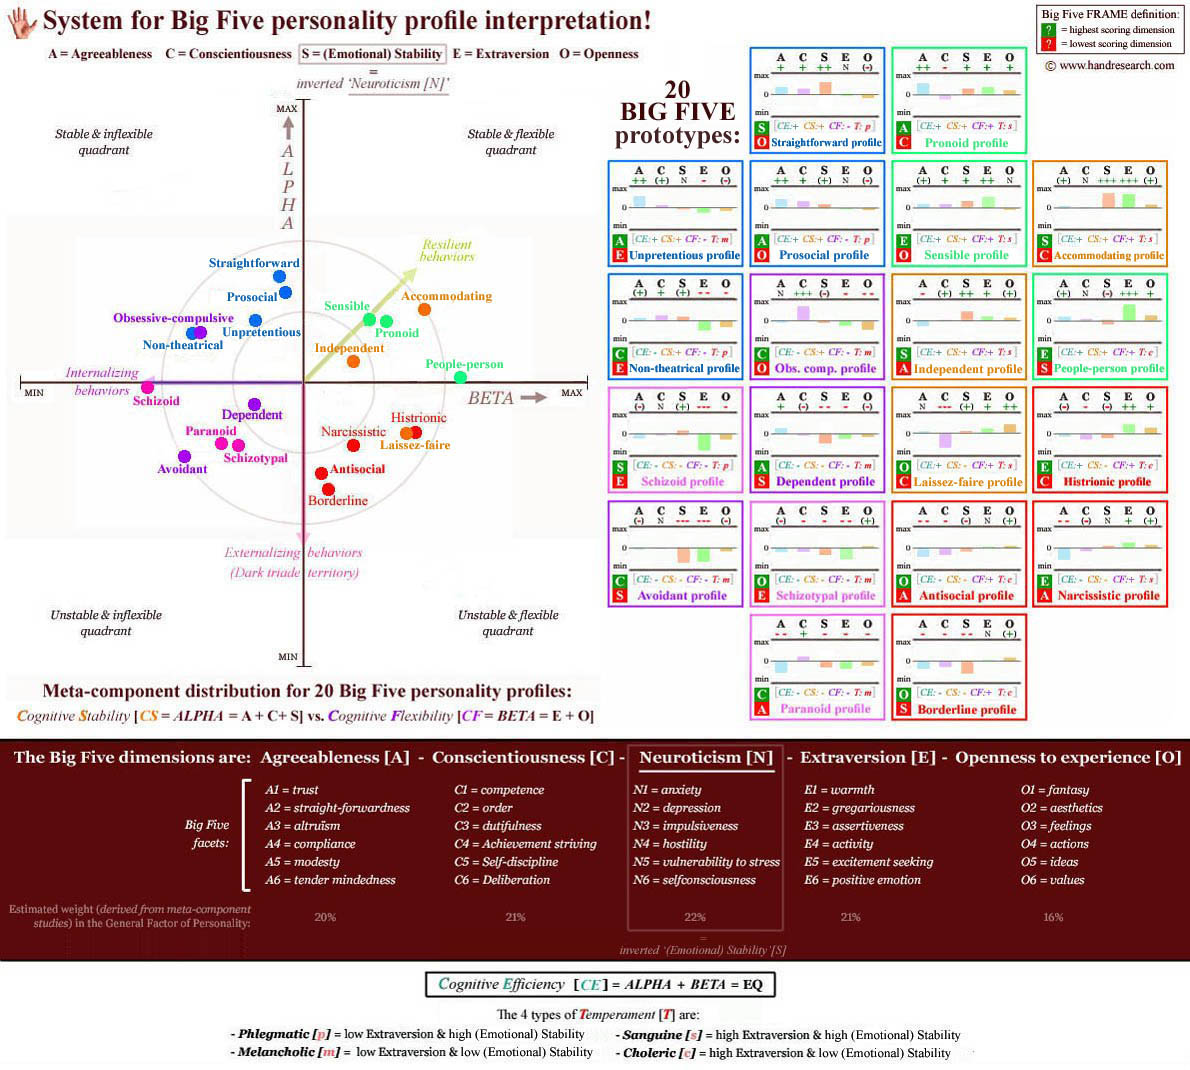

In [17]:
Image(r'C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/dataset/20-profiles.jpg')

:Scatter   [Beta]   (Alpha,Label)
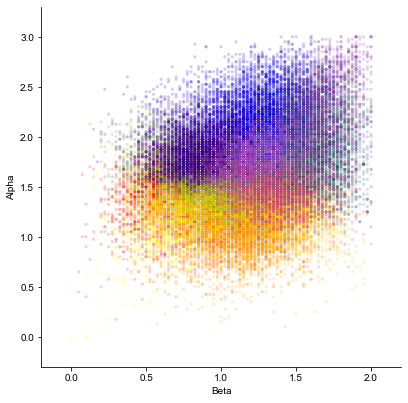

In [18]:
img =hv.Scatter(
    data=df_all_infromation_subset, kdims = ["Beta"], vdims = ["Alpha", "Label"]
).opts(color='Label', 
       cmap=LABEL_COLORS_HEX, 
       s=10, 
       alpha=0.2,
       marker = 'o')

img.opts(aspect=1, fig_inches=5, fig_bounds=(0, 0, 1, 1))

hv.save(img, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/eval_original.png", fmt="png")

img

:Layout
   .Overlay.I     :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.II    :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.III   :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.IV    :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.V     :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VI    :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VII   :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VIII  :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.IX    :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.X     :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XI    :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XII   :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIII  :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIV   :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XV    :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVI   :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVII  :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVIII :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIX   :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XX    :Overlay
      .Scatter.I  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II :Scatter   [Beta]   (Alpha,Label)
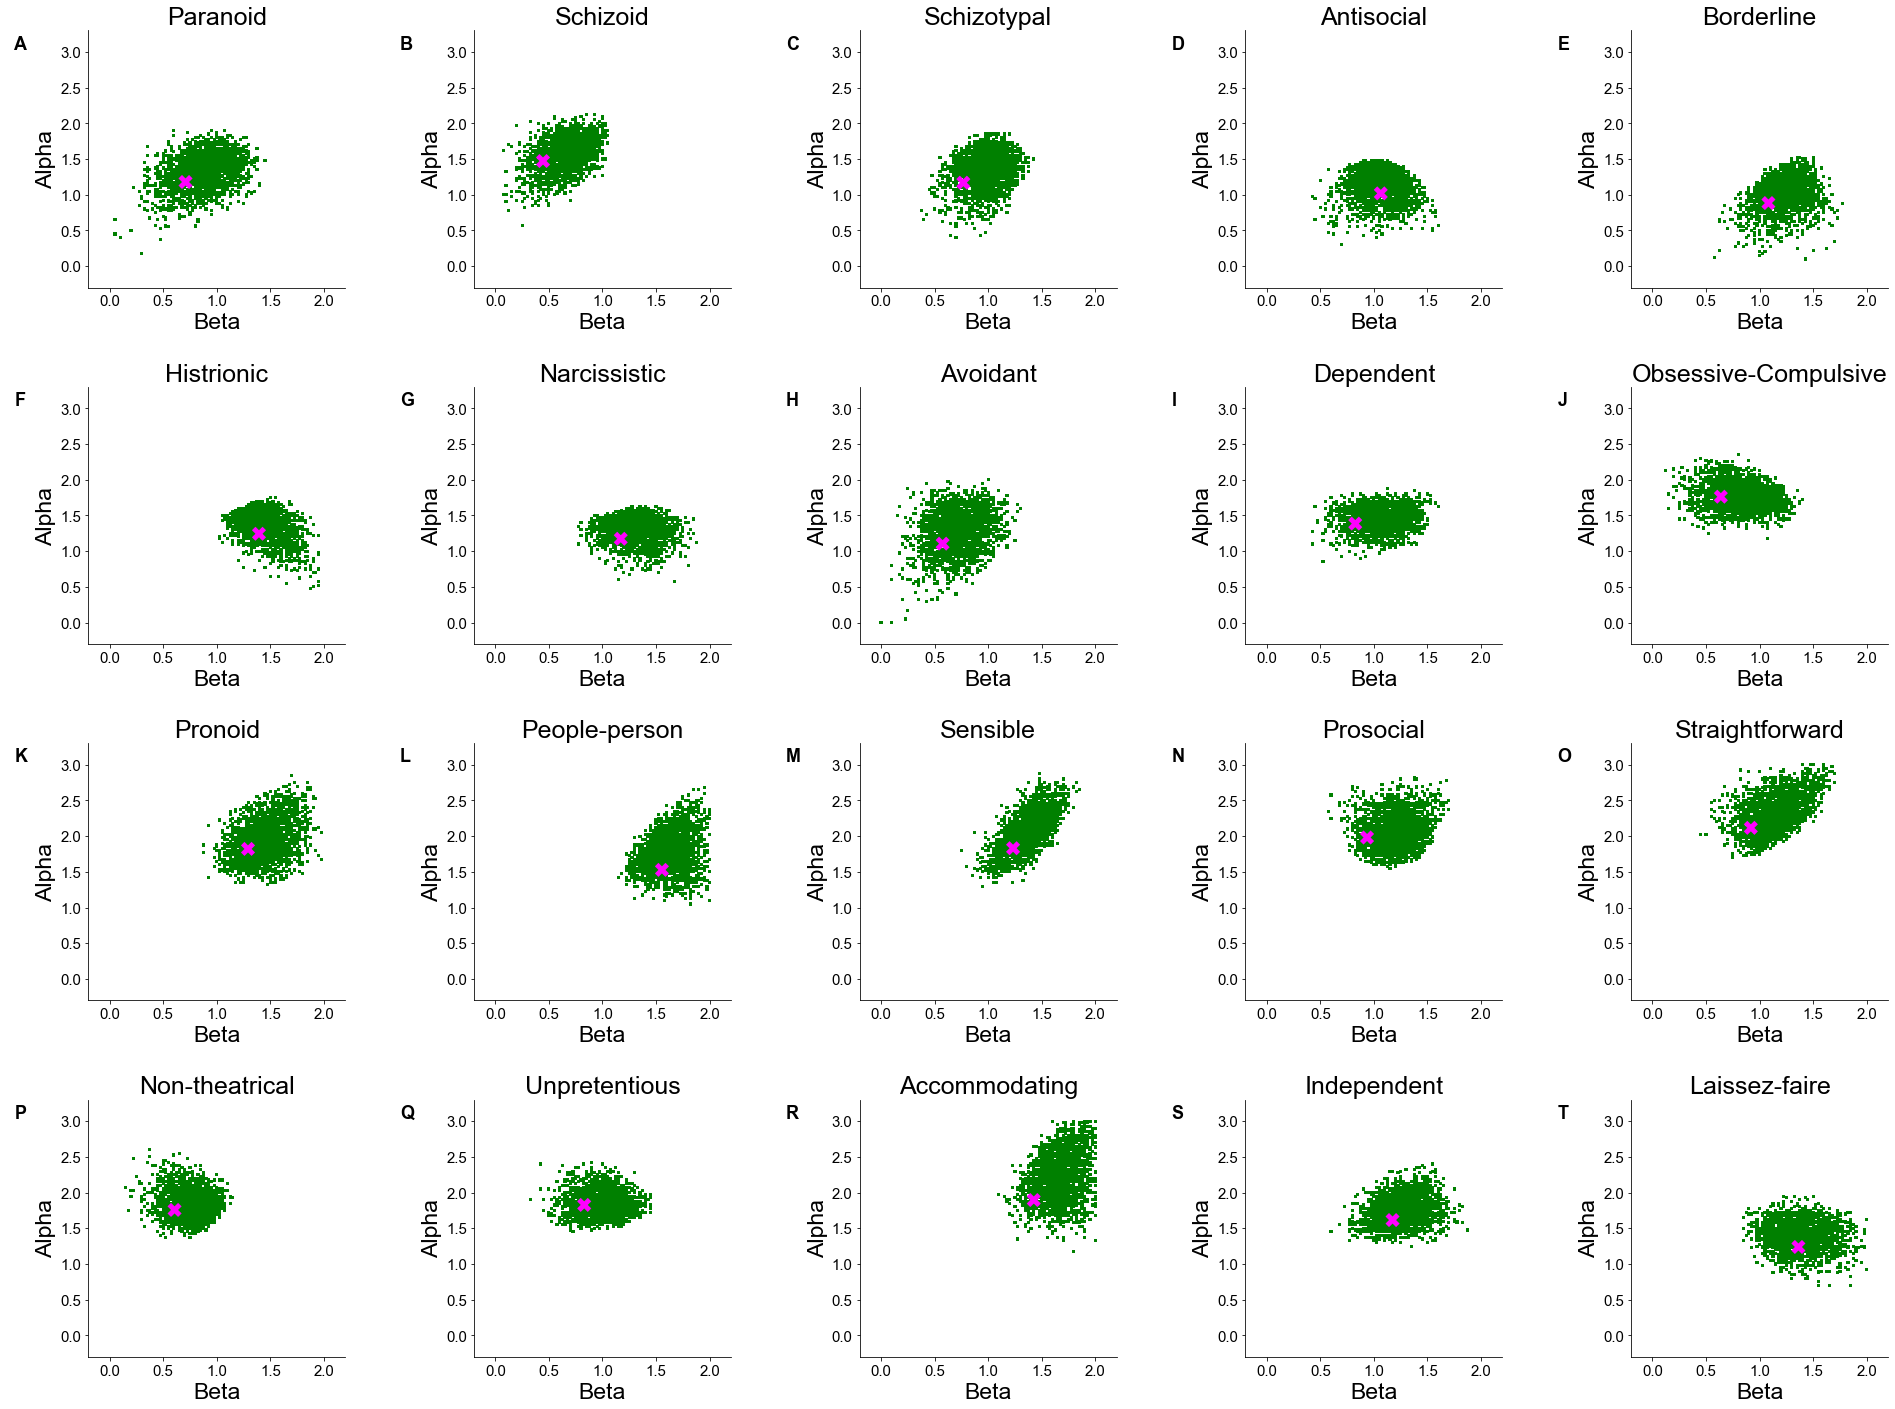

In [19]:
original_eval_imgs = [hv.Scatter(
        data=df_all_infromation_subset[df_all_infromation_subset.Label == label_idx], kdims = ["Beta"], vdims = ["Alpha", "Label"]).opts(
        color='Label', 
        cmap=[LABEL_COLORS_HEX[10]], 
        s=10, 
        alpha=1.0,
        marker=',',
        title=LABEL_NAMES[label_idx],
        fontsize={'title': 25, 
                  'labels': 23, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

profile_eval_imgs =  [hv.Scatter(
        data=DF_PROFILES[DF_PROFILES.Label == label_idx], kdims = ["Beta"], vdims = ["Alpha", "Label"]).opts(
        color='Label', 
        cmap=build_custom_continuous_cmap([255, 0, 255], [255, 0, 255]), 
        s=200, 
        alpha=1.0,
        marker='X',
        title=LABEL_NAMES[label_idx],
        fontsize={'title': 25, 
                  'labels': 23, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]


output_layout = (original_eval_imgs[0] * profile_eval_imgs[0])

for idx in range(1, 20):
    output_layout += (original_eval_imgs[idx] * profile_eval_imgs[idx])

output_layout.opts(fig_inches=5, fig_bounds=(0, 0, 1, 1)).cols(5)


hv.save(output_layout, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/eval_seperated_0riginal.png", fmt="png")

output_layout

In [20]:
LABEL_COLORS_HEX_SHIF = LABEL_COLORS_HEX.copy()

for x in range(0, 20):
    LABEL_COLORS_HEX_SHIF[x] = LABEL_COLORS_HEX[(x + 13) % 20]
    

:Overlay
   .Scatter.I     :Scatter   [Beta]   (Alpha,Label)
   .Labels.I      :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.II    :Scatter   [Beta]   (Alpha,Label)
   .Labels.II     :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.III   :Scatter   [Beta]   (Alpha,Label)
   .Labels.III    :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.IV    :Scatter   [Beta]   (Alpha,Label)
   .Labels.IV     :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.V     :Scatter   [Beta]   (Alpha,Label)
   .Labels.V      :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.VI    :Scatter   [Beta]   (Alpha,Label)
   .Labels.VI     :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.VII   :Scatter   [Beta]   (Alpha,Label)
   .Labels.VII    :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.VIII  :Scatter   [Beta]   (Alpha,Label)
   .Labels.VIII   :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.IX    :Scatter   [Beta]   (Alpha,Label)
   .Labels.IX     :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.X     :Scatter   [Beta]   (Alpha,Label)
   .Labels.X      :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.XI    :Scatter   [Beta]   (Alpha,Label)
   .Labels.XI     :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.XII   :Scatter   [Beta]   (Alpha,Label)
   .Labels.XII    :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.XIII  :Scatter   [Beta]   (Alpha,Label)
   .Labels.XIII   :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.XIV   :Scatter   [Beta]   (Alpha,Label)
   .Labels.XIV    :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.XV    :Scatter   [Beta]   (Alpha,Label)
   .Labels.XV     :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.XVI   :Scatter   [Beta]   (Alpha,Label)
   .Labels.XVI    :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.XVII  :Scatter   [Beta]   (Alpha,Label)
   .Labels.XVII   :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.XVIII :Scatter   [Beta]   (Alpha,Label)
   .Labels.XVIII  :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.XIX   :Scatter   [Beta]   (Alpha,Label)
   .Labels.XIX    :Labels   [Beta,Alpha]   (Label_text)
   .Scatter.XX    :Scatter   [Beta]   (Alpha,Label)
   .Labels.XX     :Labels   [Beta,Alpha]   (Label_text)
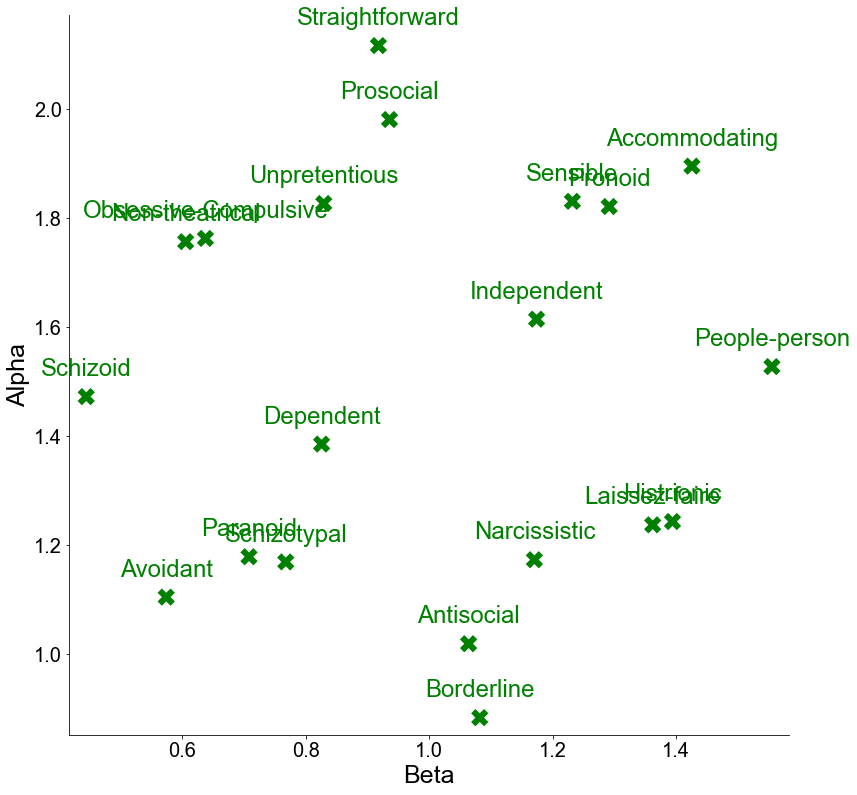

In [21]:
profile_eval_imgs =  [hv.Scatter(
        data=DF_PROFILES[DF_PROFILES.Label == label_idx], kdims = ["Beta"], vdims = ["Alpha", "Label"]).opts(
        color='Label', 
        cmap=[LABEL_COLORS_HEX[10]], 
        s=300, 
        alpha=1.0,
        marker='X',
        fontsize={'title': 25, 
                  'labels': 25, 
                  'xticks': 20, 
                  'yticks': 20}) for label_idx in range(0, 20)]

label_eval_imgs = [hv.Labels(DF_PROFILES[DF_PROFILES.Label == label_idx], ["Beta", "Alpha"], ["Label_text"]).opts(cmap=[LABEL_COLORS_HEX[10]]) for label_idx in range(0, 20)]

output_layout = (profile_eval_imgs[0] * label_eval_imgs[0])
for idx in range(1, 20):
    output_layout *= profile_eval_imgs[idx] * label_eval_imgs[idx]

output_layout.opts(opts.Labels(color="Label_text", cmap=build_custom_continuous_cmap(LABEL_COLORS_RGP[10], LABEL_COLORS_RGP[10]), xoffset=0.0, yoffset=0.025, size=24, padding=0.025))
output_layout.opts(fig_inches=10, fig_bounds=(0, 0, 1, 1))


hv.save(output_layout, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/label_explained.png", fmt="png")

output_layout

## LDA

In [22]:
lda = LinearDiscriminantAnalysis(solver='eigen', 
                                 shrinkage="auto", 
                                 priors=None, 
                                 n_components=2, 
                                 store_covariance=False, 
                                 tol=0.0000001, 
                                 covariance_estimator=None)

responses_lda = lda.fit_transform(X=np_RESPONSES, y=np_LABEL)

np_lda = np.concatenate((responses_lda, np.reshape(np_LABEL, (np_LABEL.shape[0], 1))), axis = 1)

df_lda = pd.DataFrame(np_lda, columns= ["X", "Y", "Label"])

:Scatter   [X]   (Y,Label)
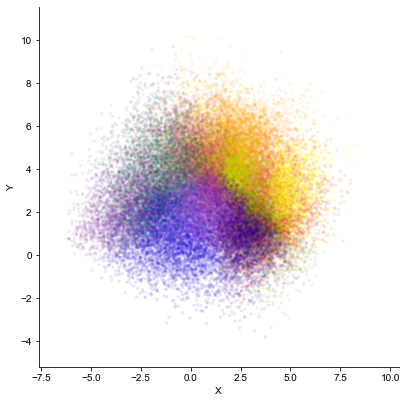

In [23]:
img = hv.Scatter(
    data=df_lda, kdims = ["X"], vdims = ["Y", "Label"]
).opts(color='Label', 
       cmap=LABEL_COLORS_HEX, 
       s=10, 
       alpha=0.1,
       marker = 'o')

img.opts(aspect=1, fig_inches=5, fig_bounds=(0, 0, 1, 1))

hv.save(img, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/responses_original.png", fmt="png")

img

:Layout
   .Scatter.I     :Scatter   [X]   (Y,Label)
   .Scatter.II    :Scatter   [X]   (Y,Label)
   .Scatter.III   :Scatter   [X]   (Y,Label)
   .Scatter.IV    :Scatter   [X]   (Y,Label)
   .Scatter.V     :Scatter   [X]   (Y,Label)
   .Scatter.VI    :Scatter   [X]   (Y,Label)
   .Scatter.VII   :Scatter   [X]   (Y,Label)
   .Scatter.VIII  :Scatter   [X]   (Y,Label)
   .Scatter.IX    :Scatter   [X]   (Y,Label)
   .Scatter.X     :Scatter   [X]   (Y,Label)
   .Scatter.XI    :Scatter   [X]   (Y,Label)
   .Scatter.XII   :Scatter   [X]   (Y,Label)
   .Scatter.XIII  :Scatter   [X]   (Y,Label)
   .Scatter.XIV   :Scatter   [X]   (Y,Label)
   .Scatter.XV    :Scatter   [X]   (Y,Label)
   .Scatter.XVI   :Scatter   [X]   (Y,Label)
   .Scatter.XVII  :Scatter   [X]   (Y,Label)
   .Scatter.XVIII :Scatter   [X]   (Y,Label)
   .Scatter.XIX   :Scatter   [X]   (Y,Label)
   .Scatter.XX    :Scatter   [X]   (Y,Label)
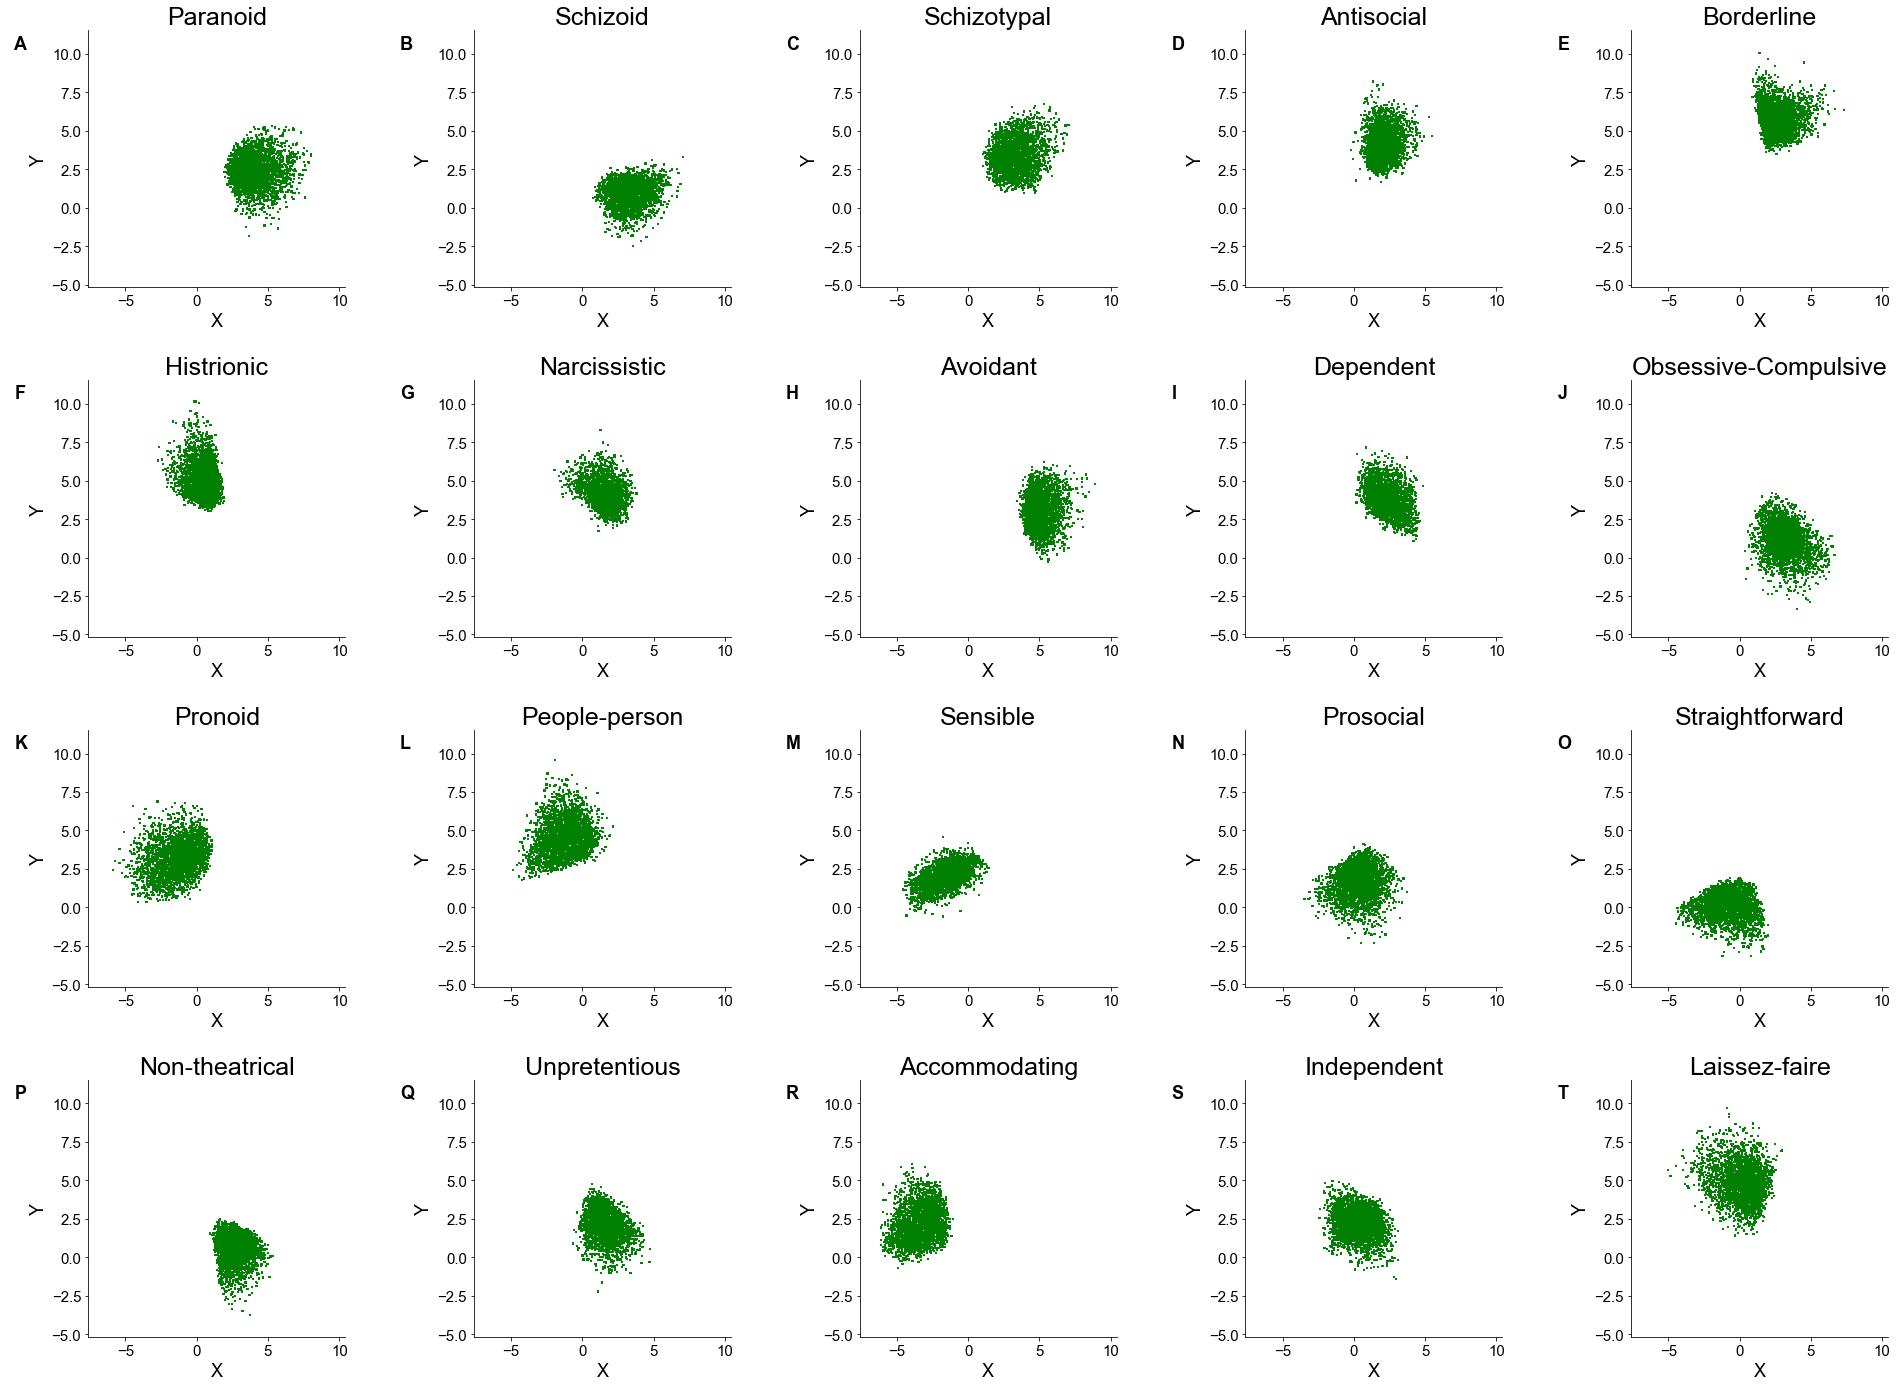

In [24]:
image_data = hv.Layout([hv.Scatter(
        data=df_lda[df_lda.Label == label_idx], kdims = ["X"], vdims = ["Y", "Label"]).opts(
        color='Label', 
        cmap=[LABEL_COLORS_HEX[10]], 
        s=5, 
        alpha=1.0,
        marker=',',
        title=LABEL_NAMES[label_idx],fontsize={'title': 25, 
                  'labels': 18, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]).cols(5)

image_data.opts(fig_inches=5, fig_bounds=(0, 0, 1, 1))

hv.save(image_data, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/responses_seperated_0riginal.png", fmt="png")

image_data

## Inter-rater reliability (against response)

In [25]:
irr_original = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_all_infromation_subset[df_all_infromation_subset.Label == label_idx]
    np_label_subset = df_label_subset.iloc[:, 0:50].to_numpy()

    irr = CalcInterRaterReliability(np_label_subset)
    irr_original[label_idx] = irr
    print(f"{LABEL_NAMES[label_idx]}: {irr}")

Paranoid: 0.29271648020586527
Schizoid: 0.31211037014953474
Schizotypal: 0.29650843074798766
Antisocial: 0.26189278686981216
Borderline: 0.30301491581804774
Histrionic: 0.2928562363684863
Narcissistic: 0.27557953272347835
Avoidant: 0.3492225384820574
Dependent: 0.2962222466303683
Obsessive-Compulsive: 0.3060907627371295
Pronoid: 0.3162006244998509
People-person: 0.3236263545213475
Sensible: 0.310379451130533
Prosocial: 0.3024577991872087
Straightforward: 0.32912861872558097
Non-theatrical: 0.3003308782225291
Unpretentious: 0.3044369992625253
Accommodating: 0.37569065603866253
Independent: 0.2850374417473443
Laissez-faire: 0.31114894792173353


## Root Mean Squared Prediction Error (againstg Personality Facttors)

In [26]:
rmspe_facttors_original = np.zeros((20, 5))

for label_idx in range(0, 20):
    df_label_subset = df_all_infromation_subset[df_all_infromation_subset.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])

    rmspe = RootMeanSquaredError(np_array = np_ocean_subset, np_predictor = OCEAN_estimate)
    rmspe_facttors_original[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")

Paranoid: [0.3130285  0.19371939 0.15462747 0.10718717 0.14718485]
Schizoid: [0.26635568 0.15108948 0.0758392  0.15017387 0.17327798]
Schizotypal: [0.26075069 0.1726315  0.103469   0.15858812 0.13906502]
Antisocial: [0.19426538 0.10126697 0.13170155 0.13051935 0.11500082]
Borderline: [0.2459897  0.17059297 0.11723823 0.18161473 0.10031845]
Histrionic: [0.19180052 0.13994932 0.14716022 0.15517649 0.13819735]
Narcissistic: [0.25867494 0.20037779 0.15128656 0.10748249 0.11292139]
Avoidant: [0.2530869  0.20118567 0.09383951 0.18840627 0.08478073]
Dependent: [0.27371846 0.14745791 0.12728884 0.14112336 0.11472606]
Obsessive-Compulsive: [0.27601839 0.08550764 0.15503239 0.13808547 0.15709873]
Pronoid: [0.21310299 0.19031566 0.13878989 0.10702253 0.16115497]
People-person: [0.20898032 0.20009976 0.14775029 0.22589451 0.16460097]
Sensible: [0.19332738 0.18611625 0.08917916 0.1749304  0.09806009]
Prosocial: [0.28863324 0.13803214 0.13018931 0.12680027 0.14163406]
Straightforward: [0.30684311 0.

## RMSE of Euclidean Distance (against Personality)

In [27]:
rmspe_distance_original = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_all_infromation_subset[df_all_infromation_subset.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])

    # Get the distance between the labeld point and the instance
    np_distance_subset = np.zeros((np_ocean_subset.shape[0], 1))
    for idx in range(np_ocean_subset.shape[0]):
        np_distance_subset[idx] = np.linalg.norm(np_ocean_subset[idx] - OCEAN_estimate)

    # Calc the avgerage prediction distance
    np_avg_distance = np.mean(np_distance_subset)
    
    rmspe = RootMeanSquaredError(np_array = np_distance_subset, np_predictor = np_avg_distance)
    rmspe_distance_original[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")   

C:\Users\38977332\AppData\Local\Temp\ipykernel_15448\909943468.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmspe_distance_original[label_idx] = rmspe


Paranoid: [0.15022779]
Schizoid: [0.13682412]
Schizotypal: [0.12026157]
Antisocial: [0.10042153]
Borderline: [0.11236582]
Histrionic: [0.09889835]
Narcissistic: [0.12196393]
Avoidant: [0.14005827]
Dependent: [0.12588075]
Obsessive-Compulsive: [0.10829842]
Pronoid: [0.10932626]
People-person: [0.11699743]
Sensible: [0.11698957]
Prosocial: [0.12631744]
Straightforward: [0.13701598]
Non-theatrical: [0.12239628]
Unpretentious: [0.12272594]
Accommodating: [0.13804956]
Independent: [0.12503459]
Laissez-faire: [0.10454631]


## RMSE Cosine Similarity (against Personality)

In [28]:
rmspe_cos_original = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_all_infromation_subset[df_all_infromation_subset.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])
    
    # Calculate the Cosine Similarity for each personality result
    np_cos_similarity = np.zeros((np_ocean_subset.shape[0], 1))
    for idx in range(np_ocean_subset.shape[0]): 
        dot_product = np.dot(np_ocean_subset[idx], OCEAN_estimate)
        norm_instant = np.linalg.norm(np_ocean_subset[idx])
        norm_predict = np.linalg.norm(OCEAN_estimate)
        np_cos_similarity[idx] = dot_product/(norm_instant*norm_predict)

    # Calculate the Avg Cosine Similarity
    avg_cos_similarity = np.mean(np_cos_similarity)

    rmspe = RootMeanSquaredError(np_array = np_cos_similarity, np_predictor = avg_cos_similarity)
    rmspe_cos_original[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")   

C:\Users\38977332\AppData\Local\Temp\ipykernel_15448\2384751682.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmspe_cos_original[label_idx] = rmspe


Paranoid: [0.03716438]
Schizoid: [0.05564541]
Schizotypal: [0.0263836]
Antisocial: [0.03055248]
Borderline: [0.01620069]
Histrionic: [0.01245849]
Narcissistic: [0.02494238]
Avoidant: [0.01899462]
Dependent: [0.0134393]
Obsessive-Compulsive: [0.01799513]
Pronoid: [0.01375806]
People-person: [0.01172313]
Sensible: [0.00944862]
Prosocial: [0.01741556]
Straightforward: [0.02799902]
Non-theatrical: [0.02725423]
Unpretentious: [0.01837838]
Accommodating: [0.01352873]
Independent: [0.03525347]
Laissez-faire: [0.02477241]


--------------------

# Compairing with LLMs

## Clean Data Sheets

## GPT-3  Turbo

In [29]:
np_turbo_response = np.zeros((2560,50), dtype=int)
r_idx = 0
for label_idx in range(20):
    df = pd.read_csv(f'C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/original_128/model_gpt-3.5-turbo_128/post/{LABEL_NAMES[label_idx]}.csv')
    df_T = df.transpose(copy=True)

    factors_id = 0
    for index, row in df_T.iterrows():
        question_idx = 0
        for row_element in row:
            if factors_id < 5:
                factors_id += 1
                continue
            
            factors_id += 1
            factor_list = row_element.split(';')
            for response_idx in range(10):
                response = factor_list[response_idx][-1]
                np_turbo_response[r_idx, question_idx] = int(response)
                question_idx += 1
        if factors_id > 5:
            r_idx += 1
                    
print(np_turbo_response)

[[3 4 2 ... 2 4 3]
 [2 3 2 ... 2 3 3]
 [2 3 2 ... 2 3 4]
 ...
 [4 2 4 ... 3 4 4]
 [4 3 4 ... 1 3 5]
 [4 2 4 ... 3 3 4]]


In [30]:
np_turbo_OCEAN = EvaluateOceanTestResults(np_turbo_response)
np_turbo_OCEAN

array([[0.65 , 0.8  , 0.3  , 0.45 , 0.65 ],
       [0.5  , 0.75 , 0.35 , 0.75 , 0.65 ],
       [0.625, 0.725, 0.475, 0.675, 0.725],
       ...,
       [0.7  , 0.725, 0.75 , 0.675, 0.525],
       [0.7  , 0.625, 0.725, 0.75 , 0.525],
       [0.7  , 0.625, 0.725, 0.7  , 0.525]])

In [31]:
np_turbo_CSCF = calc_CSCF(np_turbo_OCEAN)
np_turbo_CSCF


array([[1.6  , 0.95 ],
       [1.85 , 0.85 ],
       [1.675, 1.1  ],
       ...,
       [1.875, 1.45 ],
       [1.85 , 1.425],
       [1.8  , 1.425]])

In [32]:
np_llm_label = np.repeat(np.arange(20),128)

In [33]:
compare_array = np_llm_label == GetPersonalityProfileLabels(np_turbo_OCEAN)
turbo_accuracy = sum(compare_array)/compare_array.shape[0]
turbo_error = (compare_array.shape[0] - sum(compare_array))/compare_array.shape[0]

conf_const = [1.64, 1.96, 2.33, 2.58]
confidence_interval_turbo = [0.0, 0.0, 0.0, 0.0]
confidence_interval_turbo[0] = conf_const[0] * np.sqrt( (turbo_error * (1.0 - turbo_error)) / compare_array.shape[0])
confidence_interval_turbo[1] = conf_const[1] * np.sqrt( (turbo_error * (1.0 - turbo_error)) / compare_array.shape[0])
confidence_interval_turbo[2] = conf_const[2] * np.sqrt( (turbo_error * (1.0 - turbo_error)) / compare_array.shape[0])
confidence_interval_turbo[3] = conf_const[3] * np.sqrt( (turbo_error * (1.0 - turbo_error)) / compare_array.shape[0])

print(f"Turbo accuracy: {turbo_accuracy * 100.0}%, Turbo error: {turbo_error * 100.0}")
print(f"The true classification error of the model is likely between {turbo_error - confidence_interval_turbo[0]} and {turbo_error + confidence_interval_turbo[0]} at the 90% confidence interval")
print(f"The true classification error of the model is likely between {turbo_error - confidence_interval_turbo[1]} and {turbo_error + confidence_interval_turbo[1]} at the 95% confidence interval")
print(f"The true classification error of the model is likely between {turbo_error - confidence_interval_turbo[2]} and {turbo_error + confidence_interval_turbo[2]} at the 98% confidence interval")
print(f"The true classification error of the model is likely between {turbo_error - confidence_interval_turbo[3]} and {turbo_error + confidence_interval_turbo[3]} at the 99% confidence interval")
print(f"{turbo_error} +/- {confidence_interval_turbo[1]}")


Turbo accuracy: 17.7734375%, Turbo error: 82.2265625
The true classification error of the model is likely between 0.8098743598978255 and 0.8346568901021745 at the 90% confidence interval
The true classification error of the model is likely between 0.807456552073011 and 0.837074697926989 at the 95% confidence interval
The true classification error of the model is likely between 0.8046609617755692 and 0.8398702882244308 at the 98% confidence interval
The true classification error of the model is likely between 0.8027720494124329 and 0.8417592005875671 at the 99% confidence interval
0.822265625 +/- 0.014809072926989004


In [34]:
compare_array.shape

(2560,)

In [35]:
df_turbo_all_infromation = CreateFullInfoDf(np_turbo_response, np_turbo_OCEAN, np_turbo_CSCF, np_llm_label)
df_turbo_all_infromation.describe()

E1           E2           E3           E4           E5  \
count  2560.000000  2560.000000  2560.000000  2560.000000  2560.000000   
mean      3.360937     2.397266     3.426953     2.297656     3.242969   
std       0.992054     0.809040     1.216395     0.769989     1.265293   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       2.000000     2.000000     2.000000     2.000000     2.000000   
50%       4.000000     2.000000     4.000000     2.000000     3.000000   
75%       4.000000     3.000000     4.000000     3.000000     4.000000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

                E6           E7           E8           E9          E10  ...  \
count  2560.000000  2560.000000  2560.000000  2560.000000  2560.000000  ...   
mean      2.384375     3.457422     2.717578     3.104297     2.840625  ...   
std       0.810679     1.369768     0.953144     1.059237     0.962967  ...   
min       1.000000     1.000000     1.000000     1.000000     1.000000  ...   
25%       2.000000     2.000000     2.000000     2.000000     2.000000  ...   
50%       2.000000     4.000000     3.000000     3.000000     3.000000  ...   
75%       3.000000     5.000000     3.000000     4.000000     4.000000  ...   
max       5.000000     5.000000     5.000000     5.000000     5.000000  ...   

                O9          O10     Openness  Conscientiousness  Extraversion  \
count  2560.000000  2560.000000  2560.000000        2560.000000   2560.000000   
mean      3.217969     4.161719     0.657744           0.692773      0.598877   
std       0.724811     0.605772     0.085016           0.064686      0.188109   
min       1.000000     1.000000     0.325000           0.200000      0.075000   
25%       3.000000     4.000000     0.600000           0.650000      0.425000   
50%       3.000000     4.000000     0.675000           0.700000      0.650000   
75%       4.000000     5.000000     0.725000           0.725000      0.750000   
max       5.000000     5.000000     0.850000           0.900000      0.975000   

       Agreeableness  Neuroticism        Alpha         Beta        Label  
count    2560.000000  2560.000000  2560.000000  2560.000000  2560.000000  
mean        0.722813     0.561562     1.854023     1.256621     9.500000  
std         0.077532     0.138700     0.212807     0.254410     5.767408  
min         0.425000     0.100000     1.150000     0.500000     0.000000  
25%         0.675000     0.475000     1.725000     1.050000     4.750000  
50%         0.725000     0.575000     1.850000     1.325000     9.500000  
75%         0.775000     0.650000     2.000000     1.475000    14.250000  
max         0.950000     0.975000     2.575000     1.750000    19.000000  

[8 rows x 58 columns]

In [36]:
df_turbo_all_infromation.to_csv('C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/PersonalityTestTurbo.csv', index=False)

### Visualize Synthetic data

:Scatter   [Beta]   (Alpha,Label)
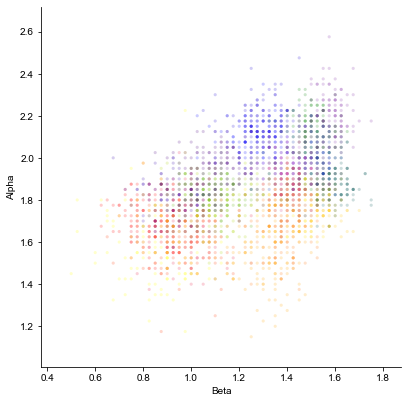

In [37]:
img =hv.Scatter(
    data=df_turbo_all_infromation, kdims = ["Beta"], vdims = ["Alpha", "Label"]
).opts(color='Label', 
       cmap=LABEL_COLORS_HEX, 
       s=10, 
       alpha=0.2,
       marker = 'o')

img.opts(aspect=1, fig_inches=5, fig_bounds=(0, 0, 1, 1))

In [38]:
turbo_eval_imgs = [hv.Scatter(data=df_turbo_all_infromation[df_turbo_all_infromation.Label == label_idx], kdims = ["Beta"], vdims = ["Alpha", "Label"]
                       ).opts(color='Label',
                              cmap=[LABEL_COLORS_HEX[8]],
                              s=50,
                              alpha=1.0,
                              title=f"eval-turbo: {LABEL_NAMES[label_idx]}",
                              marker='o',
                              fontsize={'title': 25, 
                  'labels': 23, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

original_eval_imgs =  [hv.Scatter(data=df_all_infromation_subset[df_all_infromation_subset.Label == label_idx], kdims = ["Beta"], vdims = ["Alpha", "Label"]
                             ).opts(color='Label', 
                                    cmap=[LABEL_COLORS_HEX[10]], 
                                    s=10, 
                                    alpha=1.0,
                                    #title=f"eval-turbo: {LABEL_NAMES[label_idx]}",
                                    marker=',',
                                    fontsize={'title': 25, 
                  'labels': 23, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

:Layout
   .Overlay.I     :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.II    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.III   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.IV    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.V     :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VI    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VII   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VIII  :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.IX    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.X     :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XI    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XII   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIII  :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIV   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XV    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVI   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVII  :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVIII :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIX   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XX    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
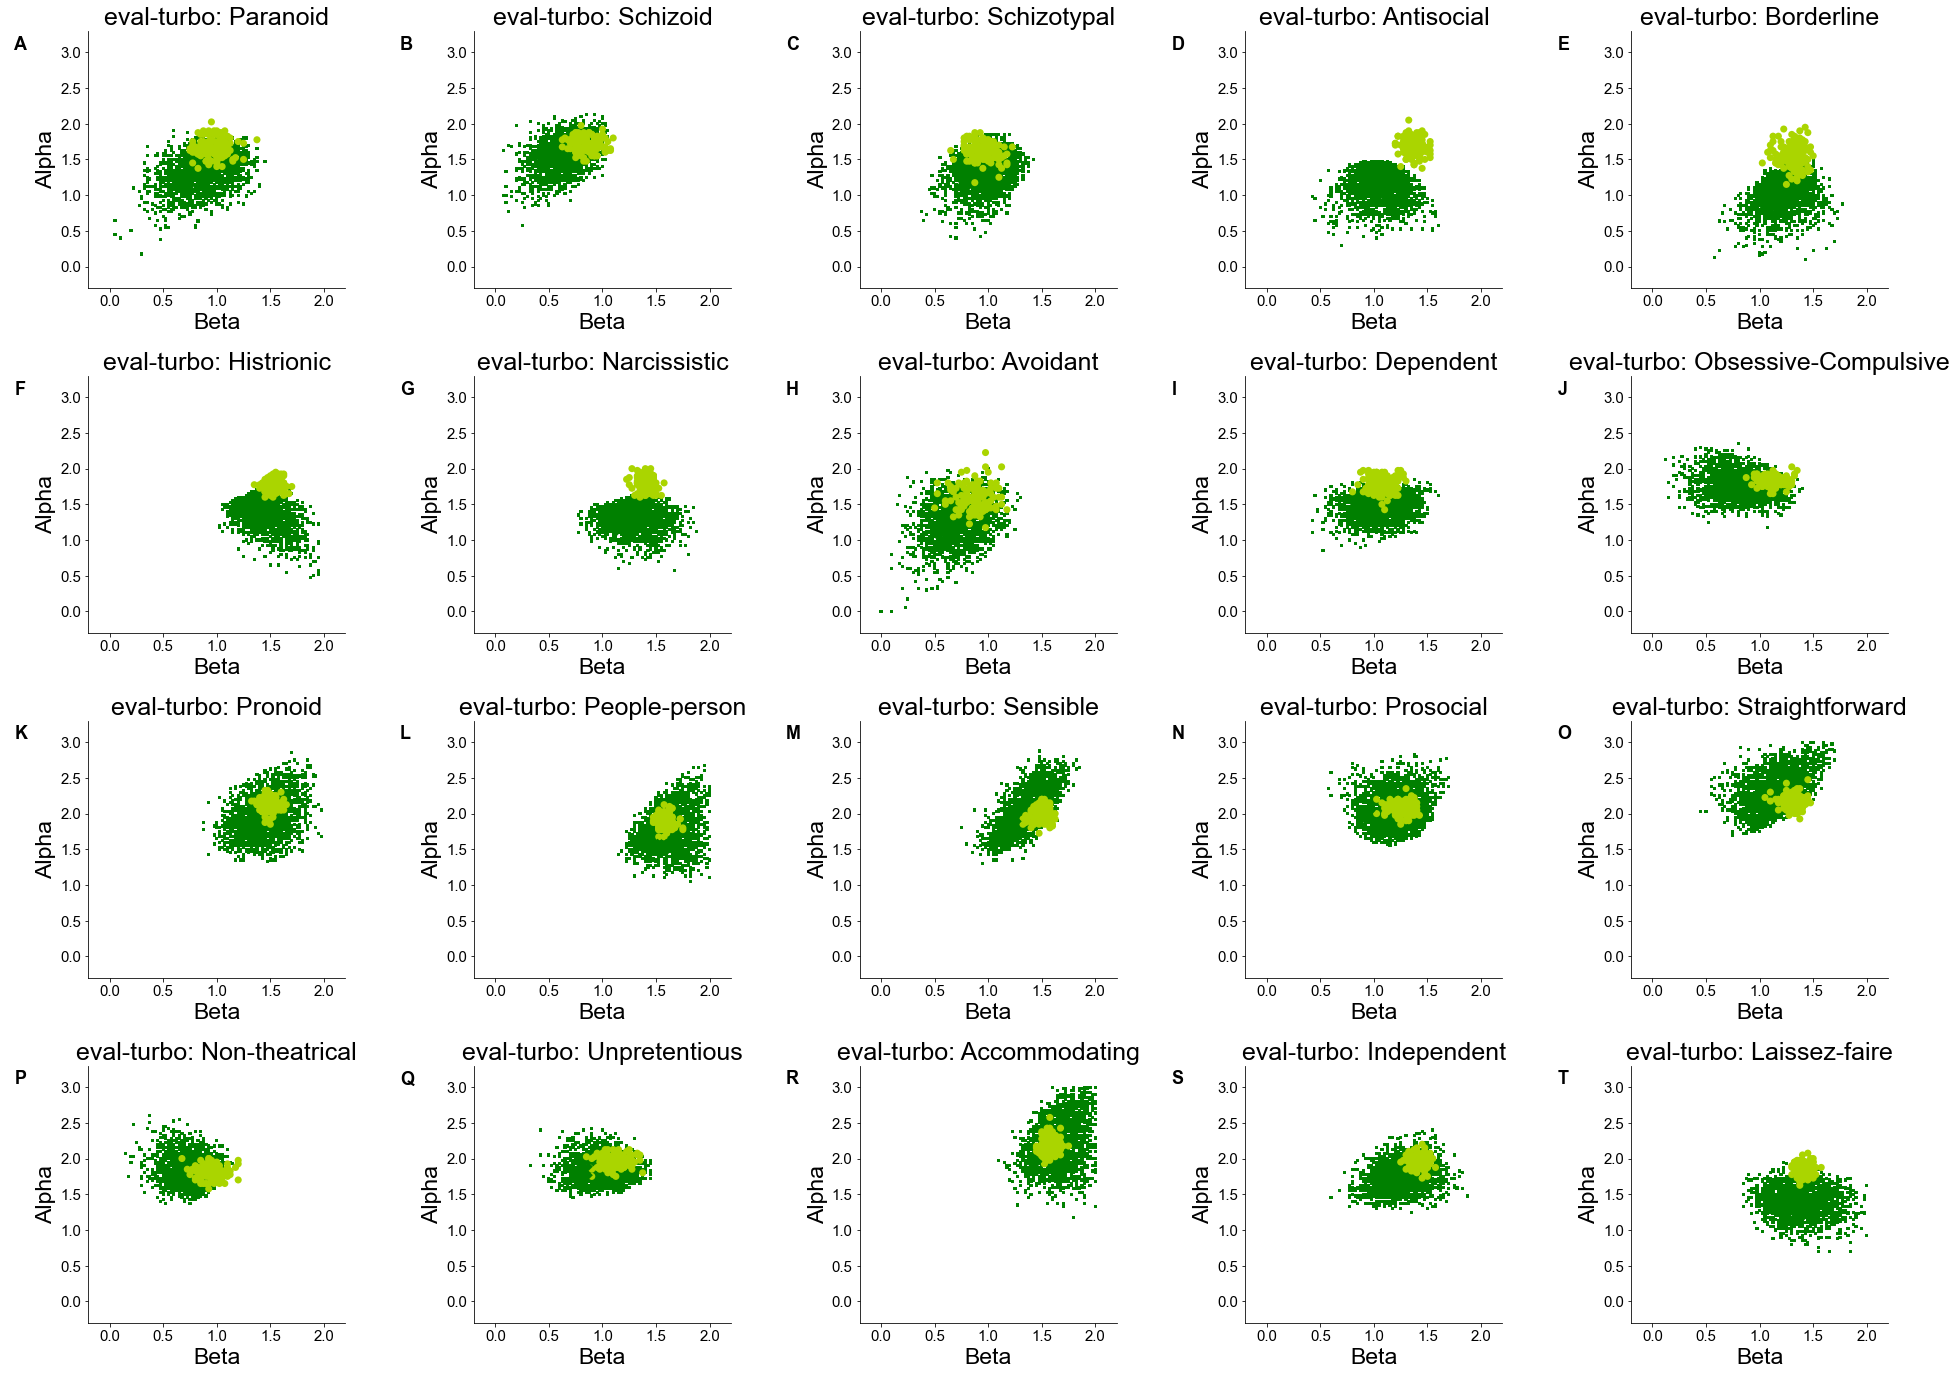

In [39]:
output_layout = (original_eval_imgs[0] * turbo_eval_imgs[0] * profile_eval_imgs[0])

for idx in range(1, 20):
    output_layout += (original_eval_imgs[idx] * turbo_eval_imgs[idx] * profile_eval_imgs[idx])

output_layout.opts(fig_inches=5, fig_bounds=(0, 0, 1, 1)).cols(5)

hv.save(output_layout, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/eval_seperated_turbo.png", fmt="png")

output_layout

### LDA

In [40]:
turbo_responses_lda = lda.transform(np_turbo_response)

np_turbo_lda = np.concatenate((turbo_responses_lda, np.reshape(np_llm_label, (np_llm_label.shape[0], 1))), axis = 1)

df_turbo_lda = pd.DataFrame(np_turbo_lda, columns= ["X", "Y", "Label"])

:Scatter   [X]   (Y,Label)
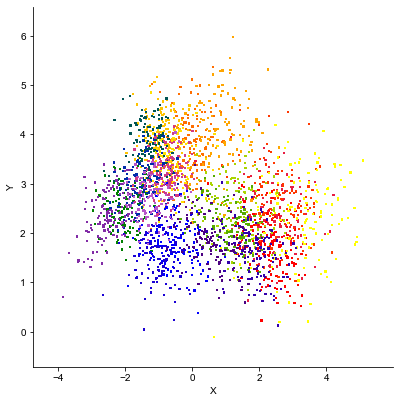

In [41]:
img = hv.Scatter(
    data=df_turbo_lda, kdims = ["X"], vdims = ["Y", "Label"]
).opts(color='Label', 
       cmap=LABEL_COLORS_HEX, 
       s=5, 
       alpha=1.0,
       marker = ',')

img.opts(aspect=1, fig_inches=5, fig_bounds=(0, 0, 1, 1))

In [42]:
turbo_lda_imgs = [hv.Scatter(data=df_turbo_lda[df_turbo_lda.Label == label_idx], kdims = ["X"], vdims = ["Y", "Label"]
                       ).opts(color='Label',
                              cmap=[LABEL_COLORS_HEX[(8) % 20]],
                              s=50,
                              alpha=1.0,
                              title=f"resp-turbo: {LABEL_NAMES[label_idx]}",
                              marker='o',
                              fontsize={'title': 25, 
                  'labels': 18, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

original_lda_imgs =  [hv.Scatter(data=df_lda[df_lda.Label == label_idx], kdims = ["X"], vdims = ["Y", "Label"]
                             ).opts(color='Label', 
                                    cmap=[LABEL_COLORS_HEX[10]], 
                                    s=5, 
                                    alpha=1.0,
                                    #title=f"resp-turbo: {LABEL_NAMES[label_idx]}",
                                    marker=',',
                                    fontsize={'title': 25, 
                  'labels': 18, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

:Layout
   .Overlay.I     :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.II    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.III   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.IV    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.V     :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VI    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VII   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VIII  :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.IX    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.X     :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XI    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XII   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XIII  :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XIV   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XV    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XVI   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XVII  :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XVIII :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XIX   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XX    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
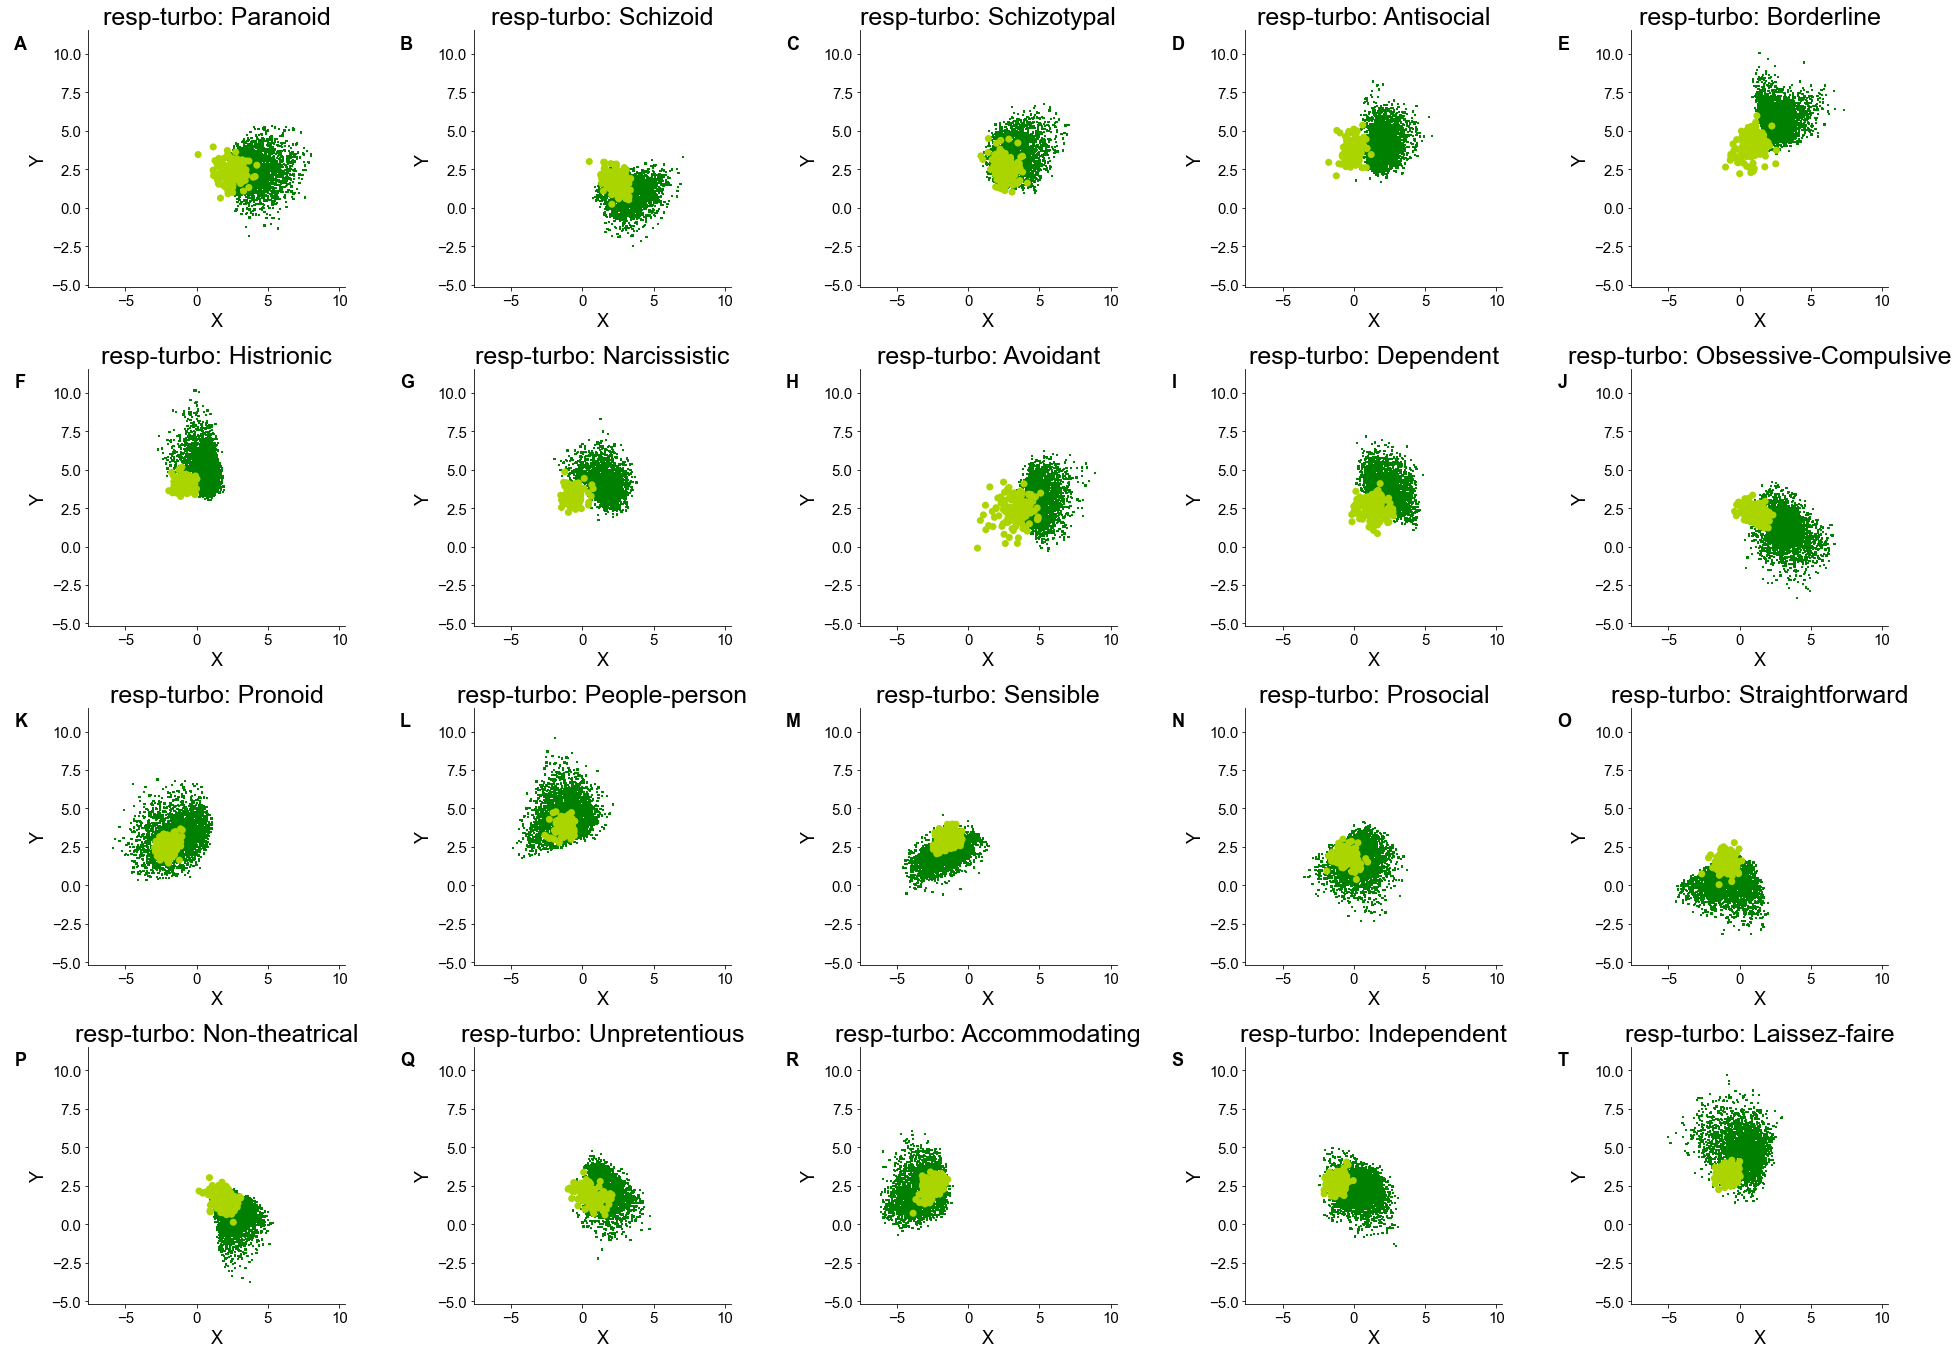

In [43]:

output_layout = (original_lda_imgs[0] * turbo_lda_imgs[0])

for idx in range(1, 20):
    output_layout += (original_lda_imgs[idx] * turbo_lda_imgs[idx])

output_layout.opts(fig_inches=5, fig_bounds=(0, 0, 1, 1)).cols(5)

hv.save(output_layout, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/responses_seperated_turbo.png", fmt="png")

output_layout

### Analysis

## IRR

In [44]:
irr_turbo = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_turbo_all_infromation[df_turbo_all_infromation.Label == label_idx]
    np_label_subset = df_label_subset.iloc[:, 0:50].to_numpy()

    irr = CalcInterRaterReliability(np_label_subset)
    irr_turbo[label_idx] = irr
    print(f"{LABEL_NAMES[label_idx]}: {irr}")

Paranoid: 0.4500319881889764
Schizoid: 0.46753937007874014
Schizotypal: 0.45777312992125985
Antisocial: 0.5075246062992126
Borderline: 0.47489665354330707
Histrionic: 0.5781963582677165
Narcissistic: 0.5328764763779528
Avoidant: 0.41200295275590554
Dependent: 0.45891732283464565
Obsessive-Compulsive: 0.5466363188976378
Pronoid: 0.5725270669291339
People-person: 0.5891461614173228
Sensible: 0.5829601377952756
Prosocial: 0.5507677165354331
Straightforward: 0.5983120078740157
Non-theatrical: 0.5033956692913386
Unpretentious: 0.5162647637795276
Accommodating: 0.5683759842519686
Independent: 0.5495398622047244
Laissez-faire: 0.5725270669291339


## Root Mean Squared Prediction Error (againstg Personality Facttors)

In [45]:
rmspe_facttors_turbo = np.zeros((20, 5))

for label_idx in range(0, 20):
    df_label_subset = df_turbo_all_infromation[df_turbo_all_infromation.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])

    rmspe = RootMeanSquaredError(np_array = np_ocean_subset, np_predictor = OCEAN_estimate)
    rmspe_facttors_turbo[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")

Paranoid: [0.19904459 0.14025902 0.11154641 0.4340288  0.10285578]
Schizoid: [0.1766424  0.15814476 0.26146448 0.22814298 0.14105351]
Schizotypal: [0.08425677 0.25173732 0.15212269 0.25437758 0.08898393]
Antisocial: [0.13039642 0.33375176 0.19181239 0.4062694  0.1021965 ]
Borderline: [0.09929977 0.31117967 0.16105305 0.32368333 0.11981865]
Histrionic: [0.08701392 0.32463877 0.07995301 0.29966411 0.09837119]
Narcissistic: [0.12552957 0.2317828  0.13100274 0.48774463 0.09567148]
Avoidant: [0.17433617 0.22041984 0.17629432 0.21774426 0.15143003]
Dependent: [0.16692878 0.21111519 0.12521082 0.115303   0.11743988]
Obsessive-Compulsive: [0.36450746 0.14238735 0.14389183 0.21714036 0.04831133]
Pronoid: [0.11411856 0.32189311 0.11160068 0.05547508 0.09168569]
People-person: [0.13244766 0.22386868 0.10128761 0.21082613 0.08587555]
Sensible: [0.26028677 0.13091699 0.03999394 0.17989294 0.15993338]
Prosocial: [0.2168239  0.05350599 0.13963191 0.08404184 0.06146474]
Straightforward: [0.28718307 0.

## RMSE of Euclidean Distance (against Personality)

In [46]:
rmspe_distance_turbo = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_turbo_all_infromation[df_turbo_all_infromation.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])

    # Get the distance between the labeld point and the instance
    np_distance_subset = np.zeros((np_ocean_subset.shape[0], 1))
    for idx in range(np_ocean_subset.shape[0]):
        np_distance_subset[idx] = np.linalg.norm(np_ocean_subset[idx] - OCEAN_estimate)

    # Calc the avgerage prediction distance
    np_avg_distance = np.mean(np_distance_subset)
    
    rmspe = RootMeanSquaredError(np_array = np_distance_subset, np_predictor = np_avg_distance)
    rmspe_distance_turbo[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")  


Paranoid: [0.07514209]
Schizoid: [0.06280686]
Schizotypal: [0.06237685]
Antisocial: [0.05742173]
Borderline: [0.07902346]
Histrionic: [0.04279538]
Narcissistic: [0.05257253]
Avoidant: [0.08602278]
Dependent: [0.05184939]
Obsessive-Compulsive: [0.04801076]
Pronoid: [0.04384566]
People-person: [0.04588526]
Sensible: [0.04866385]
Prosocial: [0.04407662]
Straightforward: [0.04818726]
Non-theatrical: [0.06121025]
Unpretentious: [0.05433155]
Accommodating: [0.04501238]
Independent: [0.04476674]
Laissez-faire: [0.04323759]


C:\Users\38977332\AppData\Local\Temp\ipykernel_15448\2849268258.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmspe_distance_turbo[label_idx] = rmspe


## RMSE Cosine Similarity (against Personality)

In [47]:
rmspe_cos_turbo = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_turbo_all_infromation[df_turbo_all_infromation.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])
    
    # Calculate the Cosine Similarity for each personality result
    np_cos_similarity = np.zeros((np_ocean_subset.shape[0], 1))
    for idx in range(np_ocean_subset.shape[0]): 
        dot_product = np.dot(np_ocean_subset[idx], OCEAN_estimate)
        norm_instant = np.linalg.norm(np_ocean_subset[idx])
        norm_predict = np.linalg.norm(OCEAN_estimate)
        np_cos_similarity[idx] = dot_product/(norm_instant*norm_predict)

    # Calculate the Avg Cosine Similarity
    avg_cos_similarity = np.mean(np_cos_similarity)

    rmspe = RootMeanSquaredError(np_array = np_cos_similarity, np_predictor = avg_cos_similarity)
    rmspe_cos_turbo[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")   

Paranoid: [0.01463103]
Schizoid: [0.01208437]
Schizotypal: [0.00934026]
Antisocial: [0.01190128]
Borderline: [0.01756452]
Histrionic: [0.00561803]
Narcissistic: [0.01097811]
Avoidant: [0.02363106]
Dependent: [0.00974502]
Obsessive-Compulsive: [0.01077989]
Pronoid: [0.00463295]
People-person: [0.00513396]
Sensible: [0.0039938]
Prosocial: [0.00402333]
Straightforward: [0.00519864]
Non-theatrical: [0.00679611]
Unpretentious: [0.00509665]
Accommodating: [0.00587336]
Independent: [0.00512482]
Laissez-faire: [0.01075253]


C:\Users\38977332\AppData\Local\Temp\ipykernel_15448\2336853815.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmspe_cos_turbo[label_idx] = rmspe


--------------------

### Devinchi

In [48]:
np_devinchi_response = np.zeros((2560,50))

r_idx = 0
for label_idx in range(20):
    df = pd.read_csv(f'C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/original_128/model_text-davinci-003_128/post/{LABEL_NAMES[label_idx]}.csv')
    df_T = df.transpose(copy=True)

    factors_id = 0
    for index, row in df_T.iterrows():
        question_idx = 0
        for row_element in row:
            if factors_id < 5:
                factors_id += 1
                continue
            
            factors_id += 1
            factor_list = row_element.split(';')
            for response_idx in range(10):
                response = factor_list[response_idx][-1]
                np_devinchi_response[r_idx, question_idx] = int(response)
                question_idx += 1
        if factors_id > 5:
            r_idx += 1
                    
print(np_devinchi_response)

[[4. 5. 2. ... 5. 5. 5.]
 [2. 5. 4. ... 5. 4. 5.]
 [1. 5. 4. ... 4. 5. 5.]
 ...
 [4. 5. 4. ... 3. 3. 4.]
 [4. 3. 5. ... 5. 3. 5.]
 [4. 2. 5. ... 5. 4. 5.]]


In [49]:
np_devinchi_OCEAN = EvaluateOceanTestResults(np_devinchi_response)
np_devinchi_OCEAN

np_devinchi_CSCF = calc_CSCF(np_devinchi_OCEAN)
np_devinchi_CSCF

np_llm_label = np.repeat(np.arange(20),128)

df_devinchi_all_infromation = CreateFullInfoDf(np_devinchi_response, np_devinchi_OCEAN, np_devinchi_CSCF, np_llm_label)
df_devinchi_all_infromation.describe()

E1           E2           E3           E4           E5  \
count  2560.000000  2560.000000  2560.000000  2560.000000  2560.000000   
mean      3.189844     3.186719     4.326172     1.520703     4.396484   
std       1.232892     1.793866     0.598502     0.599890     0.888151   
min       1.000000     1.000000     2.000000     1.000000     1.000000   
25%       2.000000     1.000000     4.000000     1.000000     4.000000   
50%       4.000000     4.000000     4.000000     1.000000     5.000000   
75%       4.000000     5.000000     5.000000     2.000000     5.000000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

                E6           E7           E8           E9          E10  ...  \
count  2560.000000  2560.000000  2560.000000  2560.000000  2560.000000  ...   
mean      1.759375     4.221484     1.543750     3.548828     2.722656  ...   
std       0.885332     0.700421     0.619187     1.052342     1.532644  ...   
min       1.000000     1.000000     1.000000     1.000000     1.000000  ...   
25%       1.000000     4.000000     1.000000     3.000000     2.000000  ...   
50%       2.000000     4.000000     2.000000     4.000000     2.000000  ...   
75%       2.000000     5.000000     2.000000     4.000000     5.000000  ...   
max       5.000000     5.000000     5.000000     5.000000     5.000000  ...   

                O9          O10     Openness  Conscientiousness  Extraversion  \
count  2560.000000  2560.000000  2560.000000        2560.000000   2560.000000   
mean      4.066797     4.893359     0.900039           0.897344      0.723740   
std       0.758327     0.366583     0.086385           0.087158      0.153587   
min       1.000000     2.000000     0.425000           0.300000      0.175000   
25%       4.000000     5.000000     0.900000           0.875000      0.593750   
50%       4.000000     5.000000     0.925000           0.925000      0.750000   
75%       5.000000     5.000000     0.950000           0.950000      0.850000   
max       5.000000     5.000000     1.000000           1.000000      1.000000   

       Agreeableness  Neuroticism        Alpha         Beta        Label  
count    2560.000000  2560.000000  2560.000000  2560.000000  2560.000000  
mean        0.871611     0.544854     2.224102     1.623779     9.500000  
std         0.052367     0.325285     0.364239     0.170805     5.767408  
min         0.600000     0.050000     1.200000     0.875000     0.000000  
25%         0.850000     0.225000     1.875000     1.475000     4.750000  
50%         0.875000     0.450000     2.275000     1.625000     9.500000  
75%         0.900000     0.925000     2.550000     1.775000    14.250000  
max         1.000000     1.000000     2.825000     2.000000    19.000000  

[8 rows x 58 columns]

In [50]:
df_devinchi_all_infromation.to_csv('C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/PersonalityTestDavinci.csv', index=False)

In [51]:
compare_array = np_llm_label == GetPersonalityProfileLabels(np_devinchi_OCEAN)
devinchi_accuracy = sum(compare_array)/compare_array.shape[0]
devinchi_error = (compare_array.shape[0] - sum(compare_array))/compare_array.shape[0]

conf_const = [1.64, 1.96, 2.33, 2.58]
confidence_interval_devinchi = [0.0, 0.0, 0.0, 0.0]
confidence_interval_devinchi[0] = conf_const[0] * np.sqrt( (devinchi_error * (1.0 - devinchi_error)) / compare_array.shape[0])
confidence_interval_devinchi[1] = conf_const[1] * np.sqrt( (devinchi_error * (1.0 - devinchi_error)) / compare_array.shape[0])
confidence_interval_devinchi[2] = conf_const[2] * np.sqrt( (devinchi_error * (1.0 - devinchi_error)) / compare_array.shape[0])
confidence_interval_devinchi[3] = conf_const[3] * np.sqrt( (devinchi_error * (1.0 - devinchi_error)) / compare_array.shape[0])

print(f"devinchi accuracy: {devinchi_accuracy * 100.0}%, devinchi error: {devinchi_error * 100.0}")
print(f"The true classification error of the model is likely between {devinchi_error - confidence_interval_devinchi[0]} and {devinchi_error + confidence_interval_devinchi[0]} at the 90% confidence interval")
print(f"The true classification error of the model is likely between {devinchi_error - confidence_interval_devinchi[1]} and {devinchi_error + confidence_interval_devinchi[1]} at the 95% confidence interval")
print(f"The true classification error of the model is likely between {devinchi_error - confidence_interval_devinchi[2]} and {devinchi_error + confidence_interval_devinchi[2]} at the 98% confidence interval")
print(f"The true classification error of the model is likely between {devinchi_error - confidence_interval_devinchi[3]} and {devinchi_error + confidence_interval_devinchi[3]} at the 99% confidence interval")
print(f"{devinchi_error} +/- {confidence_interval_devinchi[1]}")


devinchi accuracy: 13.828125%, devinchi error: 86.171875
The true classification error of the model is likely between 0.8505298269995702 and 0.8729076730004297 at the 90% confidence interval
The true classification error of the model is likely between 0.8483466225116815 and 0.8750908774883185 at the 95% confidence interval
The true classification error of the model is likely between 0.8458222923225601 and 0.8776152076774398 at the 98% confidence interval
The true classification error of the model is likely between 0.844116663816397 and 0.8793208361836029 at the 99% confidence interval
0.86171875 +/- 0.013372127488318482


## Visualize

:Scatter   [Beta]   (Alpha,Label)
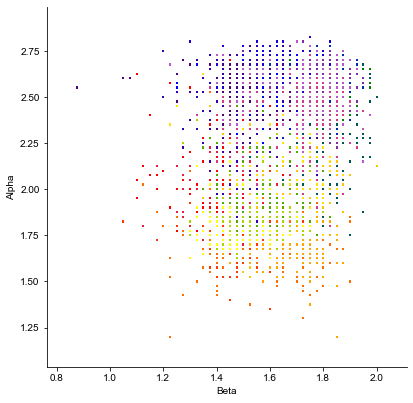

In [52]:
img =hv.Scatter(
    data=df_devinchi_all_infromation, kdims = ["Beta"], vdims = ["Alpha", "Label"]
).opts(color='Label', 
       cmap=LABEL_COLORS_HEX, 
       s=5, 
       alpha=1.0,
       marker = ',')

img.opts(aspect=1, fig_inches=5, fig_bounds=(0, 0, 1, 1))

:Layout
   .Overlay.I     :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.II    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.III   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.IV    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.V     :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VI    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VII   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VIII  :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.IX    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.X     :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XI    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XII   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIII  :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIV   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XV    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVI   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVII  :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVIII :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIX   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XX    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
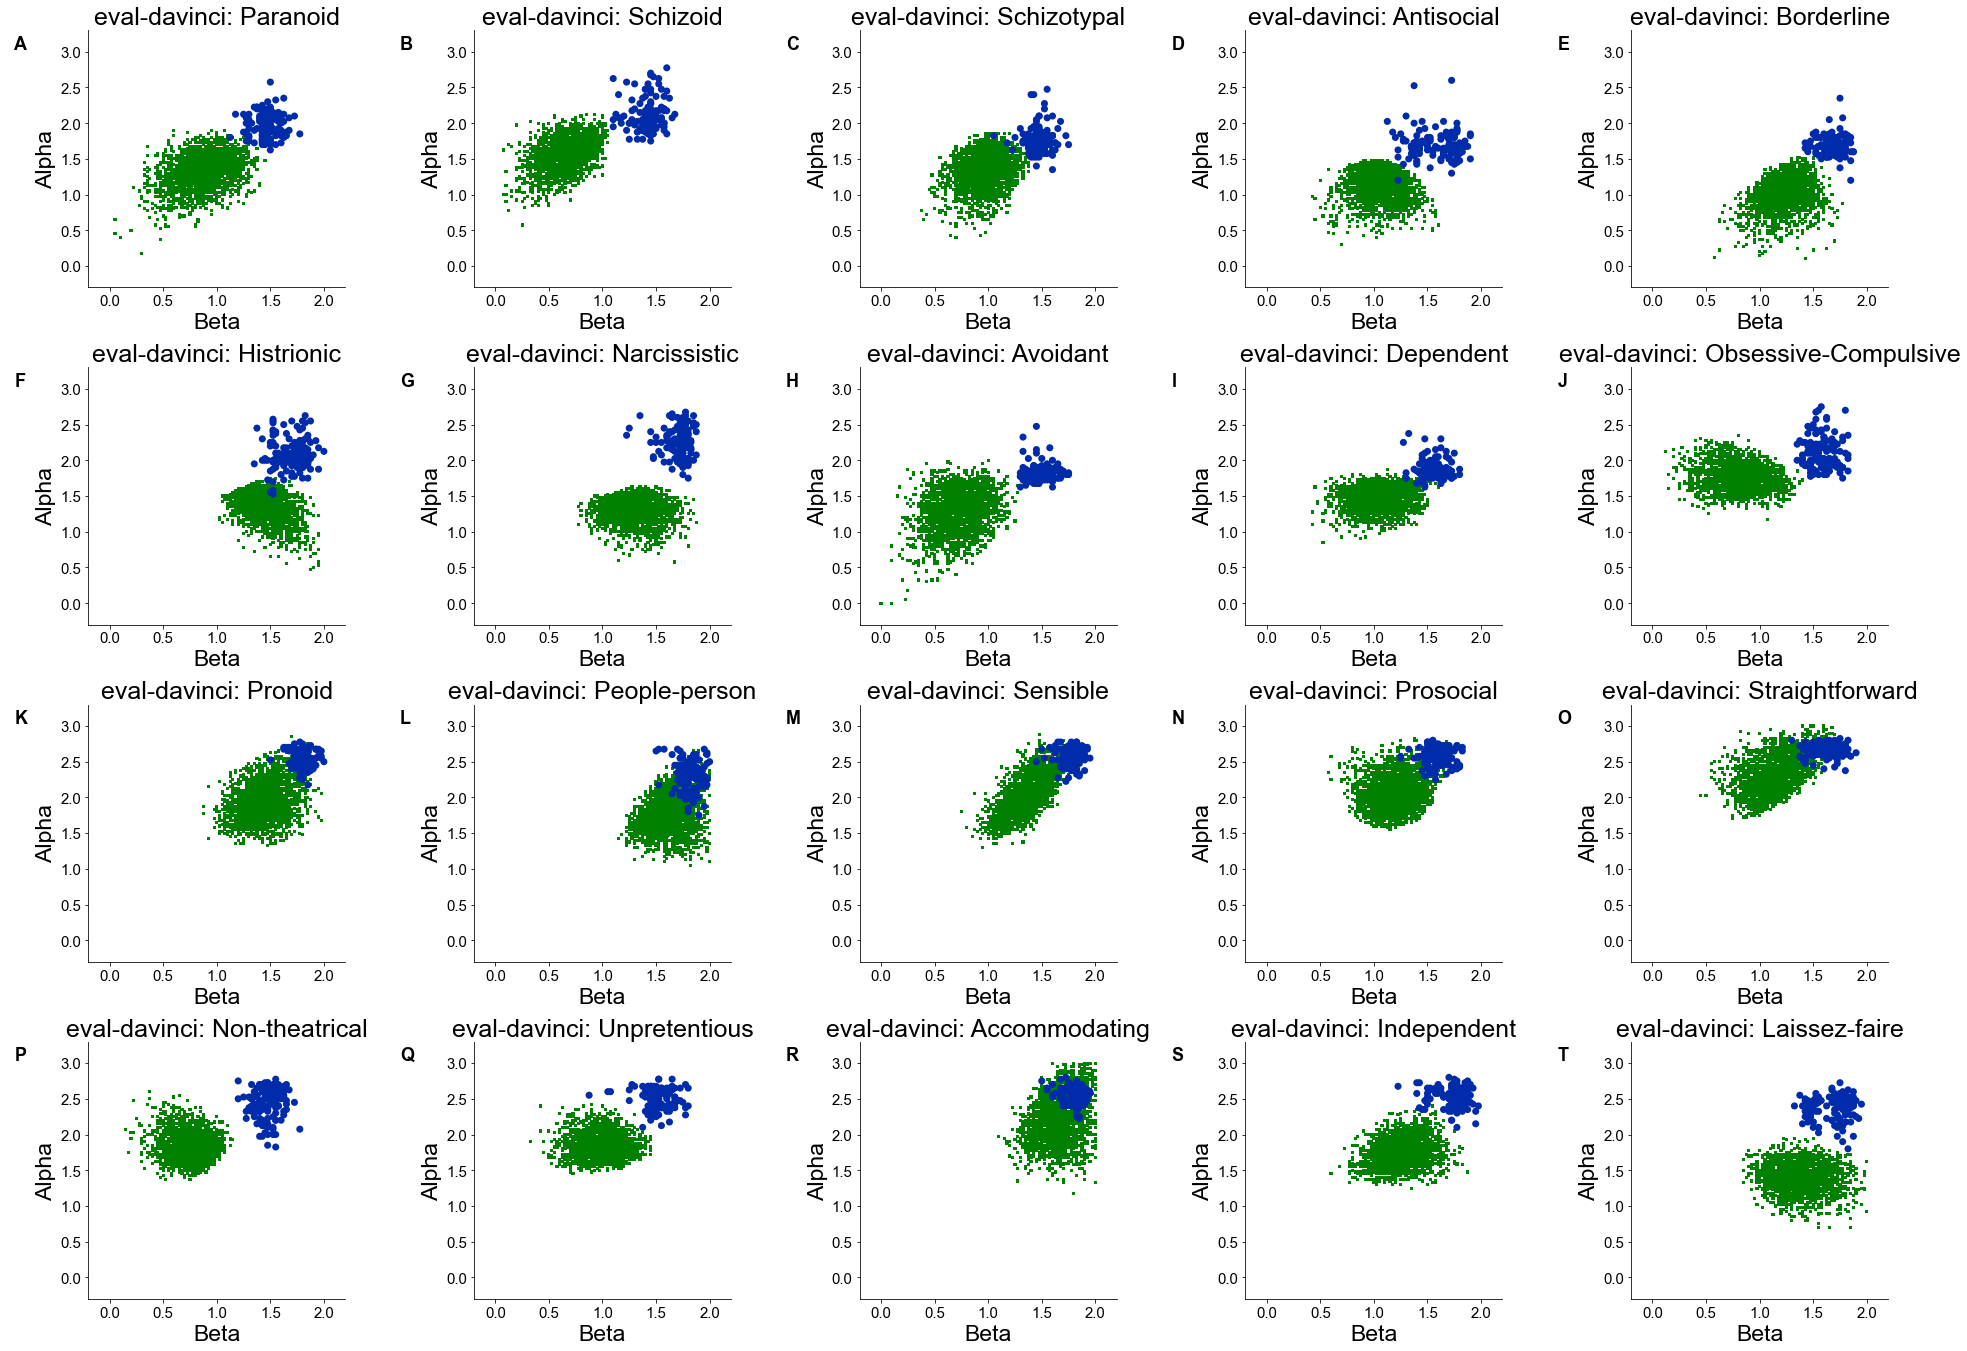

In [53]:
devinchi_eval_imgs = [hv.Scatter(data=df_devinchi_all_infromation[df_devinchi_all_infromation.Label == label_idx], kdims = ["Beta"], vdims = ["Alpha", "Label"]
                       ).opts(color='Label',
                              cmap=[LABEL_COLORS_HEX[12]],
                              s=50,
                              alpha=1.0,
                              title=f"eval-davinci: {LABEL_NAMES[label_idx]}",
                              marker='o',
                              fontsize={'title': 25, 
                  'labels': 23, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

original_eval_imgs =  [hv.Scatter(data=df_all_infromation_subset[df_all_infromation_subset.Label == label_idx], kdims = ["Beta"], vdims = ["Alpha", "Label"]
                             ).opts(color='Label', 
                                    cmap=[LABEL_COLORS_HEX[10]], 
                                    s=10, 
                                    alpha=1.0,
                                    #title=f"eval-davinci: {LABEL_NAMES[label_idx]}",
                                    marker=',',
                                    fontsize={'title': 25, 
                  'labels': 23, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

output_layout = (original_eval_imgs[0] * devinchi_eval_imgs[0] * profile_eval_imgs[0])

for idx in range(1, 20):
    output_layout += (original_eval_imgs[idx] * devinchi_eval_imgs[idx] * profile_eval_imgs[idx])

output_layout.opts(fig_inches=5, fig_bounds=(0, 0, 1, 1)).cols(5)

hv.save(output_layout, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/eval_seperated_devinchi.png", fmt="png")

output_layout

### LDA

In [54]:
devinchi_responses_lda = lda.transform(np_devinchi_response)

np_devinchi_lda = np.concatenate((devinchi_responses_lda, np.reshape(np_llm_label, (np_llm_label.shape[0], 1))), axis = 1)

df_devinchi_lda = pd.DataFrame(np_devinchi_lda, columns= ["X", "Y", "Label"])

:Scatter   [X]   (Y,Label)
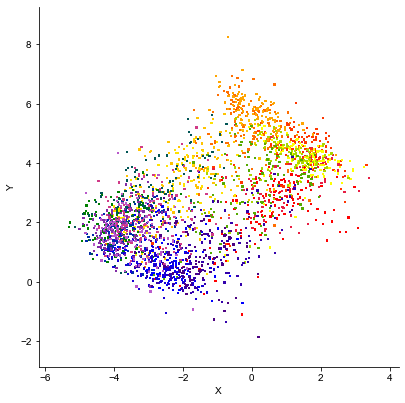

In [55]:
img = hv.Scatter(
    data=df_devinchi_lda, kdims = ["X"], vdims = ["Y", "Label"]
).opts(color='Label', 
       cmap=LABEL_COLORS_HEX, 
       s=5, 
       alpha=1.0,
       marker = ',')

img.opts(aspect=1, fig_inches=5, fig_bounds=(0, 0, 1, 1))

In [56]:
devinchi_lda_imgs = [hv.Scatter(data=df_devinchi_lda[df_devinchi_lda.Label == label_idx], kdims = ["X"], vdims = ["Y", "Label"]
                       ).opts(color='Label',
                              cmap=[LABEL_COLORS_HEX[12]],
                              s=50,
                              alpha=1.0,
                              title=f"resp-davinci: {LABEL_NAMES[label_idx]}",
                              marker='o',
                              fontsize={'title': 25, 
                  'labels': 18, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

original_lda_imgs =  [hv.Scatter(data=df_lda[df_lda.Label == label_idx], kdims = ["X"], vdims = ["Y", "Label"]
                             ).opts(color='Label', 
                                    cmap=[LABEL_COLORS_HEX[10]], 
                                    s=5, 
                                    alpha=1.0,
                                    #title=f"respo-davinci: {LABEL_NAMES[label_idx]}",
                                    marker=',',
                                    fontsize={'title': 25, 
                  'labels': 18, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

:Layout
   .Overlay.I     :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.II    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.III   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.IV    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.V     :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VI    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VII   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VIII  :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.IX    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.X     :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XI    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XII   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XIII  :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XIV   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XV    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XVI   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XVII  :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XVIII :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XIX   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XX    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
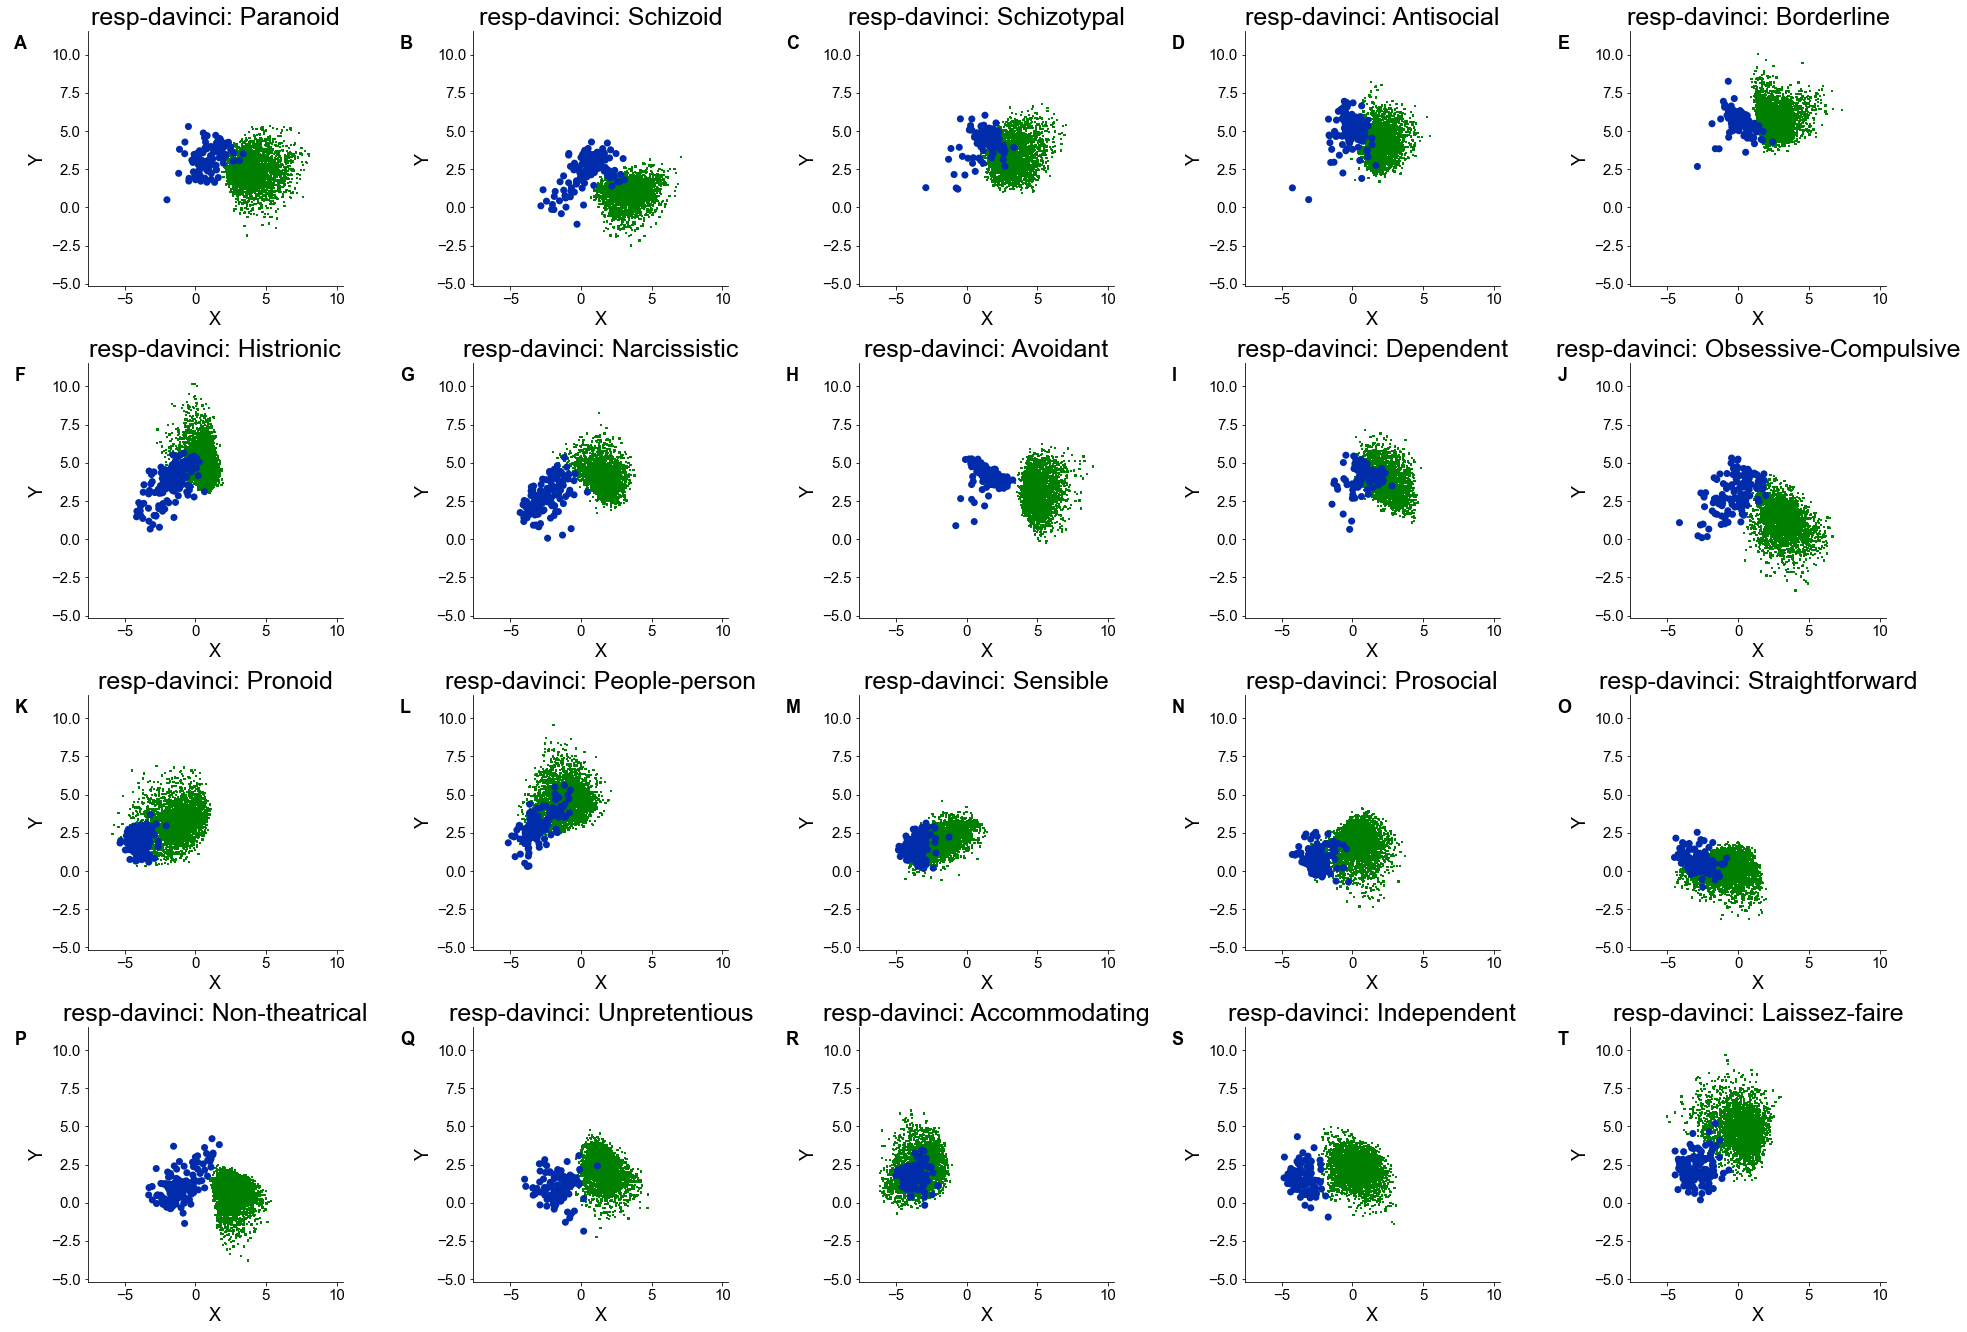

In [57]:
output_layout = (original_lda_imgs[0] * devinchi_lda_imgs[0])

for idx in range(1, 20):
    output_layout += (original_lda_imgs[idx] * devinchi_lda_imgs[idx])

output_layout.opts(fig_inches=5, fig_bounds=(0, 0, 1, 1)).cols(5)

hv.save(output_layout, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/responses_seperated_devinchi.png", fmt="png")

output_layout

## Analytics

### IRR

In [58]:
irr_devinchi = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_devinchi_all_infromation[df_devinchi_all_infromation.Label == label_idx]
    np_label_subset = df_label_subset.iloc[:, 0:50].to_numpy()

    irr = CalcInterRaterReliability(np_label_subset)
    irr_devinchi[label_idx] = irr
    print(f"{LABEL_NAMES[label_idx]}: {irr}")

Paranoid: 0.638939468503937
Schizoid: 0.5759694881889764
Schizotypal: 0.6292150590551181
Antisocial: 0.5669119094488189
Borderline: 0.6593134842519685
Histrionic: 0.5216609251968504
Narcissistic: 0.5284621062992126
Avoidant: 0.6814099409448819
Dependent: 0.6639124015748031
Obsessive-Compulsive: 0.607224409448819
Pronoid: 0.6118946850393701
People-person: 0.5648966535433071
Sensible: 0.6472170275590551
Prosocial: 0.6267937992125985
Straightforward: 0.6540501968503937
Non-theatrical: 0.6061540354330709
Unpretentious: 0.6048056102362205
Accommodating: 0.6150172244094488
Independent: 0.5675442913385826
Laissez-faire: 0.5192199803149606


### Root Mean Squared Prediction Error (againstg Personality Facttors)

In [59]:
rmspe_facttors_devinchi = np.zeros((20, 5))

for label_idx in range(0, 20):
    df_label_subset = df_devinchi_all_infromation[df_devinchi_all_infromation.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])

    rmspe = RootMeanSquaredError(np_array = np_ocean_subset, np_predictor = OCEAN_estimate)
    rmspe_facttors_devinchi[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")

Paranoid: [0.52036045 0.34447471 0.25575796 0.66532031 0.26652937]
Schizoid: [0.53763934 0.42809078 0.45106147 0.44385166 0.29868462]
Schizotypal: [0.36275851 0.4290007  0.35640718 0.45152621 0.30577574]
Antisocial: [0.28127657 0.44883595 0.31173343 0.59419337 0.37587292]
Borderline: [0.33925368 0.43006742 0.28212814 0.5587334  0.19398188]
Histrionic: [0.22646126 0.4887499  0.12867073 0.43514584 0.21446959]
Narcissistic: [0.34536362 0.40772667 0.21316211 0.62220178 0.20062379]
Avoidant: [0.50424404 0.43711562 0.42692533 0.39625156 0.14180891]
Dependent: [0.47569643 0.45364549 0.26572428 0.24138811 0.23636269]
Obsessive-Compulsive: [0.65727871 0.12151363 0.30891534 0.3982755  0.26867732]
Pronoid: [0.32070114 0.49132428 0.20785461 0.09543048 0.16632992]
People-person: [0.28902348 0.38382837 0.07592785 0.29814596 0.2190168 ]
Sensible: [0.46997588 0.3635862  0.10916723 0.29913375 0.13530339]
Prosocial: [0.46077328 0.28374174 0.22306021 0.1563779  0.20928446]
Straightforward: [0.50353797 0.

### RMSE of Euclidean Distance (against Personality)


In [60]:
rmspe_distance_devinchi = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_devinchi_all_infromation[df_devinchi_all_infromation.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])

    # Get the distance between the labeld point and the instance
    np_distance_subset = np.zeros((np_ocean_subset.shape[0], 1))
    for idx in range(np_ocean_subset.shape[0]):
        np_distance_subset[idx] = np.linalg.norm(np_ocean_subset[idx] - OCEAN_estimate)

    # Calc the avgerage prediction distance
    np_avg_distance = np.mean(np_distance_subset)
    
    rmspe = RootMeanSquaredError(np_array = np_distance_subset, np_predictor = np_avg_distance)
    rmspe_distance_devinchi[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")  


Paranoid: [0.05686462]
Schizoid: [0.06811844]
Schizotypal: [0.0693334]
Antisocial: [0.08380014]
Borderline: [0.05654508]
Histrionic: [0.07188865]
Narcissistic: [0.06959185]
Avoidant: [0.05956911]
Dependent: [0.05074092]
Obsessive-Compulsive: [0.06191897]
Pronoid: [0.0564114]
People-person: [0.05542085]
Sensible: [0.04354959]
Prosocial: [0.0535345]
Straightforward: [0.05110012]
Non-theatrical: [0.06199649]
Unpretentious: [0.05848546]
Accommodating: [0.04903635]
Independent: [0.06667979]
Laissez-faire: [0.07213573]


C:\Users\38977332\AppData\Local\Temp\ipykernel_15448\2328252137.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmspe_distance_devinchi[label_idx] = rmspe


### RMSE Cosine Similarity (against Personality)

In [61]:
rmspe_cos_devinchi = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_devinchi_all_infromation[df_devinchi_all_infromation.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])
    
    # Calculate the Cosine Similarity for each personality result
    np_cos_similarity = np.zeros((np_ocean_subset.shape[0], 1))
    for idx in range(np_ocean_subset.shape[0]): 
        dot_product = np.dot(np_ocean_subset[idx], OCEAN_estimate)
        norm_instant = np.linalg.norm(np_ocean_subset[idx])
        norm_predict = np.linalg.norm(OCEAN_estimate)
        np_cos_similarity[idx] = dot_product/(norm_instant*norm_predict)

    # Calculate the Avg Cosine Similarity
    avg_cos_similarity = np.mean(np_cos_similarity)

    rmspe = RootMeanSquaredError(np_array = np_cos_similarity, np_predictor = avg_cos_similarity)
    rmspe_cos_devinchi[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")   

Paranoid: [0.01899406]
Schizoid: [0.02825459]
Schizotypal: [0.02070537]
Antisocial: [0.02403475]
Borderline: [0.01181737]
Histrionic: [0.02002784]
Narcissistic: [0.02516295]
Avoidant: [0.01791728]
Dependent: [0.0127907]
Obsessive-Compulsive: [0.01835548]
Pronoid: [0.00973855]
People-person: [0.01634046]
Sensible: [0.01025629]
Prosocial: [0.01107999]
Straightforward: [0.00636637]
Non-theatrical: [0.02085318]
Unpretentious: [0.01661924]
Accommodating: [0.00932287]
Independent: [0.01061008]
Laissez-faire: [0.02335057]


C:\Users\38977332\AppData\Local\Temp\ipykernel_15448\600434108.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmspe_cos_devinchi[label_idx] = rmspe


--------------------

## GPT-4

In [62]:
np_gpt4_response = np.zeros((2560,50), dtype=int)

r_idx = 0
for label_idx in range(20):
    df = pd.read_csv(f'C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/original_128/model_gpt-4_128/post/{LABEL_NAMES[label_idx]}.csv')
    df_T = df.transpose(copy=True)

    factors_id = 0
    for index, row in df_T.iterrows():
        question_idx = 0
        print(f"{label_idx}, {index}")
        for row_element in row:
            if factors_id < 5:
                factors_id += 1
                continue
            
            factors_id += 1
            factor_list = row_element.split(';')
            for response_idx in range(10):
                response = factor_list[response_idx][-1]
                np_gpt4_response[r_idx, question_idx] = int(response)
                question_idx += 1
        if factors_id > 5:
            r_idx += 1
                    
print(np_gpt4_response)

0, Factor
0, 0
0, 1
0, 2
0, 3
0, 4
0, 5
0, 6
0, 7
0, 8
0, 9
0, 10
0, 11
0, 12
0, 13
0, 14
0, 15
0, 16
0, 17
0, 18
0, 19
0, 20
0, 21
0, 22
0, 23
0, 24
0, 25
0, 26
0, 27
0, 28
0, 29
0, 30
0, 31
0, 32
0, 33
0, 34
0, 35
0, 36
0, 37
0, 38
0, 39
0, 40
0, 41
0, 42
0, 43
0, 44
0, 45
0, 46
0, 47
0, 48
0, 49
0, 50
0, 51
0, 52
0, 53
0, 54
0, 55
0, 56
0, 57
0, 58
0, 59
0, 60
0, 61
0, 62
0, 63
0, 64
0, 65
0, 66
0, 67
0, 68
0, 69
0, 70
0, 71
0, 72
0, 73
0, 74
0, 75
0, 76
0, 77
0, 78
0, 79
0, 80
0, 81
0, 82
0, 83
0, 84
0, 85
0, 86
0, 87
0, 88
0, 89
0, 90
0, 91
0, 92
0, 93
0, 94
0, 95
0, 96
0, 97
0, 98
0, 99
0, 100
0, 101
0, 102
0, 103
0, 104
0, 105
0, 106
0, 107
0, 108
0, 109
0, 110
0, 111
0, 112
0, 113
0, 114
0, 115
0, 116
0, 117
0, 118
0, 119
0, 120
0, 121
0, 122
0, 123
0, 124
0, 125
0, 126
0, 127
1, Factor
1, 0
1, 1
1, 2
1, 3
1, 4
1, 5
1, 6
1, 7
1, 8
1, 9
1, 10
1, 11
1, 12
1, 13
1, 14
1, 15
1, 16
1, 17
1, 18
1, 19
1, 20
1, 21
1, 22
1, 23
1, 24
1, 25
1, 26
1, 27
1, 28
1, 29
1, 30
1, 31
1, 32
1, 33


In [63]:
np_gpt4_OCEAN = EvaluateOceanTestResults(np_gpt4_response)
np_gpt4_OCEAN


array([[0.375, 0.725, 0.225, 0.225, 0.9  ],
       [0.425, 0.7  , 0.225, 0.2  , 0.825],
       [0.425, 0.425, 0.2  , 0.225, 0.8  ],
       ...,
       [0.725, 0.25 , 0.7  , 0.7  , 0.575],
       [0.725, 0.3  , 0.825, 0.675, 0.525],
       [0.7  , 0.225, 0.725, 0.7  , 0.55 ]])

In [64]:
np_gpt4_CSCF = calc_CSCF(np_gpt4_OCEAN)
np_gpt4_CSCF


array([[1.05 , 0.6  ],
       [1.075, 0.65 ],
       [0.85 , 0.625],
       ...,
       [1.375, 1.425],
       [1.45 , 1.55 ],
       [1.375, 1.425]])

In [65]:
np_llm_label = np.repeat(np.arange(20),128)

In [66]:

df_gpt4_all_infromation = CreateFullInfoDf(np_gpt4_response, np_gpt4_OCEAN, np_gpt4_CSCF, np_llm_label)
df_gpt4_all_infromation.describe()


E1           E2           E3           E4           E5  \
count  2560.000000  2560.000000  2560.000000  2560.000000  2560.000000   
mean      3.126953     3.010547     3.578906     3.130469     3.172266   
std       1.093113     1.015841     1.038166     1.074851     1.214255   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       2.000000     2.000000     3.000000     2.000000     2.000000   
50%       3.000000     3.000000     4.000000     3.000000     3.000000   
75%       4.000000     4.000000     4.000000     4.000000     4.000000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

                E6           E7           E8           E9          E10  ...  \
count  2560.000000  2560.000000  2560.000000  2560.000000  2560.000000  ...   
mean      3.017969     3.153125     3.300391     2.868750     3.401172  ...   
std       0.961789     1.289325     1.094946     1.076572     1.131971  ...   
min       1.000000     1.000000     1.000000     1.000000     1.000000  ...   
25%       2.000000     2.000000     2.000000     2.000000     2.000000  ...   
50%       3.000000     3.000000     3.000000     3.000000     3.000000  ...   
75%       4.000000     4.000000     4.000000     4.000000     4.000000  ...   
max       5.000000     5.000000     5.000000     5.000000     5.000000  ...   

                O9          O10     Openness  Conscientiousness  Extraversion  \
count  2560.000000  2560.000000  2560.000000        2560.000000   2560.000000   
mean      3.809375     3.582031     0.586133           0.531787      0.500986   
std       0.590724     0.691819     0.136336           0.181626      0.255228   
min       2.000000     2.000000     0.225000           0.200000      0.000000   
25%       3.000000     3.000000     0.450000           0.350000      0.250000   
50%       4.000000     4.000000     0.650000           0.525000      0.525000   
75%       4.000000     4.000000     0.700000           0.700000      0.725000   
max       5.000000     5.000000     0.900000           1.000000      0.975000   

       Agreeableness  Neuroticism        Alpha         Beta        Label  
count    2560.000000  2560.000000  2560.000000  2560.000000  2560.000000  
mean        0.554336     0.570254     1.515869     1.087119     9.500000  
std         0.213235     0.226763     0.492006     0.377704     5.767408  
min         0.075000     0.050000     0.550000     0.325000     0.000000  
25%         0.350000     0.325000     1.050000     0.700000     4.750000  
50%         0.625000     0.625000     1.550000     1.175000     9.500000  
75%         0.750000     0.750000     1.950000     1.450000    14.250000  
max         0.900000     0.975000     2.400000     1.700000    19.000000  

[8 rows x 58 columns]

In [67]:
df_gpt4_all_infromation.to_csv('C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/PersonalityTestGPT4.csv', index=False)

In [68]:
compare_array = np_llm_label == GetPersonalityProfileLabels(np_gpt4_OCEAN)
gpt4_accuracy = sum(compare_array)/compare_array.shape[0]
gpt4_error = (compare_array.shape[0] - sum(compare_array))/compare_array.shape[0]

conf_const = [1.64, 1.96, 2.33, 2.58]
confidence_interval_gpt4 = [0.0, 0.0, 0.0, 0.0]
confidence_interval_gpt4[0] = conf_const[0] * np.sqrt( (gpt4_error * (1.0 - gpt4_error)) / compare_array.shape[0])
confidence_interval_gpt4[1] = conf_const[1] * np.sqrt( (gpt4_error * (1.0 - gpt4_error)) / compare_array.shape[0])
confidence_interval_gpt4[2] = conf_const[2] * np.sqrt( (gpt4_error * (1.0 - gpt4_error)) / compare_array.shape[0])
confidence_interval_gpt4[3] = conf_const[3] * np.sqrt( (gpt4_error * (1.0 - gpt4_error)) / compare_array.shape[0])

print(f"gpt4 accuracy: {gpt4_accuracy * 100.0}%, gpt4 error: {gpt4_error * 100.0}")
print(f"The true classification error of the model is likely between {gpt4_error - confidence_interval_gpt4[0]} and {gpt4_error + confidence_interval_gpt4[0]} at the 90% confidence interval")
print(f"The true classification error of the model is likely between {gpt4_error - confidence_interval_gpt4[1]} and {gpt4_error + confidence_interval_gpt4[1]} at the 95% confidence interval")
print(f"The true classification error of the model is likely between {gpt4_error - confidence_interval_gpt4[2]} and {gpt4_error + confidence_interval_gpt4[2]} at the 98% confidence interval")
print(f"The true classification error of the model is likely between {gpt4_error - confidence_interval_gpt4[3]} and {gpt4_error + confidence_interval_gpt4[3]} at the 99% confidence interval")
print(f"{gpt4_error} +/- {confidence_interval_gpt4[1]}")

gpt4 accuracy: 73.984375%, gpt4 error: 26.015624999999996
The true classification error of the model is likely between 0.24593587654411017 and 0.2743766234558898 at the 90% confidence interval
The true classification error of the model is likely between 0.24316116952832678 and 0.2771513304716732 at the 95% confidence interval
The true classification error of the model is likely between 0.23995291454132725 and 0.2803595854586727 at the 98% confidence interval
The true classification error of the model is likely between 0.2377851746852465 and 0.28252732531475344 at the 99% confidence interval
0.26015625 +/- 0.01699508047167319


### Visualize Synthetic data

:Scatter   [Beta]   (Alpha,Label)
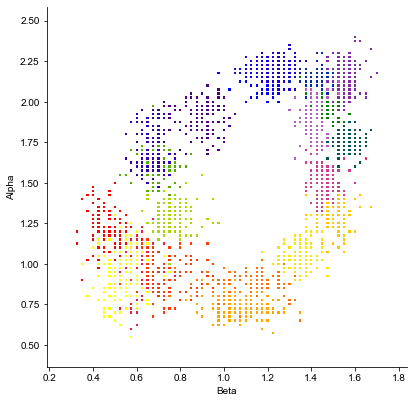

In [69]:
img =hv.Scatter(
    data=df_gpt4_all_infromation, kdims = ["Beta"], vdims = ["Alpha", "Label"]
).opts(color='Label', 
       cmap=LABEL_COLORS_HEX, 
       s=5, 
       alpha=1.0,
       marker = ',')

img.opts(aspect=1, fig_inches=5, fig_bounds=(0, 0, 1, 1))


:Layout
   .Overlay.I     :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.II    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.III   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.IV    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.V     :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VI    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VII   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VIII  :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.IX    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.X     :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XI    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XII   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIII  :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIV   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XV    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVI   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVII  :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XVIII :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XIX   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.XX    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
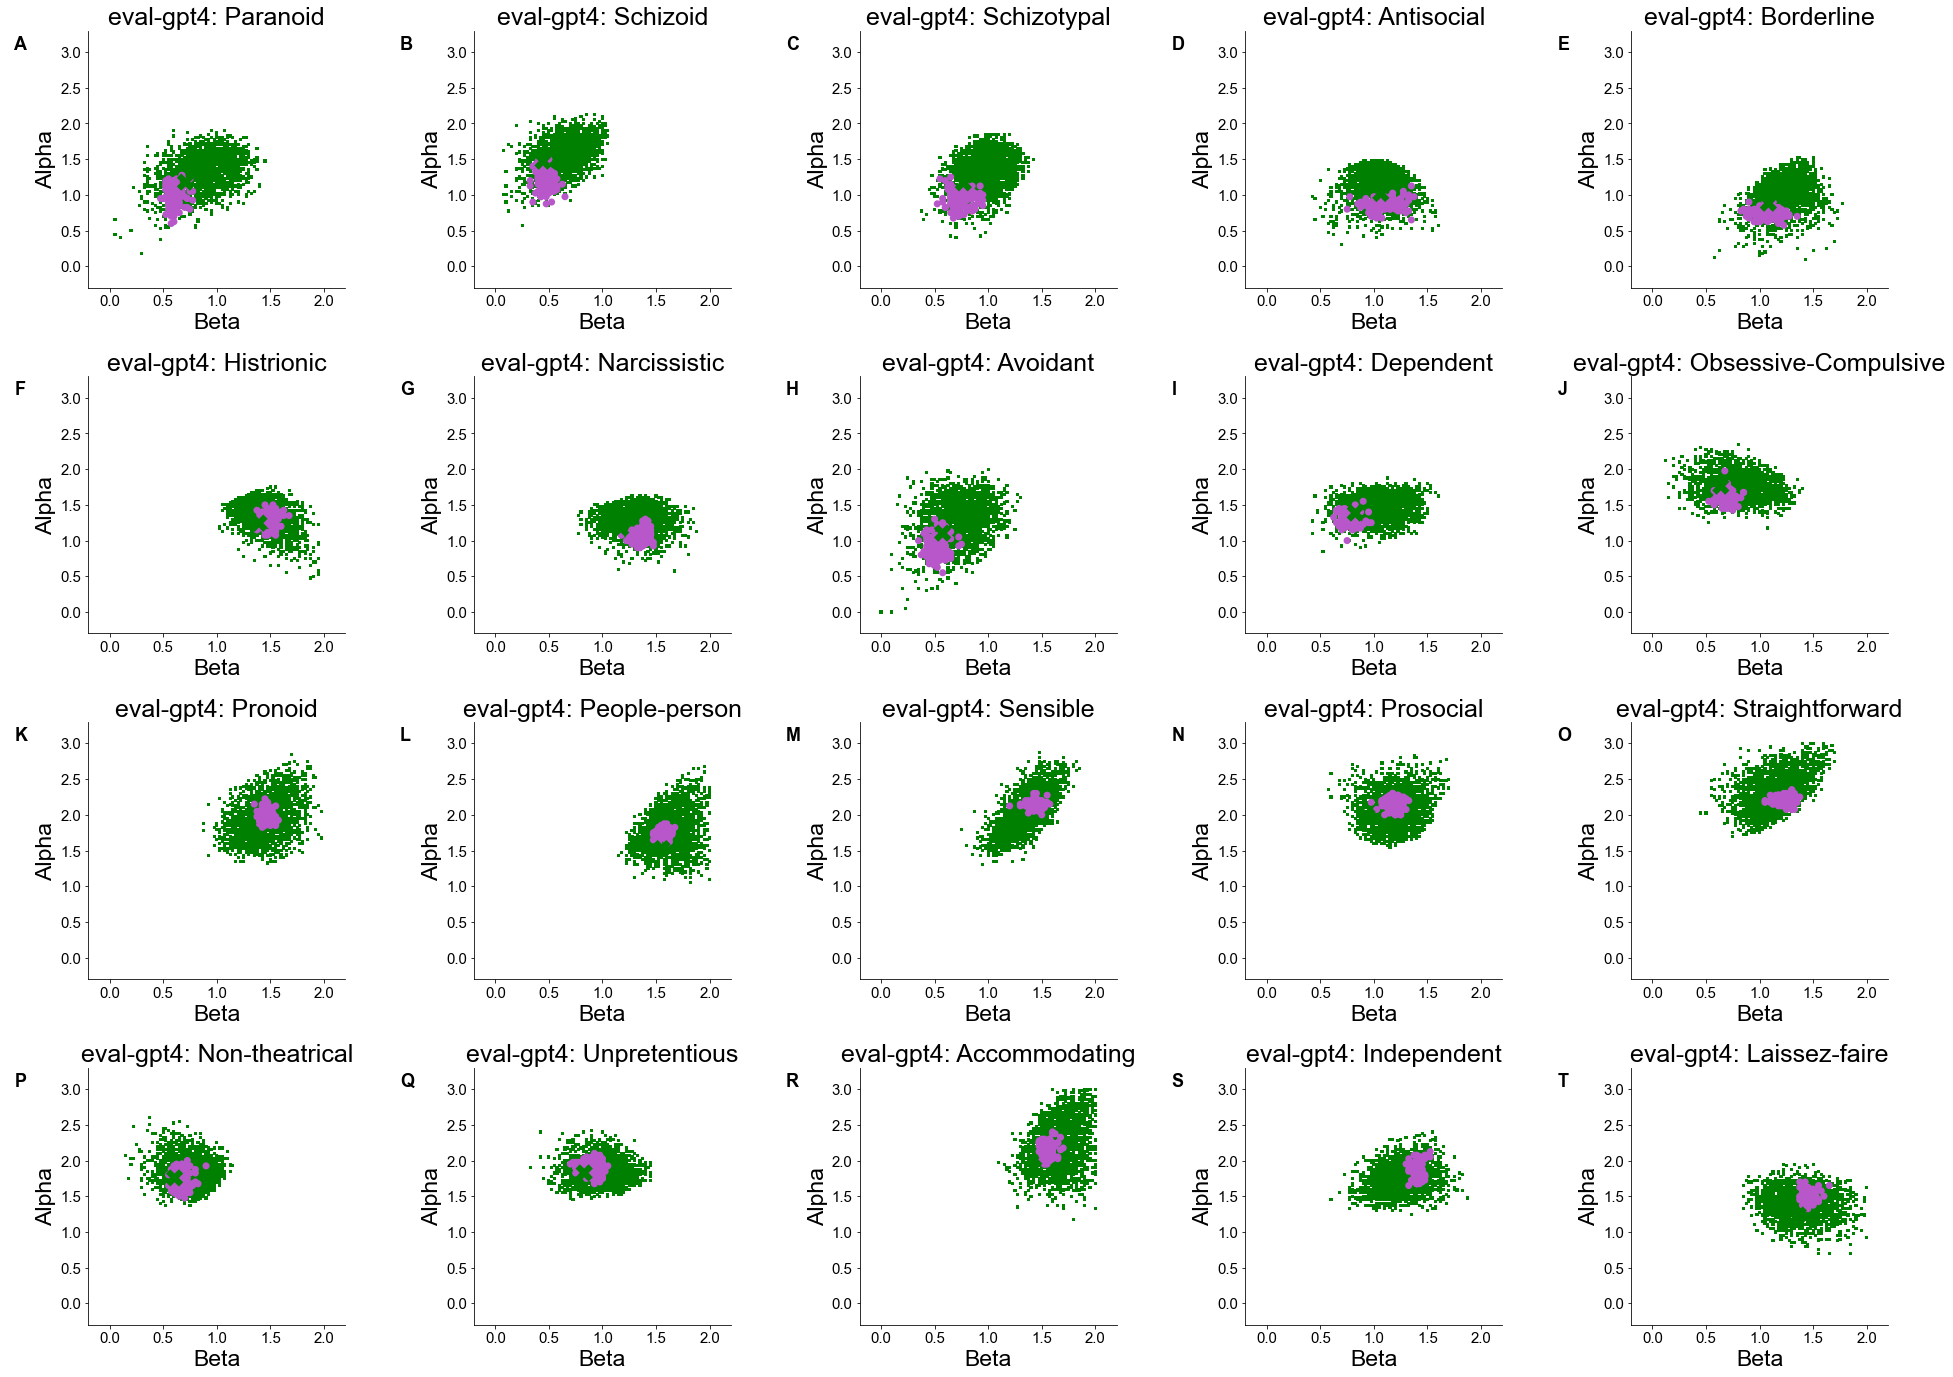

In [70]:
gpt4_eval_imgs = [hv.Scatter(data=df_gpt4_all_infromation[df_gpt4_all_infromation.Label == label_idx], kdims = ["Beta"], vdims = ["Alpha", "Label"]
                       ).opts(color='Label',
                              cmap=[LABEL_COLORS_HEX[18]],
                              s=50,
                              alpha=1.0,
                              title=f"eval-gpt4: {LABEL_NAMES[label_idx]}",
                              marker='o',
                              fontsize={'title': 25, 
                  'labels': 23, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

original_eval_imgs =  [hv.Scatter(data=df_all_infromation_subset[df_all_infromation_subset.Label == label_idx], kdims = ["Beta"], vdims = ["Alpha", "Label"]
                             ).opts(color='Label', 
                                    cmap=[LABEL_COLORS_HEX[10]], 
                                    s=10, 
                                    alpha=1.0,
                                    #title=f"eval-gpt4: {LABEL_NAMES[label_idx]}",
                                    marker=',',
                                    fontsize={'title': 25, 
                  'labels': 23, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

output_layout = (original_eval_imgs[0] * gpt4_eval_imgs[0] * profile_eval_imgs[0])

for idx in range(1, 20):
    output_layout += (original_eval_imgs[idx] * gpt4_eval_imgs[idx] * profile_eval_imgs[idx])

output_layout.opts(fig_inches=5, fig_bounds=(0, 0, 1, 1)).cols(5)

hv.save(output_layout, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/eval_seperated_gpt4.png", fmt="png")

output_layout

### LDA


In [71]:
gpt4_responses_lda = lda.transform(np_gpt4_response)

np_gpt4_lda = np.concatenate((gpt4_responses_lda, np.reshape(np_llm_label, (np_llm_label.shape[0], 1))), axis = 1)

df_gpt4_lda = pd.DataFrame(np_gpt4_lda, columns= ["X", "Y", "Label"])

:Scatter   [X]   (Y,Label)
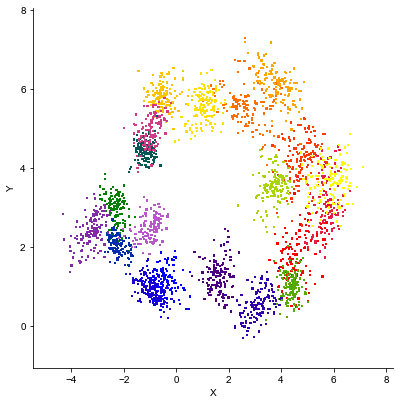

In [72]:
img = hv.Scatter(
    data=df_gpt4_lda, kdims = ["X"], vdims = ["Y", "Label"]
).opts(color='Label', 
       cmap=LABEL_COLORS_HEX, 
       s=5, 
       alpha=1.0,
       marker = ',')

img.opts(aspect=1, fig_inches=5, fig_bounds=(0, 0, 1, 1))



In [73]:
gpt4_lda_imgs = [hv.Scatter(data=df_gpt4_lda[df_gpt4_lda.Label == label_idx], kdims = ["X"], vdims = ["Y", "Label"]
                       ).opts(color='Label',
                              cmap=[LABEL_COLORS_HEX[18]],
                              s=50,
                              alpha=1.0,
                              title=f"resp-gpt4: {LABEL_NAMES[label_idx]}",
                              marker='o',
                              fontsize={'title': 25, 
                  'labels': 18, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

original_lda_imgs =  [hv.Scatter(data=df_lda[df_lda.Label == label_idx], kdims = ["X"], vdims = ["Y", "Label"]
                             ).opts(color='Label', 
                                    cmap=[LABEL_COLORS_HEX[10]], 
                                    s=5, 
                                    alpha=1.0,
                                    #title=f"resp-gpt4: {LABEL_NAMES[label_idx]}",
                                    marker=',',
                                    fontsize={'title': 25, 
                  'labels': 18, 
                  'xticks': 15, 
                  'yticks': 15}) for label_idx in range(0, 20)]

:Layout
   .Overlay.I     :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.II    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.III   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.IV    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.V     :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VI    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VII   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VIII  :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.IX    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.X     :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XI    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XII   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XIII  :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XIV   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XV    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XVI   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XVII  :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XVIII :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XIX   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.XX    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
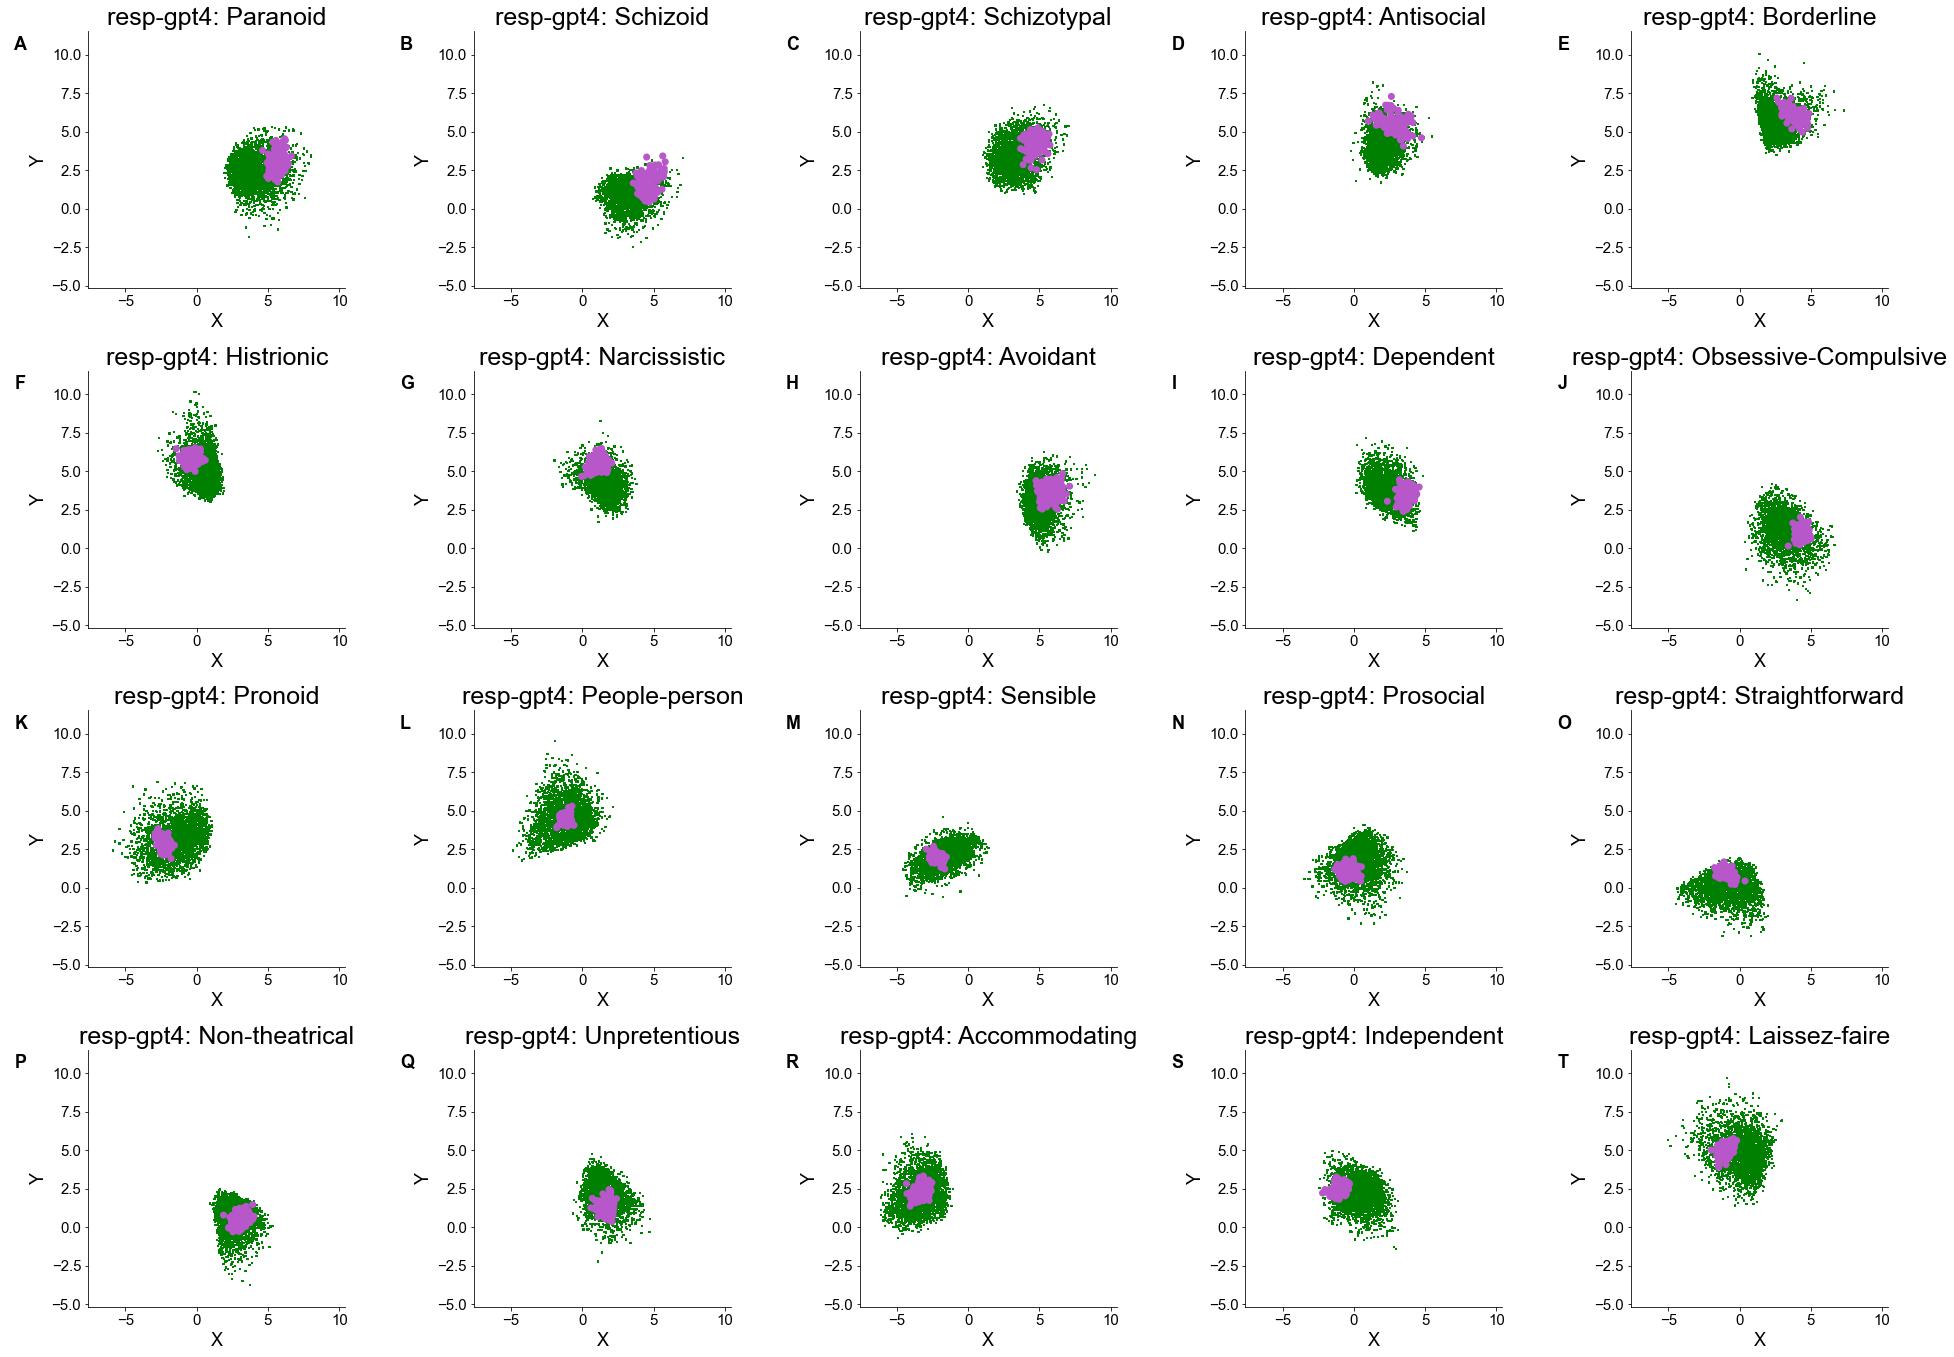

In [74]:
output_layout = (original_lda_imgs[0] * gpt4_lda_imgs[0])

for idx in range(1, 20):
    output_layout += (original_lda_imgs[idx] * gpt4_lda_imgs[idx])

output_layout.opts(fig_inches=5, fig_bounds=(0, 0, 1, 1)).cols(5)

hv.save(output_layout, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/responses_seperated_gpt4.png", fmt="png")

output_layout


### Analysis


## IRR


In [75]:
irr_gpt4 = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_gpt4_all_infromation[df_gpt4_all_infromation.Label == label_idx]
    np_label_subset = df_label_subset.iloc[:, 0:50].to_numpy()

    irr = CalcInterRaterReliability(np_label_subset)
    irr_gpt4[label_idx] = irr
    print(f"{LABEL_NAMES[label_idx]}: {irr}")

Paranoid: 0.6455930118110236
Schizoid: 0.6173154527559055
Schizotypal: 0.6592372047244095
Antisocial: 0.654800688976378
Borderline: 0.6750688976377953
Histrionic: 0.706306594488189
Narcissistic: 0.6703863188976378
Avoidant: 0.5975959645669291
Dependent: 0.7104995078740157
Obsessive-Compulsive: 0.7507529527559055
Pronoid: 0.772017716535433
People-person: 0.7571407480314961
Sensible: 0.7696456692913386
Prosocial: 0.7112770669291338
Straightforward: 0.791060531496063
Non-theatrical: 0.6940969488188976
Unpretentious: 0.6778666338582677
Accommodating: 0.7475246062992126
Independent: 0.7168233267716535
Laissez-faire: 0.7312819881889764


## Root Mean Squared Prediction Error (againstg Personality Facttors)

In [76]:
rmspe_facttors_gpt4 = np.zeros((20, 5))

for label_idx in range(0, 20):
    df_label_subset = df_gpt4_all_infromation[df_gpt4_all_infromation.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])

    rmspe = RootMeanSquaredError(np_array = np_ocean_subset, np_predictor = OCEAN_estimate)
    rmspe_facttors_gpt4[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")

Paranoid: [0.05512415 0.11486038 0.10937511 0.04305638 0.20250968]
Schizoid: [0.03551243 0.11709371 0.05302748 0.11431863 0.11350076]
Schizotypal: [0.08483431 0.06455678 0.03052125 0.09558079 0.17393026]
Antisocial: [0.10687182 0.02248263 0.08489424 0.03991377 0.1682138 ]
Borderline: [0.10478911 0.03908095 0.11355237 0.06227616 0.09512874]
Histrionic: [0.06637323 0.0387033  0.06194365 0.2270186  0.11380981]
Narcissistic: [0.12043158 0.06193671 0.08307212 0.08684856 0.15385002]
Avoidant: [0.06465908 0.11952929 0.0513642  0.12512675 0.05389515]
Dependent: [0.0663206  0.05664873 0.10744374 0.08952269 0.1344111 ]
Obsessive-Compulsive: [0.15377307 0.05604072 0.10673683 0.09975525 0.11621471]
Pronoid: [0.10092154 0.10871918 0.0801075  0.04164283 0.06442668]
People-person: [0.08605049 0.13567683 0.06966297 0.20861429 0.11613738]
Sensible: [0.20799354 0.11259371 0.0415414  0.16593528 0.04622229]
Prosocial: [0.18256234 0.05960973 0.08061652 0.0737536  0.08521792]
Straightforward: [0.23461757 0.

## RMSE of Euclidean Distance (against Personality)


In [77]:
rmspe_distance_gpt4 = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_gpt4_all_infromation[df_gpt4_all_infromation.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])

    # Get the distance between the labeld point and the instance
    np_distance_subset = np.zeros((np_ocean_subset.shape[0], 1))
    for idx in range(np_ocean_subset.shape[0]):
        np_distance_subset[idx] = np.linalg.norm(np_ocean_subset[idx] - OCEAN_estimate)

    # Calc the avgerage prediction distance
    np_avg_distance = np.mean(np_distance_subset)
    
    rmspe = RootMeanSquaredError(np_array = np_distance_subset, np_predictor = np_avg_distance)
    rmspe_distance_gpt4[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")  


Paranoid: [0.05724061]
Schizoid: [0.06424289]
Schizotypal: [0.04932145]
Antisocial: [0.05838473]
Borderline: [0.04409744]
Histrionic: [0.05646152]
Narcissistic: [0.04398998]
Avoidant: [0.05439462]
Dependent: [0.04126353]
Obsessive-Compulsive: [0.04660261]
Pronoid: [0.04479248]
People-person: [0.02738202]
Sensible: [0.03343846]
Prosocial: [0.0350036]
Straightforward: [0.03791518]
Non-theatrical: [0.05273957]
Unpretentious: [0.04495418]
Accommodating: [0.04639021]
Independent: [0.05471297]
Laissez-faire: [0.03759871]


C:\Users\38977332\AppData\Local\Temp\ipykernel_15448\198063332.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmspe_distance_gpt4[label_idx] = rmspe


## RMSE Cosine Similarity (against Personality)


In [78]:
rmspe_cos_gpt4 = np.zeros(20)

for label_idx in range(0, 20):
    df_label_subset = df_gpt4_all_infromation[df_gpt4_all_infromation.Label == label_idx]
    np_ocean_subset = df_label_subset.iloc[:, 50:55].to_numpy()
    OCEAN_estimate = np.array(OCEAN_PROFILE_CORD[label_idx])
    
    # Calculate the Cosine Similarity for each personality result
    np_cos_similarity = np.zeros((np_ocean_subset.shape[0], 1))
    for idx in range(np_ocean_subset.shape[0]): 
        dot_product = np.dot(np_ocean_subset[idx], OCEAN_estimate)
        norm_instant = np.linalg.norm(np_ocean_subset[idx])
        norm_predict = np.linalg.norm(OCEAN_estimate)
        np_cos_similarity[idx] = dot_product/(norm_instant*norm_predict)

    # Calculate the Avg Cosine Similarity
    avg_cos_similarity = np.mean(np_cos_similarity)

    rmspe = RootMeanSquaredError(np_array = np_cos_similarity, np_predictor = avg_cos_similarity)
    rmspe_cos_gpt4[label_idx] = rmspe
    print(f"{LABEL_NAMES[label_idx]}: {rmspe}")   

Paranoid: [0.01348138]
Schizoid: [0.01714066]
Schizotypal: [0.00728213]
Antisocial: [0.00895358]
Borderline: [0.00581198]
Histrionic: [0.0046879]
Narcissistic: [0.00404658]
Avoidant: [0.00751889]
Dependent: [0.00425069]
Obsessive-Compulsive: [0.00691522]
Pronoid: [0.00302039]
People-person: [0.00229118]
Sensible: [0.00314213]
Prosocial: [0.00426546]
Straightforward: [0.00315864]
Non-theatrical: [0.01032832]
Unpretentious: [0.00469041]
Accommodating: [0.0036045]
Independent: [0.00316616]
Laissez-faire: [0.0035785]


C:\Users\38977332\AppData\Local\Temp\ipykernel_15448\543868633.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmspe_cos_gpt4[label_idx] = rmspe


# Final Analysis

In [79]:
irr_final = np.column_stack([irr_original, 
                            irr_turbo, 
                            irr_devinchi, 
                            irr_gpt4])

rmspe_facttors_final = np.dstack([rmspe_facttors_original,
                                       rmspe_facttors_turbo,
                                       rmspe_facttors_devinchi,
                                       rmspe_facttors_gpt4])

rmspe_distance_final = np.column_stack([rmspe_distance_original,
                                       rmspe_distance_turbo,
                                       rmspe_distance_devinchi,
                                       rmspe_distance_gpt4])

rmspe_cos_final = np.column_stack([rmspe_cos_original,
                                  rmspe_cos_turbo,
                                  rmspe_cos_devinchi,
                                  rmspe_cos_gpt4])

In [80]:
irr_final

array([[0.29271648, 0.45003199, 0.63893947, 0.64559301],
       [0.31211037, 0.46753937, 0.57596949, 0.61731545],
       [0.29650843, 0.45777313, 0.62921506, 0.6592372 ],
       [0.26189279, 0.50752461, 0.56691191, 0.65480069],
       [0.30301492, 0.47489665, 0.65931348, 0.6750689 ],
       [0.29285624, 0.57819636, 0.52166093, 0.70630659],
       [0.27557953, 0.53287648, 0.52846211, 0.67038632],
       [0.34922254, 0.41200295, 0.68140994, 0.59759596],
       [0.29622225, 0.45891732, 0.6639124 , 0.71049951],
       [0.30609076, 0.54663632, 0.60722441, 0.75075295],
       [0.31620062, 0.57252707, 0.61189469, 0.77201772],
       [0.32362635, 0.58914616, 0.56489665, 0.75714075],
       [0.31037945, 0.58296014, 0.64721703, 0.76964567],
       [0.3024578 , 0.55076772, 0.6267938 , 0.71127707],
       [0.32912862, 0.59831201, 0.6540502 , 0.79106053],
       [0.30033088, 0.50339567, 0.60615404, 0.69409695],
       [0.304437  , 0.51626476, 0.60480561, 0.67786663],
       [0.37569066, 0.56837598,

In [81]:
rmspe_facttors_original

array([[0.3130285 , 0.19371939, 0.15462747, 0.10718717, 0.14718485],
       [0.26635568, 0.15108948, 0.0758392 , 0.15017387, 0.17327798],
       [0.26075069, 0.1726315 , 0.103469  , 0.15858812, 0.13906502],
       [0.19426538, 0.10126697, 0.13170155, 0.13051935, 0.11500082],
       [0.2459897 , 0.17059297, 0.11723823, 0.18161473, 0.10031845],
       [0.19180052, 0.13994932, 0.14716022, 0.15517649, 0.13819735],
       [0.25867494, 0.20037779, 0.15128656, 0.10748249, 0.11292139],
       [0.2530869 , 0.20118567, 0.09383951, 0.18840627, 0.08478073],
       [0.27371846, 0.14745791, 0.12728884, 0.14112336, 0.11472606],
       [0.27601839, 0.08550764, 0.15503239, 0.13808547, 0.15709873],
       [0.21310299, 0.19031566, 0.13878989, 0.10702253, 0.16115497],
       [0.20898032, 0.20009976, 0.14775029, 0.22589451, 0.16460097],
       [0.19332738, 0.18611625, 0.08917916, 0.1749304 , 0.09806009],
       [0.28863324, 0.13803214, 0.13018931, 0.12680027, 0.14163406],
       [0.30684311, 0.16306428, 0.

In [82]:
rmspe_facttors_final.T


array([[[0.3130285 , 0.26635568, 0.26075069, 0.19426538, 0.2459897 ,
         0.19180052, 0.25867494, 0.2530869 , 0.27371846, 0.27601839,
         0.21310299, 0.20898032, 0.19332738, 0.28863324, 0.30684311,
         0.25917056, 0.28400919, 0.27662496, 0.26341886, 0.16123396],
        [0.19371939, 0.15108948, 0.1726315 , 0.10126697, 0.17059297,
         0.13994932, 0.20037779, 0.20118567, 0.14745791, 0.08550764,
         0.19031566, 0.20009976, 0.18611625, 0.13803214, 0.16306428,
         0.14147158, 0.13083059, 0.24929948, 0.17637958, 0.1531222 ],
        [0.15462747, 0.0758392 , 0.103469  , 0.13170155, 0.11723823,
         0.14716022, 0.15128656, 0.09383951, 0.12728884, 0.15503239,
         0.13878989, 0.14775029, 0.08917916, 0.13018931, 0.16263349,
         0.1147932 , 0.13741694, 0.10748987, 0.20011435, 0.19738361],
        [0.10718717, 0.15017387, 0.15858812, 0.13051935, 0.18161473,
         0.15517649, 0.10748249, 0.18840627, 0.14112336, 0.13808547,
         0.10702253, 0.22589451

In [83]:
rmspe_distance_final

array([[0.15022779, 0.07514209, 0.05686462, 0.05724061],
       [0.13682412, 0.06280686, 0.06811844, 0.06424289],
       [0.12026157, 0.06237685, 0.0693334 , 0.04932145],
       [0.10042153, 0.05742173, 0.08380014, 0.05838473],
       [0.11236582, 0.07902346, 0.05654508, 0.04409744],
       [0.09889835, 0.04279538, 0.07188865, 0.05646152],
       [0.12196393, 0.05257253, 0.06959185, 0.04398998],
       [0.14005827, 0.08602278, 0.05956911, 0.05439462],
       [0.12588075, 0.05184939, 0.05074092, 0.04126353],
       [0.10829842, 0.04801076, 0.06191897, 0.04660261],
       [0.10932626, 0.04384566, 0.0564114 , 0.04479248],
       [0.11699743, 0.04588526, 0.05542085, 0.02738202],
       [0.11698957, 0.04866385, 0.04354959, 0.03343846],
       [0.12631744, 0.04407662, 0.0535345 , 0.0350036 ],
       [0.13701598, 0.04818726, 0.05110012, 0.03791518],
       [0.12239628, 0.06121025, 0.06199649, 0.05273957],
       [0.12272594, 0.05433155, 0.05848546, 0.04495418],
       [0.13804956, 0.04501238,

In [84]:
rmspe_cos_final

array([[0.03716438, 0.01463103, 0.01899406, 0.01348138],
       [0.05564541, 0.01208437, 0.02825459, 0.01714066],
       [0.0263836 , 0.00934026, 0.02070537, 0.00728213],
       [0.03055248, 0.01190128, 0.02403475, 0.00895358],
       [0.01620069, 0.01756452, 0.01181737, 0.00581198],
       [0.01245849, 0.00561803, 0.02002784, 0.0046879 ],
       [0.02494238, 0.01097811, 0.02516295, 0.00404658],
       [0.01899462, 0.02363106, 0.01791728, 0.00751889],
       [0.0134393 , 0.00974502, 0.0127907 , 0.00425069],
       [0.01799513, 0.01077989, 0.01835548, 0.00691522],
       [0.01375806, 0.00463295, 0.00973855, 0.00302039],
       [0.01172313, 0.00513396, 0.01634046, 0.00229118],
       [0.00944862, 0.0039938 , 0.01025629, 0.00314213],
       [0.01741556, 0.00402333, 0.01107999, 0.00426546],
       [0.02799902, 0.00519864, 0.00636637, 0.00315864],
       [0.02725423, 0.00679611, 0.02085318, 0.01032832],
       [0.01837838, 0.00509665, 0.01661924, 0.00469041],
       [0.01352873, 0.00587336,

In [85]:
print(f"{turbo_accuracy}, {devinchi_accuracy}, {gpt4_accuracy}")

0.177734375, 0.13828125, 0.73984375


In [86]:
first_example_idx = 1
second_example_idx = 5
third_example_idx = 15

:Layout
   .Overlay.I    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.II   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.III  :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.IV   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.V    :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VI   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VII  :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.VIII :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
   .Overlay.IX   :Overlay
      .Scatter.I  :Scatter   [X]   (Y,Label)
      .Scatter.II :Scatter   [X]   (Y,Label)
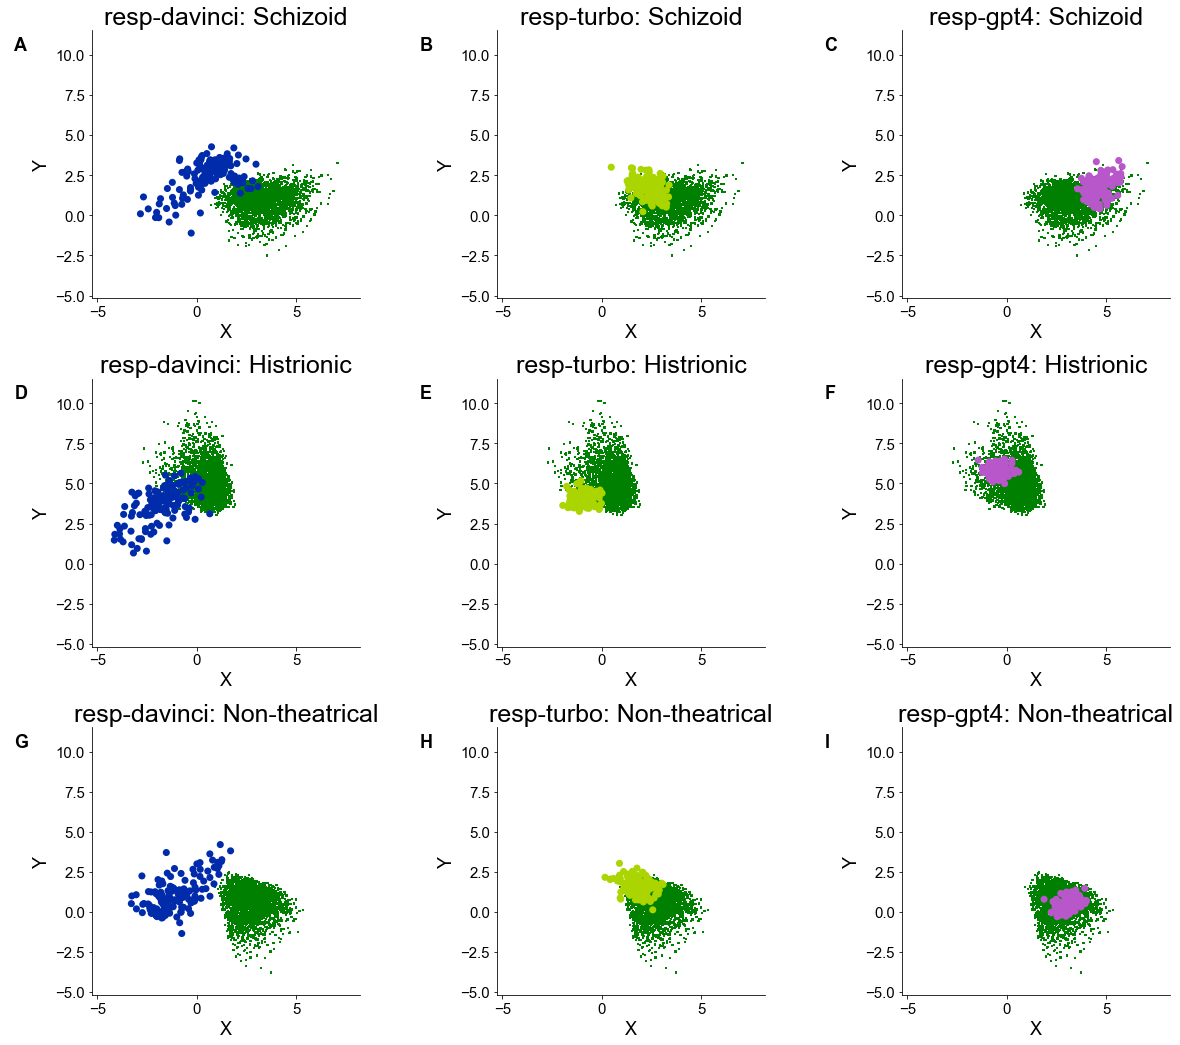

In [87]:
output_layout = (original_lda_imgs[first_example_idx] * devinchi_lda_imgs[first_example_idx]) + (original_lda_imgs[first_example_idx] * turbo_lda_imgs[first_example_idx] ) + (original_lda_imgs[first_example_idx] * gpt4_lda_imgs[first_example_idx]) + (original_lda_imgs[second_example_idx] * devinchi_lda_imgs[second_example_idx]) + (original_lda_imgs[second_example_idx] * turbo_lda_imgs[second_example_idx]) + (original_lda_imgs[second_example_idx] * gpt4_lda_imgs[second_example_idx]) + (original_lda_imgs[third_example_idx] * devinchi_lda_imgs[third_example_idx]) + (original_lda_imgs[third_example_idx] * turbo_lda_imgs[third_example_idx]) + (original_lda_imgs[third_example_idx] * gpt4_lda_imgs[third_example_idx])

output_layout.opts(fig_inches=5, fig_bounds=(0, 0, 1, 1)).cols(3)

hv.save(output_layout, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/resp_examples.png", fmt="png")

output_layout

:Layout
   .Overlay.I    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.II   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.III  :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.IV   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.V    :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VI   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VII  :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.VIII :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
   .Overlay.IX   :Overlay
      .Scatter.I   :Scatter   [Beta]   (Alpha,Label)
      .Scatter.II  :Scatter   [Beta]   (Alpha,Label)
      .Scatter.III :Scatter   [Beta]   (Alpha,Label)
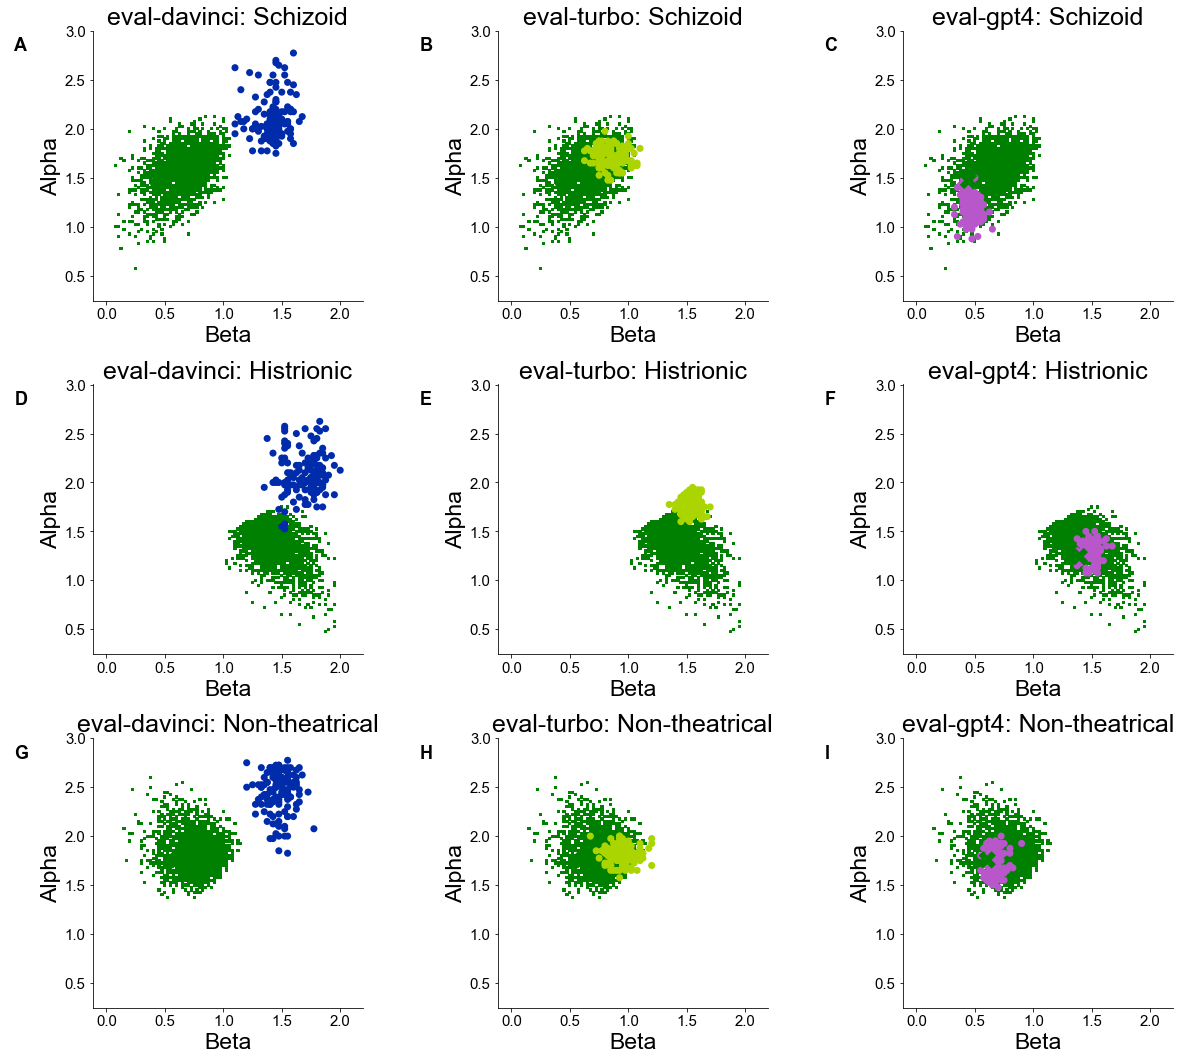

In [88]:
output_layout = (original_eval_imgs[first_example_idx] * devinchi_eval_imgs[first_example_idx] * profile_eval_imgs[first_example_idx]) + (original_eval_imgs[first_example_idx] * turbo_eval_imgs[first_example_idx] * profile_eval_imgs[first_example_idx]) + (original_eval_imgs[first_example_idx] * gpt4_eval_imgs[first_example_idx] * profile_eval_imgs[first_example_idx]) + (original_eval_imgs[second_example_idx] * devinchi_eval_imgs[second_example_idx] * profile_eval_imgs[second_example_idx]) + (original_eval_imgs[second_example_idx] * turbo_eval_imgs[second_example_idx] * profile_eval_imgs[second_example_idx]) + (original_eval_imgs[second_example_idx] * gpt4_eval_imgs[second_example_idx] * profile_eval_imgs[second_example_idx]) + (original_eval_imgs[third_example_idx] * devinchi_eval_imgs[third_example_idx] * profile_eval_imgs[third_example_idx]) + (original_eval_imgs[third_example_idx] * turbo_eval_imgs[third_example_idx] * profile_eval_imgs[third_example_idx]) + (original_eval_imgs[third_example_idx] * gpt4_eval_imgs[third_example_idx] * profile_eval_imgs[third_example_idx])

output_layout.opts(fig_inches=5, fig_bounds=(0, 0, 1, 1)).cols(3)

hv.save(output_layout, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/eval_examples.png", fmt="png")

output_layout

In [89]:
#df_all_infromation_subset.drop(labels="Model", axis=1, inplace=True)
#df_all_infromation_subset

In [90]:
df_all_infromation_subset.insert(loc=len(df_all_infromation_subset.columns), column="Model", value=np.zeros(len(df_all_infromation_subset.index)), allow_duplicates=True)
df_all_infromation_subset["Model"] = df_all_infromation_subset["Model"].astype(int)
df_all_infromation_subset["Model"] = df_all_infromation_subset["Model"].astype('category')
df_all_infromation_subset["Model"] = df_all_infromation_subset["Model"].cat.rename_categories({0:"Baseline"})
df_all_infromation_subset

df_all_infromation_subset.drop(labels="Model", axis=1, inplace=True)
#df_all_infromation_subset

In [91]:
df_all_infromation_subset["Label"] = df_all_infromation_subset["Label"].astype('category')
df_all_infromation_subset["Label"] = df_all_infromation_subset["Label"].cat.rename_categories({0:"Paranoid", 
                                                                                           1:"Schizoid", 
                                                                                           2:"Schizotypal", 
                                                                                           3:"Antisocial", 
                                                                                           4:"Borderline", 
                                                                                           5:"Histrionic", 
                                                                                           6:"Narcissistic", 
                                                                                           7:"Avoidant", 
                                                                                           8:"Dependent", 
                                                                                           9:"Obsessive-Compulsive", 
                                                                                           10:"Pronoid", 
                                                                                           11:"People-person", 
                                                                                           12:"Sensible", 
                                                                                           13:"Prosocial", 
                                                                                           14:"Straightforward", 
                                                                                           15:"Non-theatrical", 
                                                                                           16:"Unpretentious", 
                                                                                           17:"Accommodating", 
                                                                                           18:"Independent", 
                                                                                           19:"Laissez-faire"})
df_all_infromation_subset

E1  E2  E3  E4  E5  E6  E7  E8  E9  E10  ...  O9  O10  Openness  \
405630   3   4   2   4   2   4   2   4   3    4  ...   4    4     0.775   
568814   1   5   2   5   1   5   1   5   2    4  ...   3    2     0.525   
158994   1   2   3   5   2   5   1   5   5    5  ...   4    5     0.875   
445389   1   4   2   4   2   2   1   4   2    5  ...   4    4     0.775   
17219    4   4   4   4   1   4   2   4   2    4  ...   4    5     0.600   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ..  ...       ...   
428215   2   4   3   4   2   3   2   3   4    3  ...   5    5     0.875   
269417   3   1   4   3   4   2   3   3   3    3  ...   4    5     0.850   
501332   3   3   5   2   3   1   1   2   5    4  ...   5    4     0.675   
452168   4   1   4   1   5   1   5   4   2    1  ...   1    5     0.825   
107318   3   3   3   4   3   2   4   4   2    3  ...   4    3     0.800   

        Conscientiousness  Extraversion  Agreeableness  Neuroticism  Alpha  \
405630              0.875         0.300          0.400        0.750  1.525   
568814              0.700         0.075          0.075        0.650  1.125   
158994              0.750         0.250          0.200        0.825  1.125   
445389              0.975         0.225          0.275        0.550  1.700   
17219               0.575         0.325          0.275        0.575  1.275   
...                   ...           ...            ...          ...    ...   
428215              0.400         0.400          0.625        0.275  1.750   
269417              0.325         0.625          0.625        0.600  1.350   
501332              0.300         0.625          0.375        0.325  1.350   
452168              0.225         0.800          0.575        0.500  1.300   
107318              0.400         0.475          0.450        0.500  1.350   

         Beta          Label  
405630  1.075       Paranoid  
568814  0.600       Paranoid  
158994  1.125       Paranoid  
445389  1.000       Paranoid  
17219   0.925       Paranoid  
...       ...            ...  
428215  1.275  Laissez-faire  
269417  1.475  Laissez-faire  
501332  1.300  Laissez-faire  
452168  1.625  Laissez-faire  
107318  1.275  Laissez-faire  

[50500 rows x 58 columns]

In [92]:
df_all_infromation_subset ["Label"] = df_all_infromation_subset["Label"].astype('category')
df_all_infromation_subset["Label"] = df_all_infromation_subset["Label"].cat.rename_categories({0:"Paranoid", 
                                                                                           1:"Schizoid", 
                                                                                           2:"Schizotypal", 
                                                                                           3:"Antisocial", 
                                                                                           4:"Borderline", 
                                                                                           5:"Histrionic", 
                                                                                           6:"Narcissistic", 
                                                                                           7:"Avoidant", 
                                                                                           8:"Dependent", 
                                                                                           9:"Obsessive-Compulsive", 
                                                                                           10:"Pronoid", 
                                                                                           11:"People-person", 
                                                                                           12:"Sensible", 
                                                                                           13:"Prosocial", 
                                                                                           14:"Straightforward", 
                                                                                           15:"Non-theatrical", 
                                                                                           16:"Unpretentious", 
                                                                                           17:"Accommodating", 
                                                                                           18:"Independent", 
                                                                                           19:"Laissez-faire"})

df_turbo_all_infromation ["Label"] = df_turbo_all_infromation["Label"].astype('category')
df_turbo_all_infromation["Label"] = df_turbo_all_infromation["Label"].cat.rename_categories({0:"Paranoid", 
                                                                                           1:"Schizoid", 
                                                                                           2:"Schizotypal", 
                                                                                           3:"Antisocial", 
                                                                                           4:"Borderline", 
                                                                                           5:"Histrionic", 
                                                                                           6:"Narcissistic", 
                                                                                           7:"Avoidant", 
                                                                                           8:"Dependent", 
                                                                                           9:"Obsessive-Compulsive", 
                                                                                           10:"Pronoid", 
                                                                                           11:"People-person", 
                                                                                           12:"Sensible", 
                                                                                           13:"Prosocial", 
                                                                                           14:"Straightforward", 
                                                                                           15:"Non-theatrical", 
                                                                                           16:"Unpretentious", 
                                                                                           17:"Accommodating", 
                                                                                           18:"Independent", 
                                                                                           19:"Laissez-faire"})


df_devinchi_all_infromation ["Label"] = df_devinchi_all_infromation["Label"].astype('category')
df_devinchi_all_infromation["Label"] = df_devinchi_all_infromation["Label"].cat.rename_categories({0:"Paranoid", 
                                                                                           1:"Schizoid", 
                                                                                           2:"Schizotypal", 
                                                                                           3:"Antisocial", 
                                                                                           4:"Borderline", 
                                                                                           5:"Histrionic", 
                                                                                           6:"Narcissistic", 
                                                                                           7:"Avoidant", 
                                                                                           8:"Dependent", 
                                                                                           9:"Obsessive-Compulsive", 
                                                                                           10:"Pronoid", 
                                                                                           11:"People-person", 
                                                                                           12:"Sensible", 
                                                                                           13:"Prosocial", 
                                                                                           14:"Straightforward", 
                                                                                           15:"Non-theatrical", 
                                                                                           16:"Unpretentious", 
                                                                                           17:"Accommodating", 
                                                                                           18:"Independent", 
                                                                                           19:"Laissez-faire"})


df_gpt4_all_infromation ["Label"] = df_gpt4_all_infromation["Label"].astype('category')
df_gpt4_all_infromation["Label"] = df_gpt4_all_infromation["Label"].cat.rename_categories({0:"Paranoid", 
                                                                                           1:"Schizoid", 
                                                                                           2:"Schizotypal", 
                                                                                           3:"Antisocial", 
                                                                                           4:"Borderline", 
                                                                                           5:"Histrionic", 
                                                                                           6:"Narcissistic", 
                                                                                           7:"Avoidant", 
                                                                                           8:"Dependent", 
                                                                                           9:"Obsessive-Compulsive", 
                                                                                           10:"Pronoid", 
                                                                                           11:"People-person", 
                                                                                           12:"Sensible", 
                                                                                           13:"Prosocial", 
                                                                                           14:"Straightforward", 
                                                                                           15:"Non-theatrical", 
                                                                                           16:"Unpretentious", 
                                                                                           17:"Accommodating", 
                                                                                           18:"Independent", 
                                                                                           19:"Laissez-faire"})

In [93]:
df_turbo_all_infromation.insert(loc=len(df_turbo_all_infromation.columns), column="Model", value=np.full(len(df_turbo_all_infromation.index), 1), allow_duplicates=True)
df_turbo_all_infromation["Model"] = df_turbo_all_infromation["Model"].astype(int)
df_turbo_all_infromation["Model"] = df_turbo_all_infromation["Model"].astype('category')
df_turbo_all_infromation["Model"] = df_turbo_all_infromation["Model"].cat.rename_categories({1:"Turbo"})


df_devinchi_all_infromation.insert(loc=len(df_devinchi_all_infromation.columns), column="Model", value=np.full(len(df_devinchi_all_infromation.index), 2), allow_duplicates=True)
df_devinchi_all_infromation["Model"] = df_devinchi_all_infromation["Model"].astype(int)
df_devinchi_all_infromation["Model"] = df_devinchi_all_infromation["Model"].astype('category')
df_devinchi_all_infromation["Model"] = df_devinchi_all_infromation["Model"].cat.rename_categories({2:"Davinci"})

df_gpt4_all_infromation.insert(loc=len(df_gpt4_all_infromation.columns), column="Model", value=np.full(len(df_gpt4_all_infromation.index), 3), allow_duplicates=True)
df_gpt4_all_infromation["Model"] = df_gpt4_all_infromation["Model"].astype(int)
df_gpt4_all_infromation["Model"] = df_gpt4_all_infromation["Model"].astype('category')
df_gpt4_all_infromation["Model"] = df_gpt4_all_infromation["Model"].cat.rename_categories({3:"GPT-4"})

In [94]:
DF_PROFILES ["Label"] = DF_PROFILES["Label"].astype('category')
DF_PROFILES["Label"] = DF_PROFILES["Label"].cat.rename_categories({0:"Paranoid", 
                                                                1:"Schizoid", 
                                                                2:"Schizotypal", 
                                                                3:"Antisocial", 
                                                                4:"Borderline", 
                                                                5:"Histrionic", 
                                                                6:"Narcissistic", 
                                                                7:"Avoidant", 
                                                                8:"Dependent", 
                                                                9:"Obsessive-Compulsive", 
                                                                10:"Pronoid", 
                                                                11:"People-person", 
                                                                12:"Sensible", 
                                                                13:"Prosocial", 
                                                                14:"Straightforward", 
                                                                15:"Non-theatrical", 
                                                                16:"Unpretentious", 
                                                                17:"Accommodating", 
                                                                18:"Independent", 
                                                                19:"Laissez-faire"})

In [95]:
df_all_infromation = pd.concat([df_all_infromation_subset,df_devinchi_all_infromation, df_turbo_all_infromation,df_gpt4_all_infromation])

In [96]:
df_all_infromation["Model"] = df_all_infromation["Model"].astype(str)
df_all_infromation["Label"] = df_all_infromation["Label"].astype(str)

In [97]:
#df_all_infromation.drop(labels="LabelModel", axis=1, inplace=True)
df_all_infromation['LabelModel'] = df_all_infromation['Label'] + ',' + df_all_infromation['Model']
df_all_infromation
#df_all_infromation["LabelModel"] = df_all_infromation["LabelModel"].astype('category')

E1  E2  E3  E4  E5  E6  E7  E8  E9  E10  ...  Openness  \
405630   3   4   2   4   2   4   2   4   3    4  ...     0.775   
568814   1   5   2   5   1   5   1   5   2    4  ...     0.525   
158994   1   2   3   5   2   5   1   5   5    5  ...     0.875   
445389   1   4   2   4   2   2   1   4   2    5  ...     0.775   
17219    4   4   4   4   1   4   2   4   2    4  ...     0.600   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...       ...   
2555     4   2   5   2   4   2   4   2   4    3  ...     0.675   
2556     4   2   4   2   4   2   4   3   4    2  ...     0.725   
2557     4   2   4   2   4   2   4   2   3    3  ...     0.725   
2558     5   2   5   2   4   2   5   2   4    2  ...     0.725   
2559     4   2   4   2   4   2   4   2   3    2  ...     0.700   

        Conscientiousness  Extraversion  Agreeableness  Neuroticism  Alpha  \
405630              0.875         0.300          0.400        0.750  1.525   
568814              0.700         0.075          0.075        0.650  1.125   
158994              0.750         0.250          0.200        0.825  1.125   
445389              0.975         0.225          0.275        0.550  1.700   
17219               0.575         0.325          0.275        0.575  1.275   
...                   ...           ...            ...          ...    ...   
2555                0.275         0.750          0.725        0.575  1.425   
2556                0.325         0.725          0.725        0.475  1.575   
2557                0.250         0.700          0.700        0.575  1.375   
2558                0.300         0.825          0.675        0.525  1.450   
2559                0.225         0.725          0.700        0.550  1.375   

         Beta          Label  Model           LabelModel  
405630  1.075       Paranoid    nan         Paranoid,nan  
568814  0.600       Paranoid    nan         Paranoid,nan  
158994  1.125       Paranoid    nan         Paranoid,nan  
445389  1.000       Paranoid    nan         Paranoid,nan  
17219   0.925       Paranoid    nan         Paranoid,nan  
...       ...            ...    ...                  ...  
2555    1.425  Laissez-faire  GPT-4  Laissez-faire,GPT-4  
2556    1.450  Laissez-faire  GPT-4  Laissez-faire,GPT-4  
2557    1.425  Laissez-faire  GPT-4  Laissez-faire,GPT-4  
2558    1.550  Laissez-faire  GPT-4  Laissez-faire,GPT-4  
2559    1.425  Laissez-faire  GPT-4  Laissez-faire,GPT-4  

[58180 rows x 60 columns]

In [98]:
Label_Model_categories=["Paranoid,Baseline","Paranoid,Davinci","Paranoid,Turbo","Paranoid,GPT-4","Schizoid,Baseline","Schizoid,Davinci","Schizoid,Turbo","Schizoid,GPT-4","Schizotypal,Baseline","Schizotypal,Davinci","Schizotypal,Turbo","Schizotypal,GPT-4","Antisocial,Baseline","Antisocial,Davinci","Antisocial,Turbo","Antisocial,GPT-4","Borderline,Baseline","Borderline,Davinci","Borderline,Turbo","Borderline,GPT-4","Histrionic,Baseline","Histrionic,Davinci","Histrionic,Turbo","Histrionic,GPT-4","Narcissistic,Baseline","Narcissistic,Davinci","Narcissistic,Turbo","Narcissistic,GPT-4","Avoidant,Baseline","Avoidant,Davinci","Avoidant,Turbo","Avoidant,GPT-4","Dependent,Baseline","Dependent,Davinci","Dependent,Turbo","Dependent,GPT-4","Obsessive-Compulsive,Baseline","Obsessive-Compulsive,Davinci","Obsessive-Compulsive,Turbo","Obsessive-Compulsive,GPT-4","Pronoid,Baseline","Pronoid,Davinci","Pronoid,Turbo","Pronoid,GPT-4","People-person,Baseline","People-person,Davinci","People-person,Turbo","People-person,GPT-4","Sensible,Baseline","Sensible,Davinci","Sensible,Turbo","Sensible,GPT-4","Prosocial,Baseline","Prosocial,Davinci","Prosocial,Turbo","Prosocial,GPT-4","Straightforward,Baseline","Straightforward,Davinci","Straightforward,Turbo","Straightforward,GPT-4","Non-theatrical,Baseline","Non-theatrical,Davinci","Non-theatrical,Turbo","Non-theatrical,GPT-4","Unpretentious,Baseline","Unpretentious,Davinci","Unpretentious,Turbo","Unpretentious,GPT-4","Accommodating,Baseline","Accommodating,Davinci","Accommodating,Turbo","Accommodating,GPT-4","Independent,Baseline","Independent,Davinci","Independent,Turbo","Independent,GPT-4","Laissez-faire,Baseline","Laissez-faire,Davinci","Laissez-faire,Turbo","Laissez-faire,GPT-4"]
df_all_infromation["LabelModel"] = pd.Categorical(df_all_infromation["LabelModel"], categories = Label_Model_categories)
df_all_infromation.sort_values(by = "LabelModel", inplace=True)

In [99]:
#df_all_infromation.drop(labels="ModelLabel", axis=1, inplace=True)

In [100]:
violin_Openness = hv.Violin(data=df_all_infromation, kdims=["LabelModel"], vdims=["Openness"]).opts(widths = 1.25, box_color="LabelModel")
point_Openness = hv.Scatter(np.repeat(NP_OCEAN_PROFILES[:, 0], 4)).opts(color='Magenta', s=200)
Openness_plot = (violin_Openness * point_Openness).opts(aspect=5, fig_size=1800, xrotation=90, fontscale=4)

hv.save(Openness_plot, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/violin_Openness.png", fmt="png")

violin_Conscientiousness = hv.Violin(data=df_all_infromation, kdims=["LabelModel"], vdims=["Conscientiousness"]).opts(widths = 1.25)
point_Conscientiousness = hv.Scatter(np.repeat(NP_OCEAN_PROFILES[:, 1], 4)).opts(color='Magenta', s=200)
Conscientiousness_plot = (violin_Conscientiousness * point_Conscientiousness).opts(aspect=5, fig_size=1800, xrotation=90, fontscale=4)

hv.save(Conscientiousness_plot, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/violin_Conscientiousness.png", fmt="png")


violin_Extraversion = hv.Violin(data=df_all_infromation, kdims=["LabelModel"], vdims=["Extraversion"]).opts(widths = 1.25)
point_Extraversion = hv.Scatter(np.repeat(NP_OCEAN_PROFILES[:, 2], 4)).opts(color='Magenta', s=200)
Extraversion_plot = (violin_Extraversion * point_Extraversion).opts(aspect=5, fig_size=1800, xrotation=90, fontscale=4)

hv.save(Extraversion_plot, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/violin_Extraversion.png", fmt="png")

violin_Agreeableness = hv.Violin(data=df_all_infromation, kdims=["LabelModel"], vdims=["Agreeableness"]).opts(widths = 1.25)
point_Agreeableness = hv.Scatter(np.repeat(NP_OCEAN_PROFILES[:, 3], 4)).opts(color='Magenta', s=200)
Agreeableness_plot = (violin_Agreeableness * point_Agreeableness).opts(aspect=5, fig_size=1800, xrotation=90, fontscale=4)

hv.save(Agreeableness_plot, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/violin_Agreeableness.png", fmt="png")

violin_Neuroticism = hv.Violin(data=df_all_infromation, kdims=["LabelModel"], vdims=["Neuroticism"]).opts(widths = 1.25)
point_Neuroticism = hv.Scatter(np.repeat(NP_OCEAN_PROFILES[:, 4], 4)).opts(color='Magenta', s=200)
Neuroticism_plot = (violin_Neuroticism * point_Neuroticism).opts(aspect=5, fig_size=1800, xrotation=90, fontscale=4)

hv.save(Neuroticism_plot, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/violin_Neuroticism.png", fmt="png")

C:\Users\38977332\OneDrive - Southern Methodist University\Documents\School\APF\Repos\apf\LLM Personality\venv\Lib\site-packages\holoviews\core\data\pandas.py:239: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset.data.groupby(group_by, sort=False)]
C:\Users\38977332\OneDrive - Southern Methodist University\Documents\School\APF\Repos\apf\LLM Personality\venv\Lib\site-packages\holoviews\core\data\pandas.py:274: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = reindexed.groupby(cols, sort=False)


ValueError: Mapping a dimension to the "box_color" style option is not supported by the Violin element using the matplotlib backend. To map the "LabelModel" dimension to the box_color use a groupby operation to overlay your data along the dimension.

In [ ]:
color_idx = 10

violin_Openness = df_all_infromation.hvplot.violin(y="Openness", by="LabelModel", c='Model', legend=False, widths = 1.30, 
                 width=6000, height=1000, padding=0.1, facecolors=[LABEL_COLORS_HEX[(color_idx + 0) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx + 2) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx - 2) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx + 8) % 20]])
point_Openness = hv.Scatter(np.repeat(NP_OCEAN_PROFILES[:, 0], 4)).opts(color=LABEL_COLORS_HEX[(color_idx - 8) % 20], s=200)
Openness_plot = (violin_Openness * point_Openness).opts(aspect=5, fig_size=1800, xrotation=90, fontscale=4)
hv.save(Openness_plot, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/violin_Openness.png", fmt="png")


violin_Conscientiousness = df_all_infromation.hvplot.violin(y="Conscientiousness", by="LabelModel", c='Model', legend=False, widths = 1.30, 
                 width=6000, height=1000, padding=0.1, facecolors=[LABEL_COLORS_HEX[(color_idx + 0) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx + 2) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx - 2) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx + 8) % 20]])
point_Conscientiousness = hv.Scatter(np.repeat(NP_OCEAN_PROFILES[:, 1], 4)).opts(color=LABEL_COLORS_HEX[(color_idx - 8) % 20], s=200)
Conscientiousness_plot = (violin_Conscientiousness * point_Conscientiousness).opts(aspect=5, fig_size=1800, xrotation=90, fontscale=4)
hv.save(Conscientiousness_plot, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/violin_Conscientiousness.png", fmt="png")


violin_Extraversion = df_all_infromation.hvplot.violin(y="Extraversion", by="LabelModel", c='Model', legend=False, widths = 1.30, 
                 width=6000, height=1000, padding=0.1, facecolors=[LABEL_COLORS_HEX[(color_idx + 0) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx + 2) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx - 2) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx + 8) % 20]])
point_Extraversion = hv.Scatter(np.repeat(NP_OCEAN_PROFILES[:, 2], 4)).opts(color=LABEL_COLORS_HEX[(color_idx - 8) % 20], s=200)
Extraversion_plot = (violin_Extraversion * point_Extraversion).opts(aspect=5, fig_size=1800, xrotation=90, fontscale=4)
hv.save(Extraversion_plot, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/violin_Extraversion.png", fmt="png")


violin_Agreeableness = df_all_infromation.hvplot.violin(y="Agreeableness", by="LabelModel", c='Model', legend=False, widths = 1.30, 
                 width=6000, height=1000, padding=0.1, facecolors=[LABEL_COLORS_HEX[(color_idx + 0) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx + 2) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx - 2) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx + 8) % 20]])
point_Agreeableness = hv.Scatter(np.repeat(NP_OCEAN_PROFILES[:, 3], 4)).opts(color=LABEL_COLORS_HEX[(color_idx - 8) % 20], s=200)
Agreeableness_plot = (violin_Agreeableness * point_Agreeableness).opts(aspect=5, fig_size=1800, xrotation=90, fontscale=4)
hv.save(Agreeableness_plot, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/violin_Agreeableness.png", fmt="png")


violin_Neuroticism = df_all_infromation.hvplot.violin(y="Neuroticism", by="LabelModel", c='Model', legend=False, widths = 1.30, 
                 width=6000, height=1000, padding=0.1, facecolors=[LABEL_COLORS_HEX[(color_idx + 0) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx + 2) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx - 2) % 20], 
                                                                   LABEL_COLORS_HEX[(color_idx + 8) % 20]])
point_Neuroticism = hv.Scatter(np.repeat(NP_OCEAN_PROFILES[:, 4], 4)).opts(color=LABEL_COLORS_HEX[(color_idx - 8) % 20], s=200)
Neuroticism_plot = (violin_Neuroticism * point_Neuroticism).opts(aspect=5, fig_size=1800, xrotation=90, fontscale=4)
hv.save(Neuroticism_plot, r"C:/Users/38977332/OneDrive - Southern Methodist University/Documents/School/APF/Repos/apf/LLM Personality/summer 23/notebooks/personality/results/images/violin_Neuroticism.png", fmt="png")